# Sodankyla

In [1]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.show_tracks import *
from scripts.parallel import *
from scripts.track_pairs import *
import geopandas as gpd
from shapely.geometry import Point, box as shapely_box
from scipy.optimize import least_squares
from sklearn.metrics import r2_score, mean_squared_error
from scripts.odr import *

def divide_arrays_2(X, Y):
    # Combine X and Y into a list of tuples
    combined = list(zip(X, Y))
    
    # Sort the combined list based on X values
    combined.sort(key=lambda tup: tup[0])
    
    # Calculate the midpoint
    midpoint = len(combined) // 2
    
    # Divide the combined list into lower and upper halves
    lower_half = combined[:midpoint]
    upper_half = combined[midpoint:]
    
    # Unzip the lower and upper halves into separate X and Y arrays
    lower_X, lower_Y = zip(*lower_half)
    upper_X, upper_Y = zip(*upper_half)
    
    return lower_X, lower_Y, upper_X, upper_Y

def divide_arrays_3(X, Y):
    # Combine X and Y into a list of tuples
    combined = list(zip(X, Y))
    
    # Sort the combined list based on X values
    combined.sort(key=lambda tup: tup[0])
    
    # Calculate the midpoint
    tripoint = len(combined) // 3
    
    # Divide the combined list into lower and upper halves
    lower_half = combined[:tripoint]
    upper_half = combined[2*tripoint:]
    
    # Unzip the lower and upper halves into separate X and Y arrays
    lower_X, lower_Y = zip(*lower_half)
    upper_X, upper_Y = zip(*upper_half)
    
    return lower_X, lower_Y, upper_X, upper_Y

def intercept_from_slope_and_point(slope, point):
    x1, y1 = point
    intercept = y1 - slope * x1
    return intercept

def find_slope_and_intercept(x1, y1, x2, y2):
    # Calculate slope
    slope = (y2 - y1) / (x2 - x1)
    
    # Calculate y-intercept
    intercept = y1 - slope * x1
    
    return slope, intercept

def parse_filename_datetime(filename):
    # Extracting only the filename from the full path
    filename_only = filename.split('/')[-1]
    
    # Finding the index of the first appearance of 'ATL03_' or 'ATL08_'
    atl03_index = filename_only.find('ATL03_')
    atl08_index = filename_only.find('ATL08_')
    
    # Determining the split index based on which string appears first or if neither is found
    split_index = min(filter(lambda x: x >= 0, [atl03_index, atl08_index]))

    # Extracting yyyymmddhhmmss part
    date_str = filename_only[split_index + 6:split_index + 20]
    
    datetime_obj = datetime.strptime(date_str, '%Y%m%d%H%M%S')
    return datetime_obj

def datetime_to_title(datetime_obj):
    return datetime_obj.strftime('%B %d, %Y, %H:%M:%S')

def make_box(coords, width=0.25, height=0.25):
    w = width
    h = height
    polygon = gpd.GeoDataFrame(geometry=[shapely_box(coords[0]-w/np.cos(np.radians(coords[1])), coords[1]-h, coords[0]+w/np.cos(np.radians(coords[1])), coords[1]+h)], crs="EPSG:4326")

    return polygon

# This function is called if the graph_detail is set to 2!
# I know I used different coding structure for this one but
# all I can really say is whoops and move on.
def plot_parallel(atl03s, coefs, colors, title_date, X, Y, beam = None, canopy_frac = None, terrain_frac = None, file_index=None, three=None):
    """
    Plotting function of pvpg_parallel. Shows a regression line for each available groudntrack in a bigger plot, as well as groundtrack visualisations in a smaller plot.
    
    atl03s - This is an array of ATL03 objects, one for each groundtrack that was successfully turned into an object. If only Beams 5 and 6 exist, then this has two objects in it, one for each of those beams.
    coefs - Array of parameters that are optimized, starting with the slope in coefs[0] and another parameter for each beam to control the y-intercept.
    colors - This holds the integers minus one of the beams that have groundtracks in the file. This is to keep the coloring in the plots consistent for each beam across all files.
    title_date - This is just the data and time of the ICESat-2 overpass. The parse_filename_datetime() function will take care of this for you.
    X - Array of each Eg dataset, [[data1],[data2],...]. This always has six arrays in it, one for each groundtrack from Beam 1 to Beam 6. If nothing is read, you get an empty array [], e.g. [[data1],[],[data3],...]
    Y - Array of each Ev dataset, see X description.
    beam - An array of beams to focus on. For example, if you only want to see pv/pg information on the plot for Beams 3 and 4, then you would set beam = [3,4]. Default is None, and all beams are shown.
    file_index - Default set to None. If changed, this will show the index of the file in an array of all ATL03 file paths so that it is easy to find and focus on interesting cases. Works if you are in a loop of filepaths and you need to know which one is being funky.
    canopy_frac - Default is None. If changed, this will say in the title of the groundtrack what percentage of the data has canopy photon data. Low canopy fraction could indicate poor quality data. This is only displayed if Detail = 2.
    """
    # Simple array of all the beam names
    beam_names = [f"Beam {i}" for i in range(1,7)]
    
    # Six small figures for groundtracks and one for the pv/pg plot
    fig = plt.figure(figsize=(10, 12))
    if three == None:
        ax1 = fig.add_subplot(331)
        ax2 = fig.add_subplot(332)
        ax3 = fig.add_subplot(334)
        ax4 = fig.add_subplot(335)
        ax5 = fig.add_subplot(337)
        ax6 = fig.add_subplot(338)
        ax7 = fig.add_subplot(133)
    else:
        ax1 = fig.add_subplot(321)
        ax2 = fig.add_subplot(322)
        ax3 = fig.add_subplot(323)
        ax4 = fig.add_subplot(324)
        ax5 = fig.add_subplot(325)
        ax6 = fig.add_subplot(326)
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    
    # Set the figure title
    if file_index != None:
        fig.suptitle(title_date + ' - N = ' + str(file_index), fontsize=16)
    else:
        fig.suptitle(title_date, fontsize=16)
    
    # we go through each color and atl03 object together.
    # In this loop, we plot all of the groundtracks where they belong
    # depending on which beam it is and plot the data in the scatterplot
    for i, c, atl03 in zip(np.arange(len(colors)),colors, atl03s):
        
        # If there's a canopy fraction wanted, we stick it in the title
        if (canopy_frac != None) & (terrain_frac != None):
            atl03.plot_small(axes[c], f"{beam_names[c]} - TF = {round(terrain_frac[c],2)}, CF = {round(canopy_frac[c],2)}")
        
        elif canopy_frac != None:
            atl03.plot_small(axes[c], f"{beam_names[c]} - CF = {round(canopy_frac[c],2)}")
        
        elif terrain_frac != None:
            atl03.plot_small(axes[c], f"{beam_names[c]} - TF = {round(terrain_frac[c],2)}")
        
        else:
            atl03.plot_small(axes[c], beam_names[c])
        
        # If there's a focus on certain beams, we run this if statement to
        # check if the current beam is in the list of beams the user wants.
        # Then we throw the data onto the scatterplot with the color of choice
        # along with a regression line of the same color
        if three == None:
        
            if beam != None:
                if c + 1 in beam:
                    ax7.scatter(X[c],Y[c], s=5, color=cmap2(c))
                    ax7.plot(np.array([0,12]), model([coefs[0], coefs[1+i]], np.array([0,12])), label=f"Beam {int(c+1)}",\
                        color=cmap2(c), linestyle='--', zorder=3)
            else:
                ax7.scatter(X[c],Y[c], s=5, color=cmap2(c))
                ax7.plot(np.array([0,12]), model([coefs[0], coefs[1+i]], np.array([0,12])), label=f"Beam {int(c+1)}",\
                    color=cmap2(c), linestyle='--', zorder=3)
    
    
    if three == None:        
        # Show the pv/pg estimate on the plot
        ax7.annotate(r'$\rho_v/\rho_g \approx {:.3f}$'.format(-coefs[0]),
                       xy=(.36,.98),
                       xycoords='axes fraction',
                       ha='right',
                       va='top',
                       fontsize=8,
                       bbox=dict(boxstyle="round,pad=0.3",
                                 edgecolor="black",
                                 facecolor="white"))
    
        # Set all the boring plot details
        ax7.set_title(f"Ev/Eg Rates", fontsize=8)
        ax7.set_xlabel('Eg (returns/shot)')
        ax7.set_ylabel('Ev (returns/shot)')
        ax7.set_xlim(0,8)
        ax7.set_ylim(0,40)
        ax7.legend(loc='best')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout to make room for the suptitle
    plt.show()
    return

# This corresponds to graph_detail = 1
def plot_graph(coefs, colors, title_date, X, Y, beam = None, file_index=None):
    """
    Plotting function of pvpg_parallel. Shows a regression line for each available groudntrack in a bigger plot, as well as groundtrack visualisations in a smaller plot.
    
    coefs - Array of parameters that are optimized, starting with the slope in coefs[0] and another parameter for each beam to control the y-intercept.
    colors - This holds the integers minus one of the beams that have groundtracks in the file. This is to keep the coloring in the plots consistent for each beam across all files.
    title_date - This is just the data and time of the ICESat-2 overpass. The parse_filename_datetime() function will take care of this for you.
    X - Array of each Eg dataset, [[data1],[data2],...]. This always has six arrays in it, one for each groundtrack from Beam 1 to Beam 6. If nothing is read, you get an empty array [], e.g. [[data1],[],[data3],...]
    Y - Array of each Ev dataset, see X description.
    beam - An array of beams to focus on. For example, if you only want to see pv/pg information on the plot for Beams 3 and 4, then you would set beam = [3,4]. Default is None, and all beams are shown.
    file_index - Default set to None. If changed, this will show the index of the file in an array of all ATL03 file paths so that it is easy to find and focus on interesting cases. Works if you are in a loop of filepaths and you need to know which one is being funky.
    """
    
    # Big plot that we want
    fig = plt.figure(figsize=(10, 6))
    
    # Set the figure title
    if file_index != None:
        fig.suptitle(title_date + ' - N = ' + str(file_index), fontsize=16)
    else:
        fig.suptitle(title_date, fontsize=16)
    
    # Plot the data and the regression lines. If the beam parameter is active,
    # then only for the beams of interest
    for i, c in enumerate(colors):
        if beam != None:
            if c + 1 in beam:
                # scatter
                plt.scatter(X[c],Y[c], s=5, color=cmap2(c))
                # regress
                # plt.plot(np.array([0,12]), model([coefs[0], coefs[1+i]], np.array([0,12])), label=f"Beam {int(c+1)}",\
                #     color=cmap2(c), linestyle='--', zorder=3)
        else:
            #scatter
            plt.scatter(X[c],Y[c], s=5, color=cmap2(c))
            #regress
            # plt.plot(np.array([0,12]), model([coefs[0], coefs[1+i]], np.array([0,12])), label=f"Beam {int(c+1)}",\
            #     color=cmap2(c), linestyle='--', zorder=3)
    # Display the pv/pg estimate
    # plt.annotate(r'$\rho_v/\rho_g \approx {:.3f}$'.format(-coefs[0]),
    #                xy=(.089,.98),
    #                xycoords='axes fraction',
    #                ha='right',
    #                va='top',
    #                fontsize=8,
    #                bbox=dict(boxstyle="round,pad=0.3",
    #                          edgecolor="black",
    #                          facecolor="white"))
    
    # Do all the boring plot display stuff
    plt.title(f"Ev/Eg Rates", fontsize=8)
    plt.xlabel('Eg (returns/shot)')
    plt.ylabel('Ev (returns/shot)')
    plt.xlim(0,8)
    plt.ylim(0,8)
    plt.legend(loc='best')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout to make room for the suptitle
    plt.show()

def parallel_model(params, x):
    # print(x)
    # print(params)
    common_slope, *parallel = params

    # Get all columns starting with 'Beam'
    beam_columns = [col for col in x.columns if col.startswith('Beam')]
    return common_slope*x['Eg'] + np.dot(x[beam_columns], parallel)

def parallel_residuals(params, x, y, model = parallel_model):
    model_output = model(params, x)
    # print(y.T.values[0])
    return (y.T.values[0] - model_output)/np.sqrt(1 + params[0]**2)

def parallel_odr(dataset, intercepts, maxes, init = -1, lb = -100, ub = -1/100, model = parallel_model, res = parallel_residuals, loss='arctan', f_scale=.1):
    """
    Performs the parallel orthogonal distance regression on the given dataset.
    
    dataset - Pandas Dataframe with columns Eg, Ev, and Beam _ for each beam with data.
    maxes - Array that holds the initial y_intercept guess for each beam. If only Beams 5 and 6 made it, then there are only two values in this array.
    init - Initial slope guess
    lb - Lower bound constraint for slope
    ub - Upper bound constraint for slope
    model - Model to estimate Ev and Eg.
    res - Residuals to put into least_squares function
    loss - Loss function in regression
    f_scale - f_scale parameter for least_squares, affects how much it cares about outliers.
    """
   
    # cats is the number of groundtracks that have data that we could read
    cats = dataset.shape[1]-2
    
    # a is the lower bound of the parameters, [slope, intercept_for_first_dataset, etc.]
    # b is the upper bound, same setup.
    # We then put it together into a bounds variable that we can use in least_squares()
    a = [lb] + [0]*cats
    b = [ub] + maxes
    bounds = (a,b)
    
    # Initial guess [slope, y_intercept_first_dataset, y_intercept_second_dataset, etc.]
    initial_params = [init] + intercepts
    
    # Just like in machine learning, we drop Y from the data to be our dependent variable
    # and we keep everything else, our features, in X.
    X = dataset.drop(columns=['Ev'])
    Y = dataset[['Ev']]

    # print(initial_params)


    if loss == 'linear':
        params = least_squares(res, x0=initial_params, args=(X, Y, model), loss = loss, bounds=bounds).x
    
    # We call least_squares to do the heavy lifting for us.
    else:
        params = least_squares(res, x0=initial_params, args=(X, Y, model), loss = loss, f_scale=f_scale, bounds = bounds, ftol=1e-15, xtol=1e-15, gtol=1e-15).x
    
    # Return the resulting coefficients
    return params

def pvpg_parallel(atl03path, atl08path, coords, width=4000, height=4000, f_scale = .1, loss = 'arctan', init = -.6, lb = -np.inf, ub = 0,\
    file_index = None, model = parallel_model, res = parallel_residuals, odr = parallel_odr, zeros=None,\
    beam = None, y_init = np.max, graph_detail = 0, canopy_frac = None, terrain_frac = None, keep_flagged=True, opsys='bad', altitude=None,
                 alt_thresh=200, threshold = 10):
    """
    Parallel regression of all tracks on a given overpass.

    atl03path - Path/to/ATL03/file
    atl08path - Path/to/matching/ATL08/file
    f_scale - Parameter in least_squares() function when loss is nonlinear, indiciating the value of the soft margin between inlier and outlier residuals.
    loss - string for loss parameter in least_squares().
    init - initial slope guess for the parallel slope parameter
    lb - Lower bound of allowed value for the slope of the regression, default -100
    ub - Upper bound of allowed value for the slope of the regression, default -1/100
    file_index - Index of file if cycling through an array of filenames, displayed in figure titles for a given file. Allows us to easily pick out strange cases for investigation.
    model - model function to be used in least squares. Default is the parallel model function
    res - Default holds the ODR residuals function to be used in least_squares(). Can hold adjusted residual functions as well.
    odr - function that performs the orthogonal regression. Replace with great care if you do.
    zeros - Default is None. If changed, this will keep all the canopy height = 0 and Ev = 0 outliers in the data.
    beam - Default is None. Put in input in the form of an array of integers. For example, if you only want to display pv/pg on the plot for Beams 3 and 4, the input is [3,4]
    y_init - This is the function used to initialize the guess for the y intercept. Default is simply the maximum value, as this is expected to correspond with the data point closest to the y-intercept.
    graph_detail - Default is 0. If set to 1, will show a single pv/pg plot for all chosen, available beams. If set to 2, will also show each available groundtrack.
    canopy_frac - Default is None. If changed, this will say in the title of the groundtrack what percentage of the data has canopy photon data. Low canopy fraction could indicate poor quality data. This is only displayed if Detail = 2.
    keep_flagged - Default is True. If None, we throw out tracks that have segments with zero photon returns.
    """
    
    polygon = make_box(coords, width,height)
    min_lon, min_lat, max_lon, max_lat = polygon.total_bounds
    
    # This will hold all of the data in one place:
    # [[Eg, Ev, Beam 1],...[Eg,Ev,Beam 1],[Eg,Ev,Beam 2],...,[Eg,Ev,Beam6],[Eg,Ev,Beam 6]]
    # This will be made into a dataframe later.
    meanEgstrong = []
    meanEgweak = []
    meanEvstrong = []
    meanEvweak = []

    msw_flag = []
    night_flag = []
    asr = []
    
    dataset = []
    
    # Holds all of the X data to plot later.
    plotX = []
    
    # Holds all of the Y data to plot later.
    plotY = []
    
    # Holds all of the ATL03 objects to plot groundtracks later
    atl03s = []

    # To find the starting slope guess
    slope_init = []
    slope_weight = []

    data_amount = 0
    
    # Check the satellite orientation so we know which beams are strong and weak.
    # Listed from Beam 1 to Beam 6 in the tracks array
    A = h5py.File(atl03path, 'r')
    if list(A['orbit_info']['sc_orient'])[0] == 1:
    	strong = ['gt1r', 'gt2r', 'gt3r']
    	weak = ['gt1l', 'gt2l', 'gt3l']
    elif list(A['orbit_info']['sc_orient'])[0] == 0:
        strong = ['gt3l', 'gt2l', 'gt1l']
        weak = ['gt3r', 'gt2r', 'gt1r']
    else:
        print('Satellite in transition orientation.')
        A.close()
        return 0, 0, 0, 0, 0, 0
    tracks = [strong[0], weak[0], strong[1], weak[1], strong[2], weak[2]]
    
    # The only purpose of this is to keep the data organised later.
    beam_names = [f"Beam {i}" for i in range(1,7)]
    
    # Very quick quality check; if any of the segments have zero return photons at all,
    # the file is just skipped on assumptions that the data quality isn't good
    if keep_flagged == None:
        for gt in tracks:
            try:
                if 0 in A[gt]['geolocation']['ph_index_beg']:
                    print('File ' + str(file_index) + ' has been skipped because some segments contain zero photon returns.')
                    A.close()
                    return 0, 0, 0, 0, 0, 0
                # This block will be executed if 0 is found in the list
            except (KeyError, FileNotFoundError):
            # Handle the exception (e.g., print a message or log the error)
                continue

    A.close()

    #Keep indices of colors to plot regression lines later:
    colors = []
    
    # Extracting date and time from the filename
    title_date = datetime_to_title(parse_filename_datetime(atl03path))
    
    # Holds the maximum of the successfully read Ev values to use as y-intercept
    # guesses in the regression
    intercepts = []
    maxes = []
    
    # If the user wants to know the fraction of segments that have canopy photons,
    # then we need an array to save it
    if (canopy_frac != None) & (terrain_frac != None):
        canopy_frac = []
        terrain_frac = []
    elif canopy_frac != None:
        canopy_frac = []
    elif terrain_frac != None:
        terrain_frac = []
    
    # Now that we have assurances that the data is good quality,
    # we loop through the ground tracks
    for i, gt in enumerate(tracks):
        
        # If the object fails to be created, we put worthless information into
        # plotX, plotY, and canopy_frac to save us looping effort later
        try:
            atl03 = ATL03(atl03path, atl08path, gt)
        except (KeyError, ValueError, OSError) as e:
            plotX.append([])
            plotY.append([])
            if canopy_frac != None:
                canopy_frac.append(-1)
            if terrain_frac != None:
                terrain_frac.append(-1)
            print(f'Beam {i + 1} in file {file_index} has insufficient data.')
            continue
            
        # The user specifies whether or not they want outliers to be present
        # in the data, generally data points with zero canopy height or canopy photon returns
        if zeros == None:
            atl08 = ATL08(atl08path, gt)
        
        else:
            atl08 = ATL08_with_zeros(atl08path, gt)

        
        atl03.df = atl03.df[(atl03.df['lon'] >= min_lon) & (atl03.df['lon'] <= max_lon) &\
                                (atl03.df['lat'] >= min_lat) & (atl03.df['lat'] <= max_lat)]
        atl08.df = atl08.df[(atl08.df['lon'] >= min_lon) & (atl08.df['lon'] <= max_lon) &\
                                (atl08.df['lat'] >= min_lat) & (atl08.df['lat'] <= max_lat)]
        
        # #subset atl08 dataframe to within the polygon of interest
        # atl08_points = gpd.GeoDataFrame(atl08.df, geometry=gpd.points_from_xy(atl08.df['lon'], atl08.df['lat']), crs='EPSG:4326')
        # atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
        
        
        # if opsys == 'good':
        #     # Create GeoDataFrame directly from Point objects
        #     atl03_points = gpd.GeoDataFrame(atl03.df,geometry=[Point(lon, lat) for lon, lat in zip(\
        #                                                             atl03.df['lon'],atl03.df['lat'])], crs='EPSG:4326')
        #     # Spatially join the two GeoDataFrames
        #     atl03.df = gpd.sjoin(atl03_points, polygon, how='left', predicate='within')

        # else:
        #     # Get minimum and maximum latitudes and longitudes of the polygon
        #     min_lon, min_lat, max_lon, max_lat = polygon.total_bounds

        #     # Filter the dataframe within the ranges of latitudes and longitudes
        #     atl03.df = atl03.df[(atl03.df['lon'] >= min_lon) & (atl03.df['lon'] <= max_lon) &\
        #                         (atl03.df['lat'] >= min_lat) & (atl03.df['lat'] <= max_lat)]

        # NEW BIT FOR LAND COVER CLASSIFICATION ##############################################################################
        # print(atl08.df['landcover'])
        atl08.df = atl08.df[atl08.df['landcover'].isin([111, 112, 113, 114, 115, 116, 121, 122, 123, 124, 125, 126])]
        if altitude != None:
            atl08.df = atl08.df[abs(atl08.df['gh'] - altitude) <= alt_thresh]
        # print(atl08.df['landcover'])
            
        # Retrieve the canopy fraction (fraction of segments that contain any
        # canopy photons) if the user wants it.
        if canopy_frac != None:
            canopy_frac.append(atl08.df['canopy_frac'].mean())
        if terrain_frac != None:
            terrain_frac.append(atl08.df['terrain_frac'].mean())

        msw_flag = np.concatenate((msw_flag,atl08.df['msw_flag']))
        night_flag = np.concatenate((night_flag,atl08.df['night_flag']))
        asr = np.concatenate((asr,atl08.df['asr']))
        
        # X and Y are data for the regression
        X = atl08.df.Eg
        Y = atl08.df.Ev
        
        if i % 2 == 0:
            meanEgstrong.append(np.mean(X))
            meanEvstrong.append(np.mean(Y))
        else:
            meanEgweak.append(np.mean(X))
            meanEvweak.append(np.mean(Y))
        
        # Save it for plotting after the loop goes through all the groundtracks
        plotX.append(X)
        plotY.append(Y)
        
        if atl03.df.size != 0:
            # Save the ATL03 object
            atl03s.append(atl03)
        
        if len(Y) < threshold:
            print(f'Beam {i + 1} in file {file_index} has insufficient data.')
            X = atl08.df.Eg[atl08.df.Eg.isin([-1])]
            Y = atl08.df.Ev[atl08.df.Ev.isin([-1])]
            continue
        else:
            data_amount += len(Y)
            
        # Save each individual data point from the ground track along with the Beam it belongs to.
        for x, y in zip(X,Y):
            dataset.append([x, y, beam_names[i]])
        
        # We append the colour we need for the plotting later.
        # Useful when the function is run many times to have many plots
        # and we want the colours to be consistent
        colors.append(i)

        # tweaking starting parameters
        ############################################################
        lower_X, lower_Y, upper_X, upper_Y = divide_arrays_2(X, Y)
        
        y1 = np.mean(lower_Y)
        y2 = np.mean(upper_Y)

        x1 = np.mean(lower_X)
        x2 = np.mean(upper_X)

        slope, intercept = find_slope_and_intercept(x1, y1, x2, y2)
        # print(slope)
        if slope > -0.1:
            slope = -0.1
            intercept = intercept_from_slope_and_point(slope, (np.mean([x1,x2]),np.mean([y1,y2])))
        elif slope < -1.5:
            slope = -1.5
            intercept = intercept_from_slope_and_point(slope, (np.mean([x1,x2]),np.mean([y1,y2])))

        slope_init.append(slope)
        slope_weight.append(len(Y))
        # Save the initial y_intercept guess
        intercepts.append(intercept)
        maxes.append(16)
        #############################################################

    slope_weight /= np.sum([slope_weight])
    slope_init = np.dot(slope_init,slope_weight)

    #########################
    slope_init = -1

    # Create DataFrame
    df = pd.DataFrame(dataset, columns=['Eg', 'Ev', 'gt'])

    # Dummy encode the categorical variable
    df_encoded = pd.get_dummies(df, columns=['gt'], prefix='', prefix_sep='')

    if df_encoded.shape[0] == 0:
        print(f'No beams have data in file {file_index}, cannot regress.')
        return 0, 0, 0, 0, 0, 0
    # Retrieve optimal coefficients [slope, y_intercept_dataset_1, y_intercept_dataset_2, etc.]
    
    coefs = odr(df_encoded, intercepts = intercepts, maxes = maxes, init = slope_init, lb=lb, ub=ub, model = model, res = res, loss=loss, f_scale=f_scale)
    
    if len(colors) == 0:
        graph_detail = 0
        
    if graph_detail == 3:
        plot_parallel(atl03s = atl03s,
                      coefs = coefs,
                      colors = colors,
                      title_date = title_date,
                      X = plotX,
                      Y = plotY,
                      beam = beam,
                      canopy_frac = canopy_frac,
                      terrain_frac = terrain_frac,
                      file_index = file_index,
                      three = True)

    # Activate this if you want the whole shebang
    elif graph_detail == 2:
        plot_parallel(atl03s = atl03s,
                      coefs = coefs,
                      colors = colors,
                      title_date = title_date,
                      X = plotX,
                      Y = plotY,
                      beam = beam,
                      canopy_frac = canopy_frac,
                      terrain_frac = terrain_frac,
                      file_index = file_index)
    
    # Activate this if you don't want the groundtracks, just the plot
    elif graph_detail == 1:
        plot_graph(coefs = coefs,
                   colors = colors,
                   title_date = title_date,
                   X = plotX,
                   Y = plotY,
                   beam = beam,
                   file_index = file_index)
    # Don't activate either of them if you don't want a plot

    # if coefs[0] > -0.02:
    #     print(f'pv/pg slope for file {file_index} is too shallow')
    #     return 0, 0, 0, 0, 0, 0
    # if coefs[0] > 9:
    #     print(f'pv/pg slope for file {file_index} is too steep')
    #     return 0, 0, 0, 0, 0, 0
    
    means = [meanEgstrong, meanEgweak, meanEvstrong, meanEvweak]
    
    return coefs, means, np.mean(msw_flag), np.mean(night_flag), np.mean(asr), data_amount


def do_parallel(dirpath, files = None,f_scale = .1, loss = 'arctan', init = -1, lb = -100, ub = -1/100, model = parallel_model,\
    res = parallel_residuals, odr = parallel_odr, zeros=None, beam = None, y_init = np.max, graph_detail = 0, canopy_frac = None,\
    terrain_frac = None, keep_flagged=True): #keep_flagged default is None

    data = []

    all_ATL03, all_ATL08 = track_pairs(dirpath)
    N = len(all_ATL03)
    if files != None:
        for j in files:
            coefs, means, msw_flag, night_flag, asr= pvpg_parallel(all_ATL03[j],all_ATL08[j],file_index = j,f_scale=f_scale,\
                loss=loss,init=init,lb=lb,ub=ub,model=model,res=res,odr=odr,zeros=zeros,beam=beam,y_init=y_init,graph_detail=graph_detail,\
                canopy_frac=canopy_frac,terrain_frac=terrain_frac,keep_flagged=keep_flagged)
            data.append([j,coefs,means,msw_flag,night_flag,asr])
    else:
        for j in range(N):
            coefs, means, msw_flag, night_flag, asr= pvpg_parallel(all_ATL03[j],all_ATL08[j],file_index = j,f_scale=f_scale,\
                loss=loss,init=init,lb=lb,ub=ub,model=model,res=res,odr=odr,zeros=zeros,beam=beam,y_init=y_init,graph_detail=graph_detail,\
                canopy_frac=canopy_frac,terrain_frac=terrain_frac,keep_flagged=keep_flagged)
            data.append([j,coefs,means,msw_flag,night_flag,asr])
    return data

#### Arctan loss, f_scale = .1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


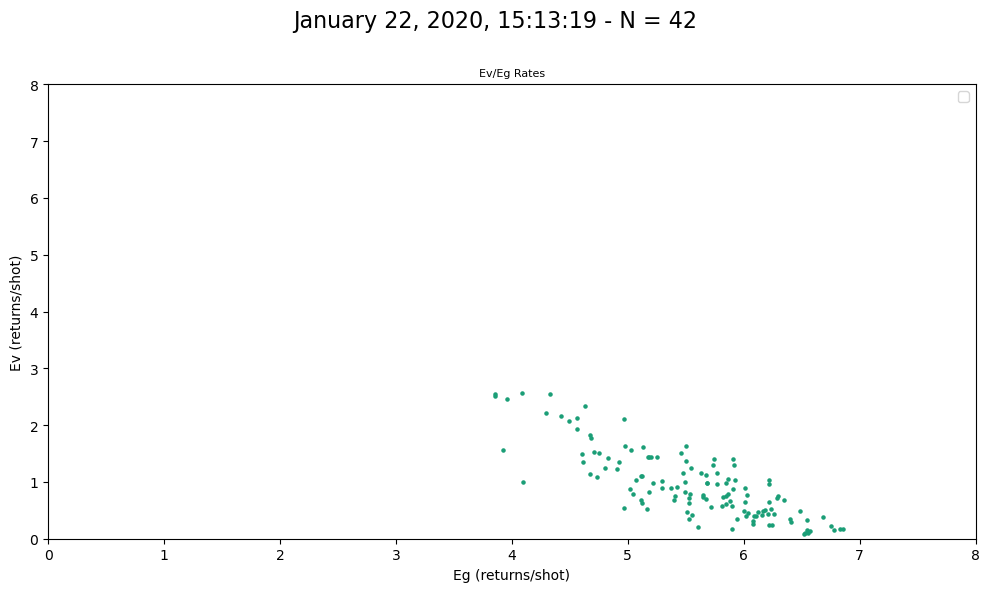

In [10]:
# from scripts.parallel import *

# dirpath = 'R:/data/sodankyla_full/'
dirpath = '../data_store/data/sodankyla_full/'

# data = []

all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

coords = (26.634154, 67.361833)

# problematic: 9, 11, 15, 28, 39??, 42?, 47??, 57?, 64

# for i in range(N):
for i in [42]:
    data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
                         graph_detail=1, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1, altitude=185, beam=[1])
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
    #                      graph_detail=1, loss='linear',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1, altitude=185)
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
    #                      graph_detail=2, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.01, altitude=185)
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
    #                      graph_detail=2, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.001, altitude=185)
S

# Delta Junction

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 0 has insufficient data.
Beam 2 in file 0 has insufficient data.
Beam 3 in file 0 has insufficient data.
Beam 4 in file 0 has insufficient data.
Beam 5 in file 0 has insufficient data.
Beam 6 in file 0 has insufficient data.
No beams have data in file 0, cannot regress.
Beam 1 in file 1 has insufficient data.
Beam 2 in file 1 has insufficient data.
Beam 3 in file 1 has insufficient data.
Beam 4 in file 1 has insufficient data.
Beam 5 in file 1 has insufficient data.
Beam 6 in file 1 has insufficient data.
No beams have data in file 1, cannot regress.
Beam 4 in file 2 has insufficient data.
Beam 6 in file 2 has insufficient data.


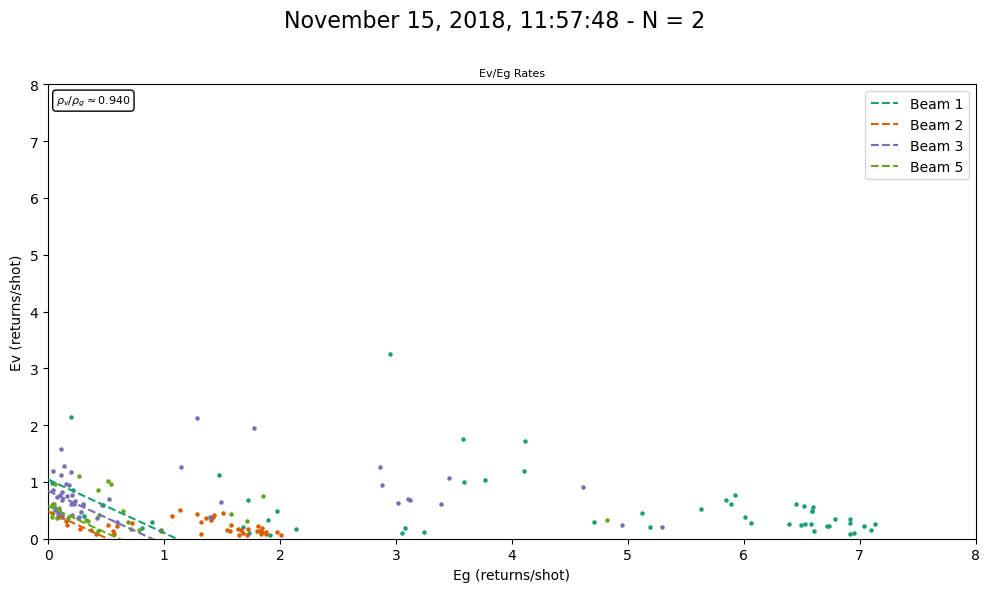

Beam 1 in file 3 has insufficient data.
Beam 2 in file 3 has insufficient data.
Beam 3 in file 3 has insufficient data.
Beam 4 in file 3 has insufficient data.
Beam 5 in file 3 has insufficient data.
Beam 6 in file 3 has insufficient data.
No beams have data in file 3, cannot regress.
Beam 1 in file 4 has insufficient data.
Beam 2 in file 4 has insufficient data.
Beam 4 in file 4 has insufficient data.


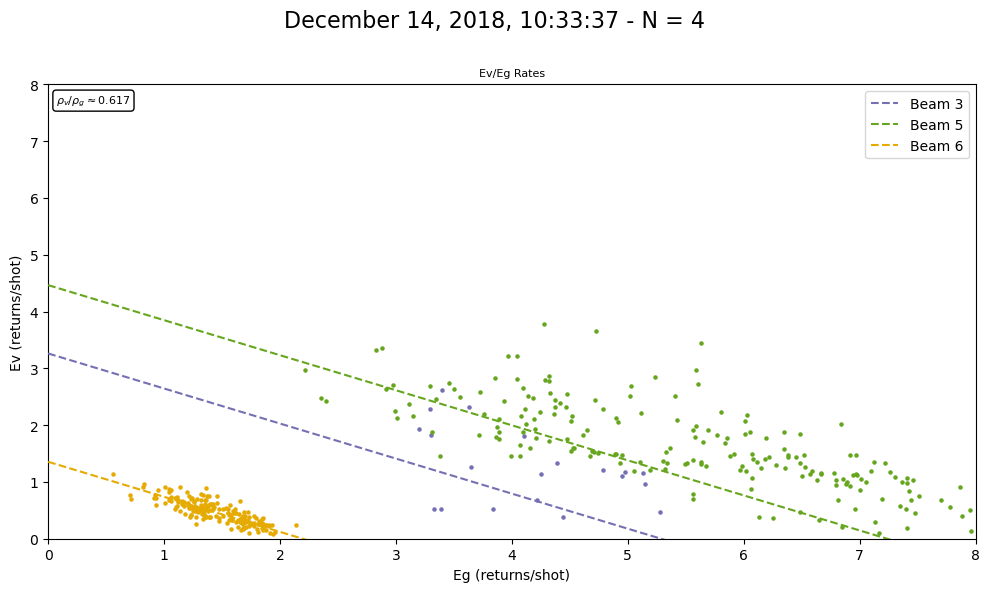

Beam 1 in file 5 has insufficient data.
Beam 2 in file 5 has insufficient data.
Beam 3 in file 5 has insufficient data.
Beam 4 in file 5 has insufficient data.
Beam 5 in file 5 has insufficient data.
Beam 6 in file 5 has insufficient data.
No beams have data in file 5, cannot regress.
Beam 1 in file 6 has insufficient data.
Beam 2 in file 6 has insufficient data.
Beam 3 in file 6 has insufficient data.
Beam 4 in file 6 has insufficient data.
Beam 5 in file 6 has insufficient data.
Beam 6 in file 6 has insufficient data.
No beams have data in file 6, cannot regress.
Beam 5 in file 7 has insufficient data.
Beam 6 in file 7 has insufficient data.


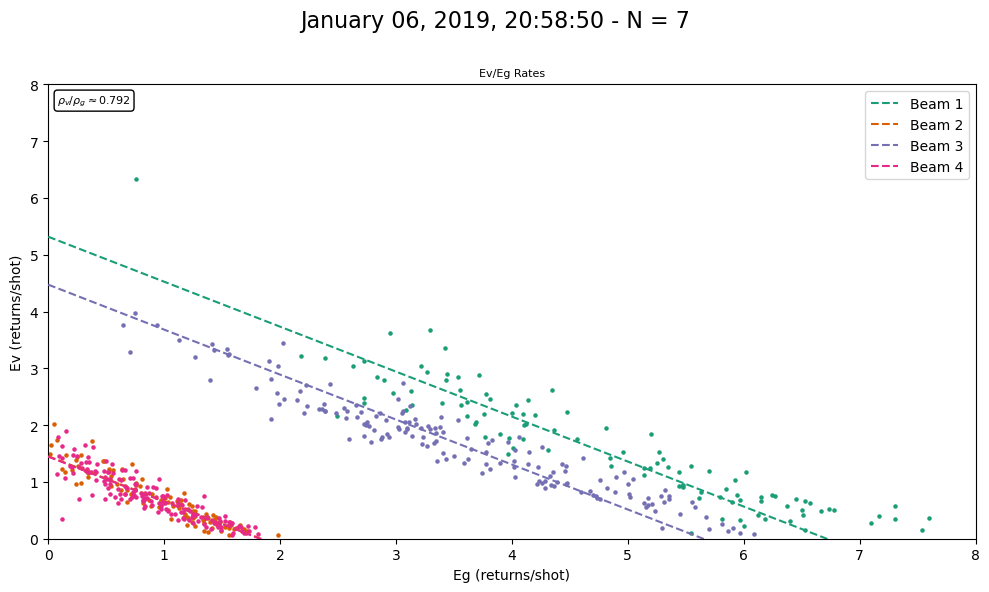

Beam 1 in file 8 has insufficient data.
Beam 2 in file 8 has insufficient data.
Beam 3 in file 8 has insufficient data.
Beam 4 in file 8 has insufficient data.
Beam 5 in file 8 has insufficient data.
Beam 6 in file 8 has insufficient data.
No beams have data in file 8, cannot regress.
Beam 1 in file 9 has insufficient data.
Beam 2 in file 9 has insufficient data.


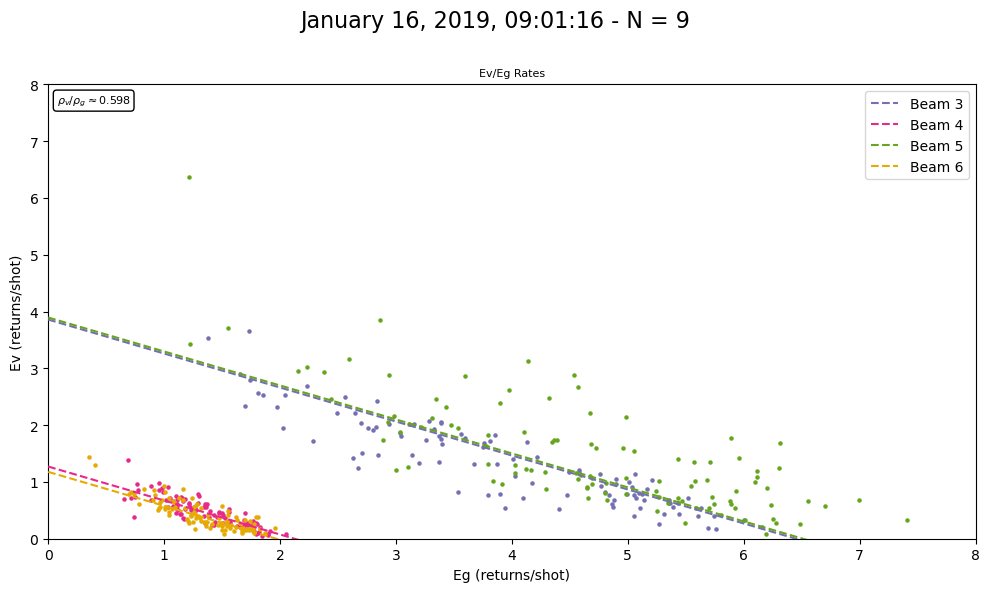

Beam 1 in file 10 has insufficient data.
Beam 2 in file 10 has insufficient data.
Beam 3 in file 10 has insufficient data.
Beam 4 in file 10 has insufficient data.
Beam 5 in file 10 has insufficient data.
Beam 6 in file 10 has insufficient data.
No beams have data in file 10, cannot regress.
Beam 1 in file 11 has insufficient data.
Beam 2 in file 11 has insufficient data.
Beam 3 in file 11 has insufficient data.
Beam 4 in file 11 has insufficient data.
Beam 5 in file 11 has insufficient data.
Beam 6 in file 11 has insufficient data.
No beams have data in file 11, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 12 has insufficient data.
Beam 2 in file 12 has insufficient data.
Beam 3 in file 12 has insufficient data.
Beam 4 in file 12 has insufficient data.


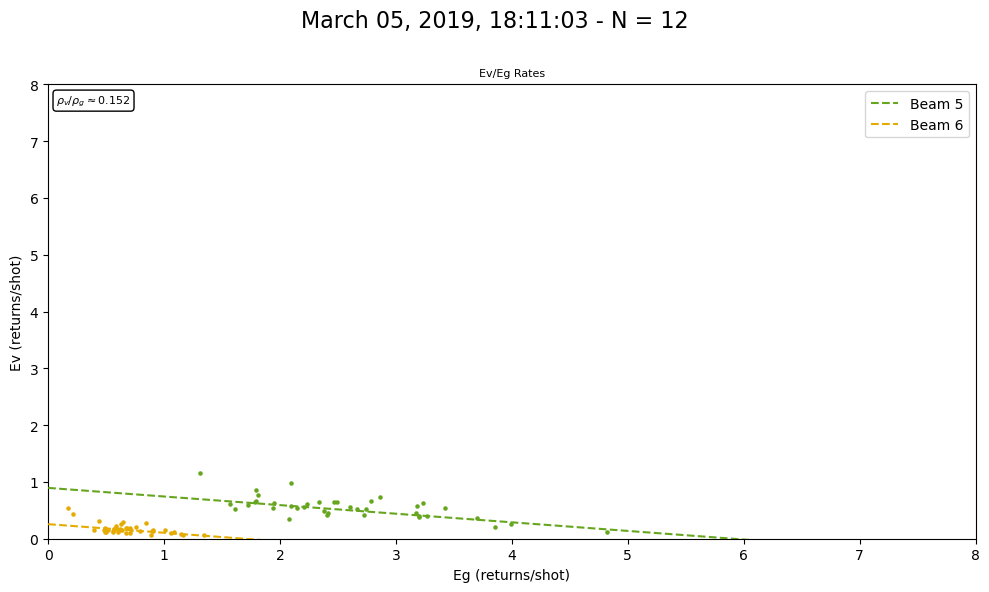

Beam 1 in file 13 has insufficient data.
Beam 2 in file 13 has insufficient data.
Beam 3 in file 13 has insufficient data.
Beam 4 in file 13 has insufficient data.
Beam 5 in file 13 has insufficient data.
Beam 6 in file 13 has insufficient data.
No beams have data in file 13, cannot regress.
Beam 3 in file 14 has insufficient data.
Beam 4 in file 14 has insufficient data.
Beam 5 in file 14 has insufficient data.
Beam 6 in file 14 has insufficient data.


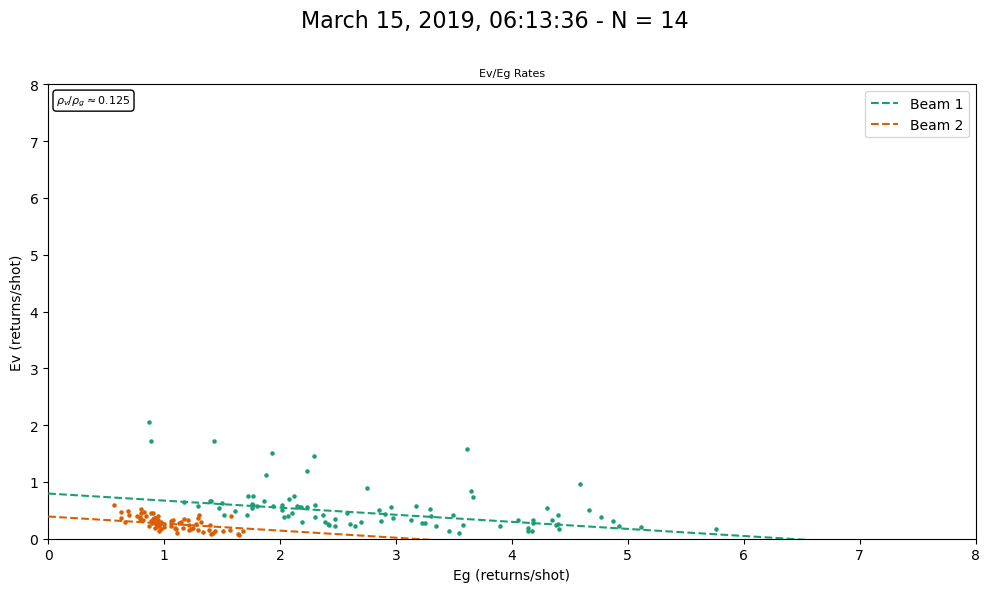

Beam 1 in file 15 has insufficient data.
Beam 2 in file 15 has insufficient data.
Beam 3 in file 15 has insufficient data.
Beam 4 in file 15 has insufficient data.
Beam 5 in file 15 has insufficient data.
Beam 6 in file 15 has insufficient data.
No beams have data in file 15, cannot regress.
Beam 5 in file 16 has insufficient data.
Beam 6 in file 16 has insufficient data.


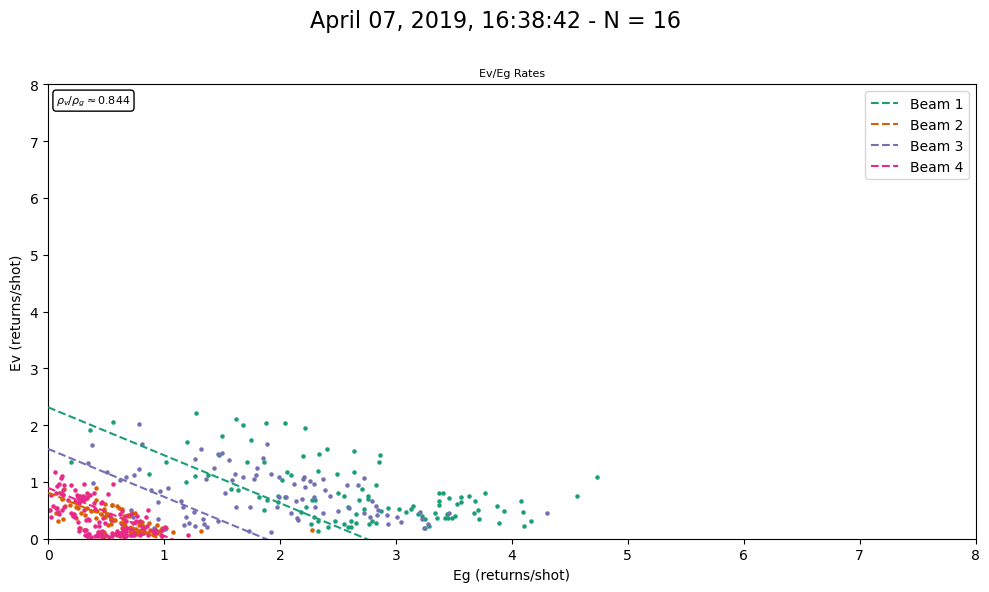

Beam 1 in file 17 has insufficient data.
Beam 2 in file 17 has insufficient data.
Beam 3 in file 17 has insufficient data.
Beam 4 in file 17 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 17 has insufficient data.
Beam 6 in file 17 has insufficient data.
No beams have data in file 17, cannot regress.
Beam 1 in file 18 has insufficient data.
Beam 2 in file 18 has insufficient data.
Beam 3 in file 18 has insufficient data.
Beam 4 in file 18 has insufficient data.
Beam 5 in file 18 has insufficient data.
Beam 6 in file 18 has insufficient data.
No beams have data in file 18, cannot regress.
Beam 2 in file 19 has insufficient data.
Beam 4 in file 19 has insufficient data.
Beam 6 in file 19 has insufficient data.


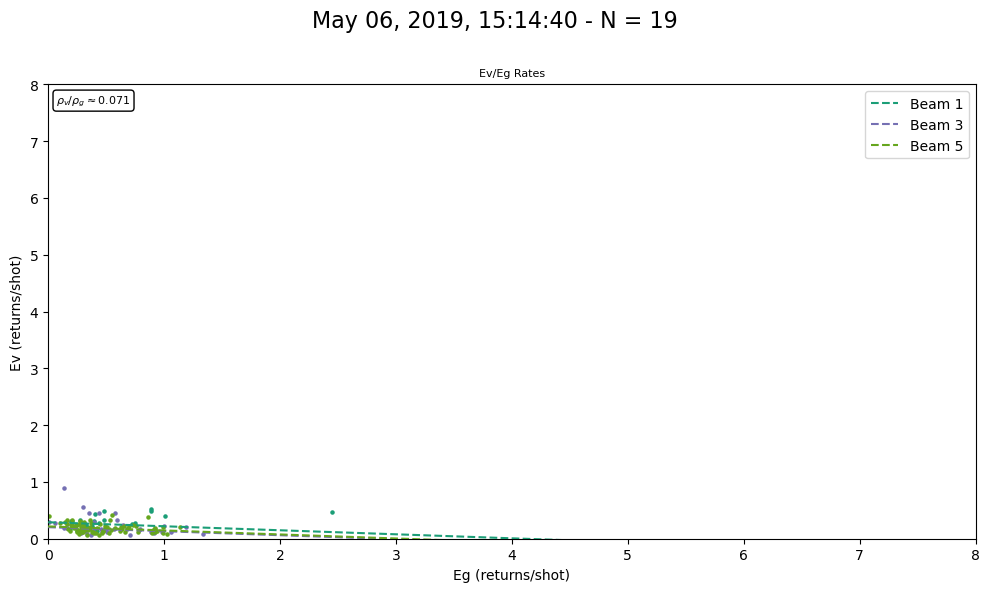

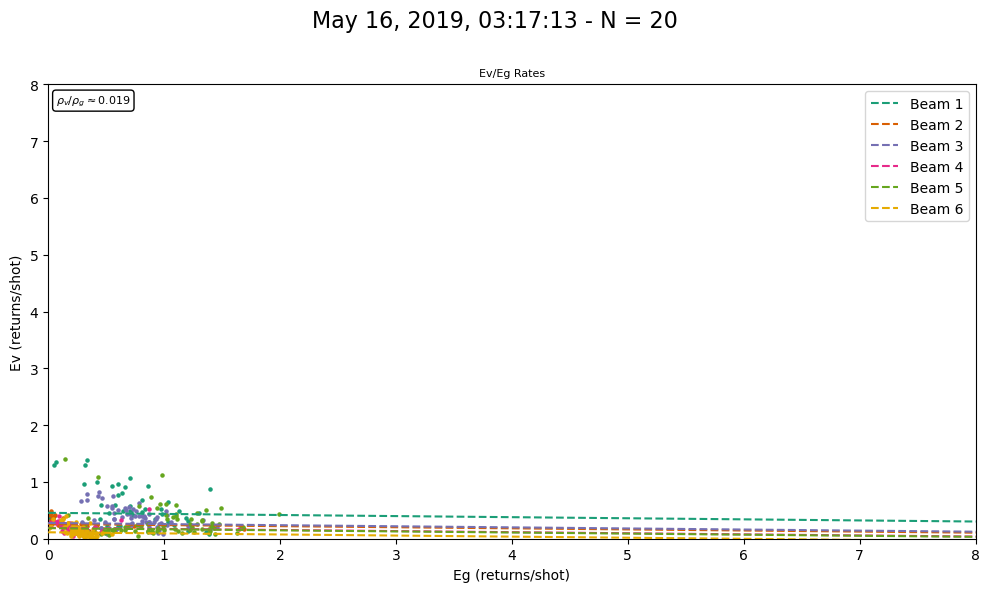

Beam 1 in file 21 has insufficient data.
Beam 2 in file 21 has insufficient data.
Beam 3 in file 21 has insufficient data.
Beam 4 in file 21 has insufficient data.
Beam 5 in file 21 has insufficient data.
Beam 6 in file 21 has insufficient data.
No beams have data in file 21, cannot regress.
Beam 1 in file 22 has insufficient data.
Beam 2 in file 22 has insufficient data.
Beam 3 in file 22 has insufficient data.
Beam 4 in file 22 has insufficient data.
Beam 5 in file 22 has insufficient data.
Beam 6 in file 22 has insufficient data.
No beams have data in file 22, cannot regress.
Beam 1 in file 23 has insufficient data.
Beam 2 in file 23 has insufficient data.
Beam 3 in file 23 has insufficient data.
Beam 4 in file 23 has insufficient data.
Beam 5 in file 23 has insufficient data.
Beam 6 in file 23 has insufficient data.
No beams have data in file 23, cannot regress.
Beam 1 in file 24 has insufficient data.
Beam 2 in file 24 has insufficient data.
Beam 3 in file 24 has insufficient data

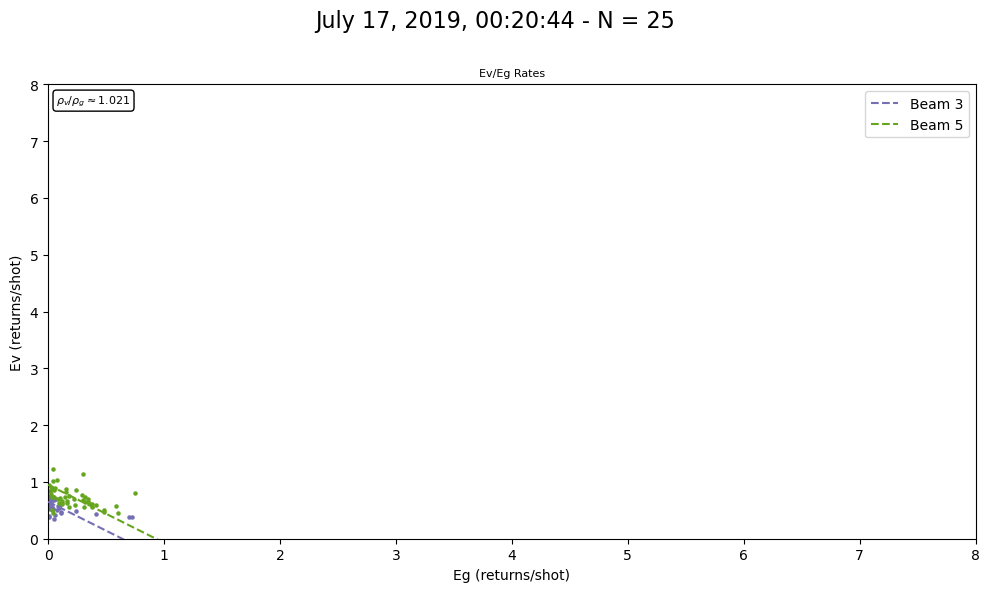

Beam 1 in file 26 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 2 in file 26 has insufficient data.
Beam 3 in file 26 has insufficient data.
Beam 4 in file 26 has insufficient data.
Beam 5 in file 26 has insufficient data.
Beam 6 in file 26 has insufficient data.
No beams have data in file 26, cannot regress.
Beam 1 in file 27 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 2 in file 27 has insufficient data.
Beam 3 in file 27 has insufficient data.
Beam 4 in file 27 has insufficient data.
Beam 5 in file 27 has insufficient data.
Beam 6 in file 27 has insufficient data.
No beams have data in file 27, cannot regress.
Beam 1 in file 28 has insufficient data.
Beam 2 in file 28 has insufficient data.


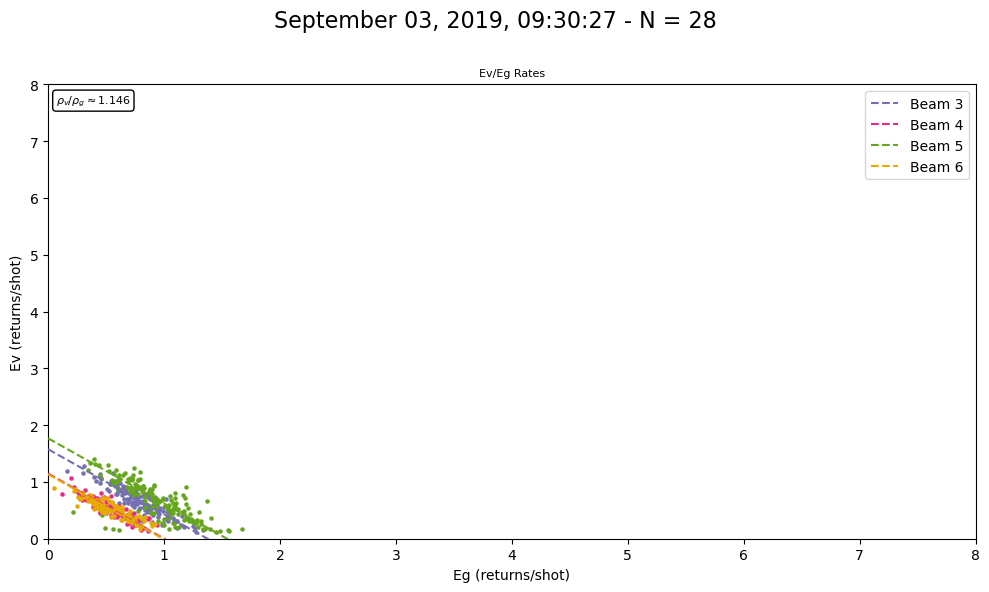

Beam 1 in file 29 has insufficient data.
Beam 2 in file 29 has insufficient data.
Beam 3 in file 29 has insufficient data.
Beam 4 in file 29 has insufficient data.
Beam 5 in file 29 has insufficient data.
Beam 6 in file 29 has insufficient data.
No beams have data in file 29, cannot regress.
Beam 6 in file 30 has insufficient data.


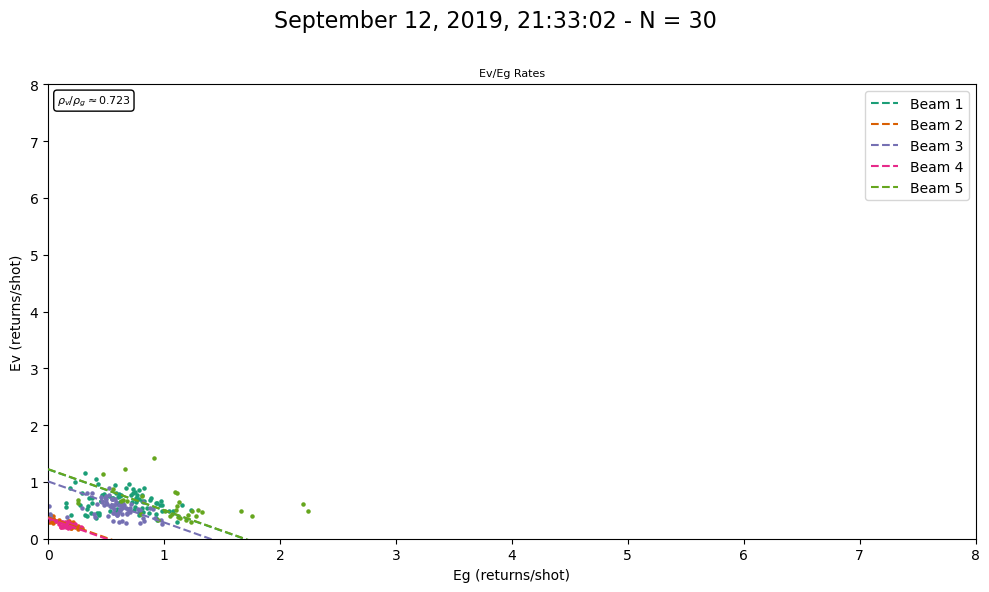

Beam 1 in file 31 has insufficient data.
Beam 2 in file 31 has insufficient data.
Beam 3 in file 31 has insufficient data.
Beam 4 in file 31 has insufficient data.
Beam 5 in file 31 has insufficient data.
Beam 6 in file 31 has insufficient data.
No beams have data in file 31, cannot regress.
Beam 1 in file 32 has insufficient data.
Beam 2 in file 32 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 32 has insufficient data.
Beam 4 in file 32 has insufficient data.
Beam 5 in file 32 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 32 has insufficient data.
No beams have data in file 32, cannot regress.
Beam 1 in file 33 has insufficient data.
Beam 2 in file 33 has insufficient data.
Beam 3 in file 33 has insufficient data.
Beam 4 in file 33 has insufficient data.
Beam 5 in file 33 has insufficient data.
Beam 6 in file 33 has insufficient data.
No beams have data in file 33, cannot regress.
Beam 1 in file 34 has insufficient data.
Beam 2 in file 34 has insufficient data.
Beam 3 in file 34 has insufficient data.
Beam 4 in file 34 has insufficient data.
Beam 5 in file 34 has insufficient data.
Beam 6 in file 34 has insufficient data.
No beams have data in file 34, cannot regress.
Beam 2 in file 35 has insufficient data.
Beam 3 in file 35 has insufficient data.
Beam 4 in file 35 has insufficient data.
Beam 5 in file 35 has insufficient data.
Beam 6 in file 35 has insufficient data.


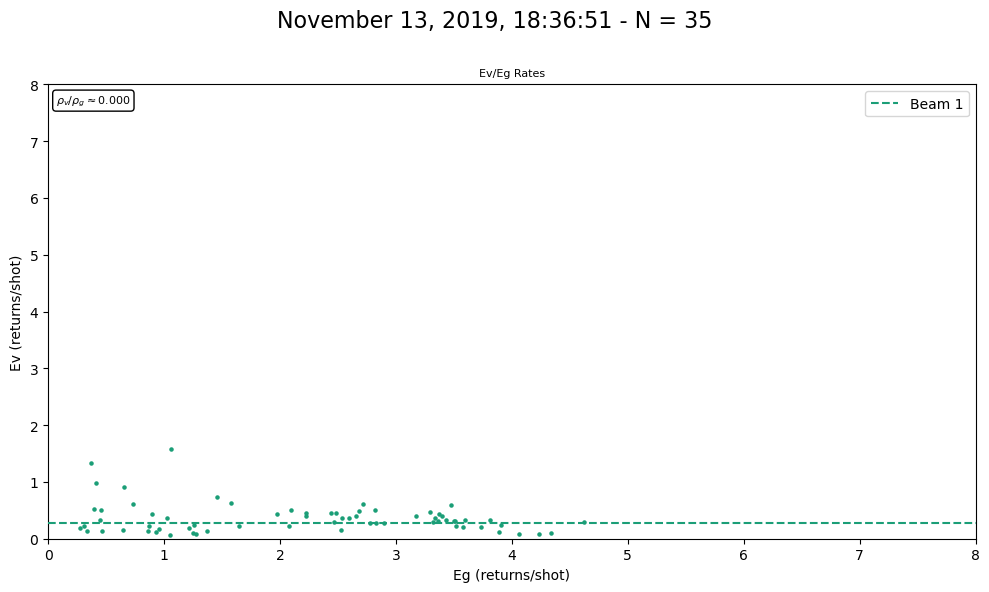

Beam 1 in file 36 has insufficient data.
Beam 2 in file 36 has insufficient data.
Beam 3 in file 36 has insufficient data.
Beam 4 in file 36 has insufficient data.
Beam 5 in file 36 has insufficient data.
Beam 6 in file 36 has insufficient data.
No beams have data in file 36, cannot regress.
Beam 1 in file 37 has insufficient data.
Beam 2 in file 37 has insufficient data.
Beam 3 in file 37 has insufficient data.
Beam 4 in file 37 has insufficient data.
Beam 5 in file 37 has insufficient data.
Beam 6 in file 37 has insufficient data.
No beams have data in file 37, cannot regress.
Beam 1 in file 38 has insufficient data.
Beam 2 in file 38 has insufficient data.
Beam 3 in file 38 has insufficient data.
Beam 4 in file 38 has insufficient data.
Beam 5 in file 38 has insufficient data.
Beam 6 in file 38 has insufficient data.
No beams have data in file 38, cannot regress.
Beam 1 in file 39 has insufficient data.
Beam 2 in file 39 has insufficient data.
Beam 3 in file 39 has insufficient data

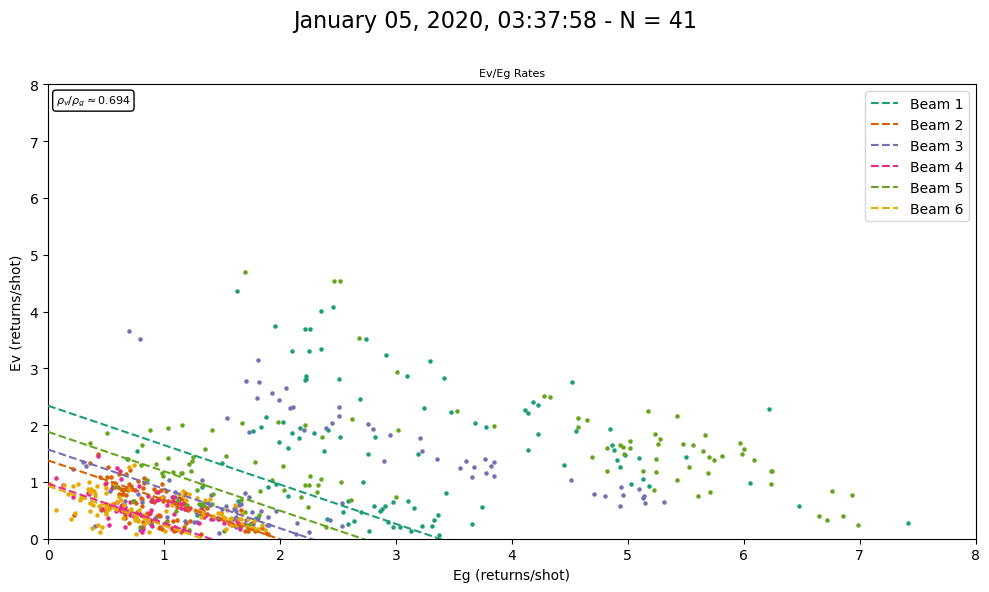

Beam 1 in file 42 has insufficient data.
Beam 2 in file 42 has insufficient data.
Beam 3 in file 42 has insufficient data.
Beam 4 in file 42 has insufficient data.
Beam 5 in file 42 has insufficient data.
Beam 6 in file 42 has insufficient data.
No beams have data in file 42, cannot regress.
Beam 1 in file 43 has insufficient data.
Beam 2 in file 43 has insufficient data.
Beam 3 in file 43 has insufficient data.
Beam 4 in file 43 has insufficient data.
Beam 5 in file 43 has insufficient data.
Beam 6 in file 43 has insufficient data.
No beams have data in file 43, cannot regress.
Beam 1 in file 44 has insufficient data.
Beam 2 in file 44 has insufficient data.
Beam 3 in file 44 has insufficient data.
Beam 4 in file 44 has insufficient data.
Beam 5 in file 44 has insufficient data.
Beam 6 in file 44 has insufficient data.
No beams have data in file 44, cannot regress.
Beam 1 in file 45 has insufficient data.
Beam 2 in file 45 has insufficient data.
Beam 3 in file 45 has insufficient data

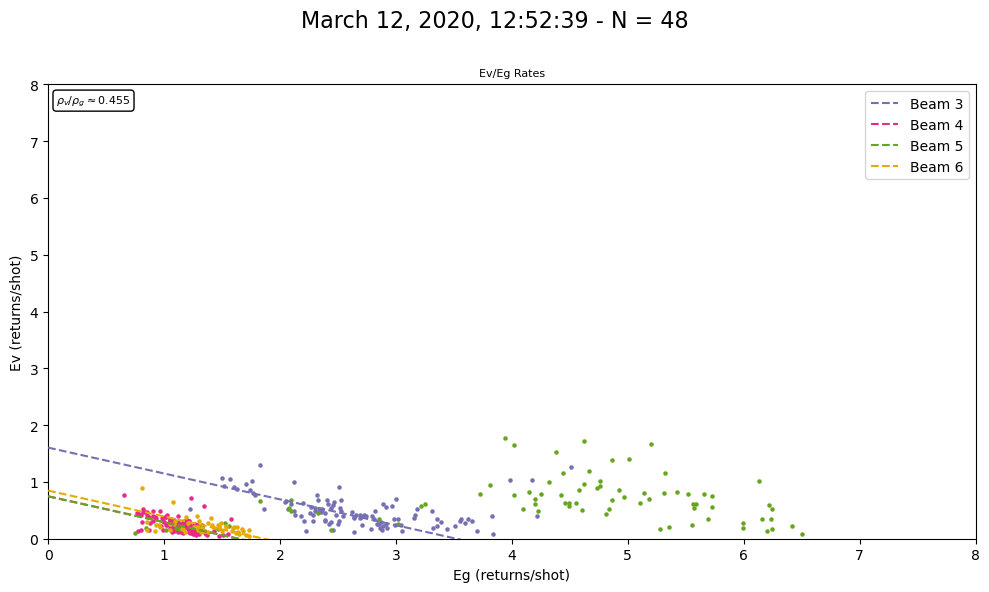

Beam 1 in file 49 has insufficient data.
Beam 2 in file 49 has insufficient data.
Beam 3 in file 49 has insufficient data.
Beam 4 in file 49 has insufficient data.
Beam 5 in file 49 has insufficient data.
Beam 6 in file 49 has insufficient data.
No beams have data in file 49, cannot regress.
Beam 1 in file 50 has insufficient data.
Beam 2 in file 50 has insufficient data.
Beam 3 in file 50 has insufficient data.
Beam 4 in file 50 has insufficient data.
Beam 5 in file 50 has insufficient data.
Beam 6 in file 50 has insufficient data.
No beams have data in file 50, cannot regress.
Beam 1 in file 51 has insufficient data.
Beam 2 in file 51 has insufficient data.
Beam 3 in file 51 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 51 has insufficient data.
Beam 5 in file 51 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 51 has insufficient data.
No beams have data in file 51, cannot regress.
Beam 1 in file 52 has insufficient data.
Beam 2 in file 52 has insufficient data.
Beam 3 in file 52 has insufficient data.
Beam 4 in file 52 has insufficient data.
Beam 5 in file 52 has insufficient data.
Beam 6 in file 52 has insufficient data.
No beams have data in file 52, cannot regress.
Beam 5 in file 53 has insufficient data.
Beam 6 in file 53 has insufficient data.


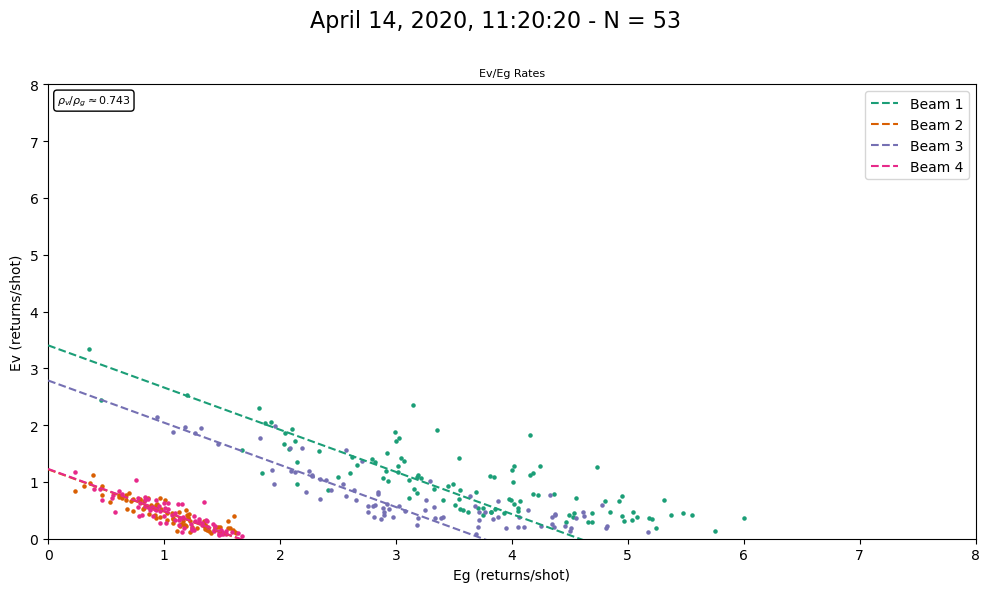

Beam 4 in file 54 has insufficient data.
Beam 6 in file 54 has insufficient data.


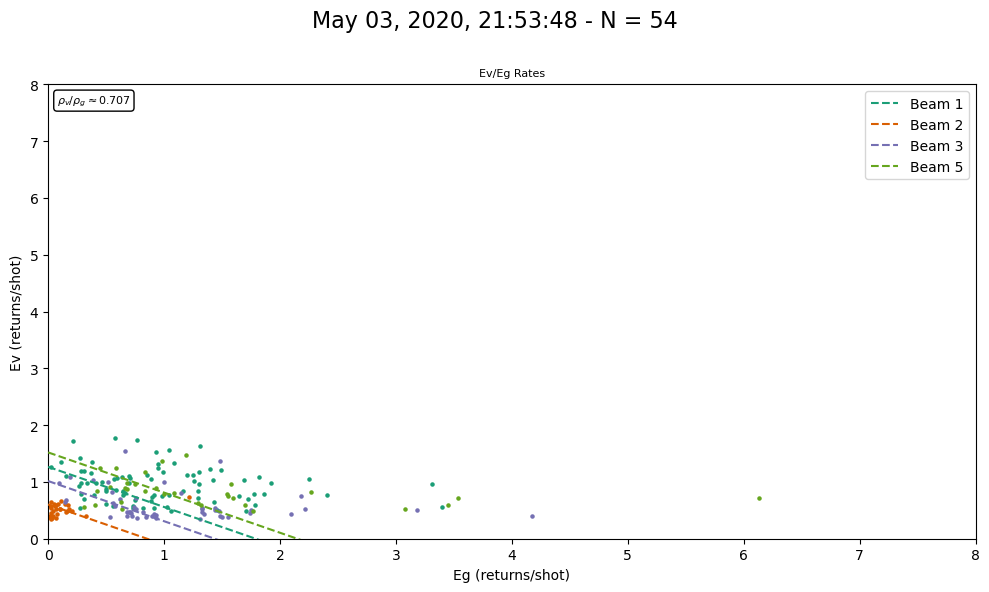

Beam 4 in file 55 has insufficient data.
Beam 6 in file 55 has insufficient data.


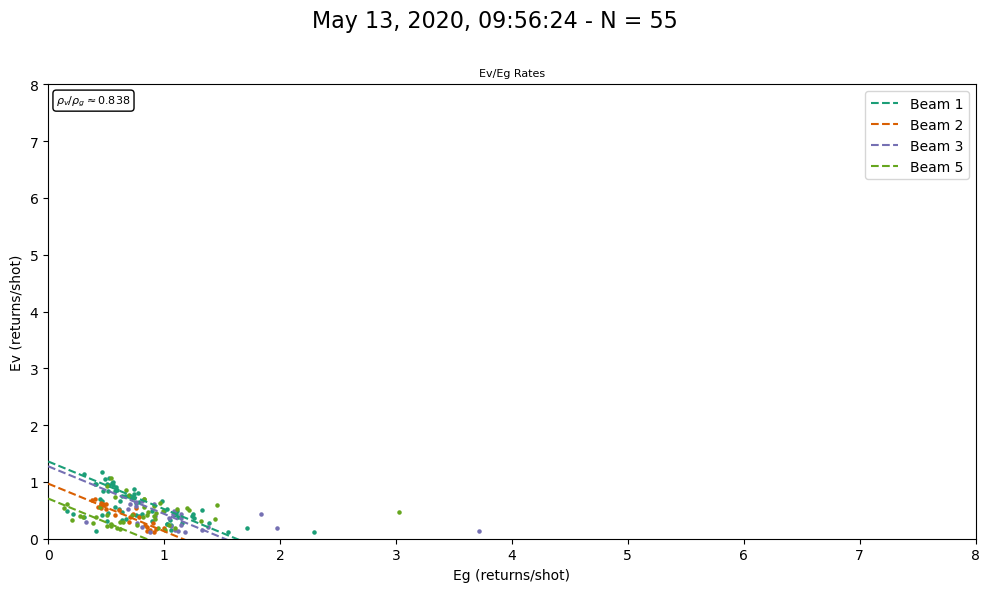

Beam 1 in file 56 has insufficient data.
Beam 2 in file 56 has insufficient data.
Beam 3 in file 56 has insufficient data.
Beam 4 in file 56 has insufficient data.


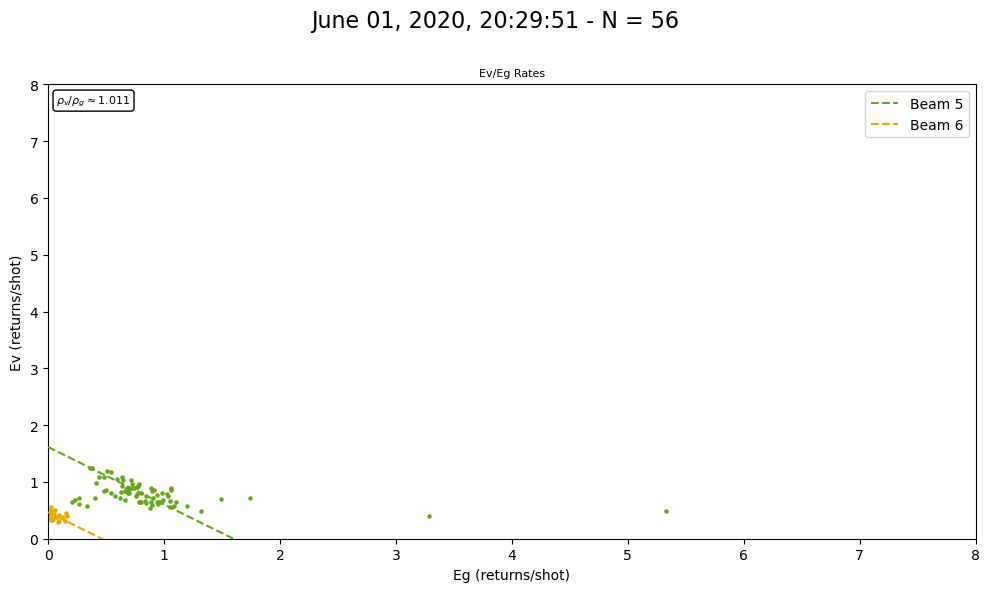

Beam 1 in file 57 has insufficient data.
Beam 2 in file 57 has insufficient data.
Beam 3 in file 57 has insufficient data.
Beam 4 in file 57 has insufficient data.
Beam 5 in file 57 has insufficient data.
Beam 6 in file 57 has insufficient data.
No beams have data in file 57, cannot regress.
Beam 1 in file 58 has insufficient data.
Beam 2 in file 58 has insufficient data.
Beam 3 in file 58 has insufficient data.
Beam 4 in file 58 has insufficient data.
Beam 5 in file 58 has insufficient data.
Beam 6 in file 58 has insufficient data.
No beams have data in file 58, cannot regress.
Beam 1 in file 59 has insufficient data.
Beam 2 in file 59 has insufficient data.
Beam 3 in file 59 has insufficient data.
Beam 4 in file 59 has insufficient data.
Beam 5 in file 59 has insufficient data.
Beam 6 in file 59 has insufficient data.
No beams have data in file 59, cannot regress.
Beam 1 in file 60 has insufficient data.
Beam 2 in file 60 has insufficient data.
Beam 3 in file 60 has insufficient data

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 60 has insufficient data.
Beam 6 in file 60 has insufficient data.
No beams have data in file 60, cannot regress.
Beam 6 in file 61 has insufficient data.


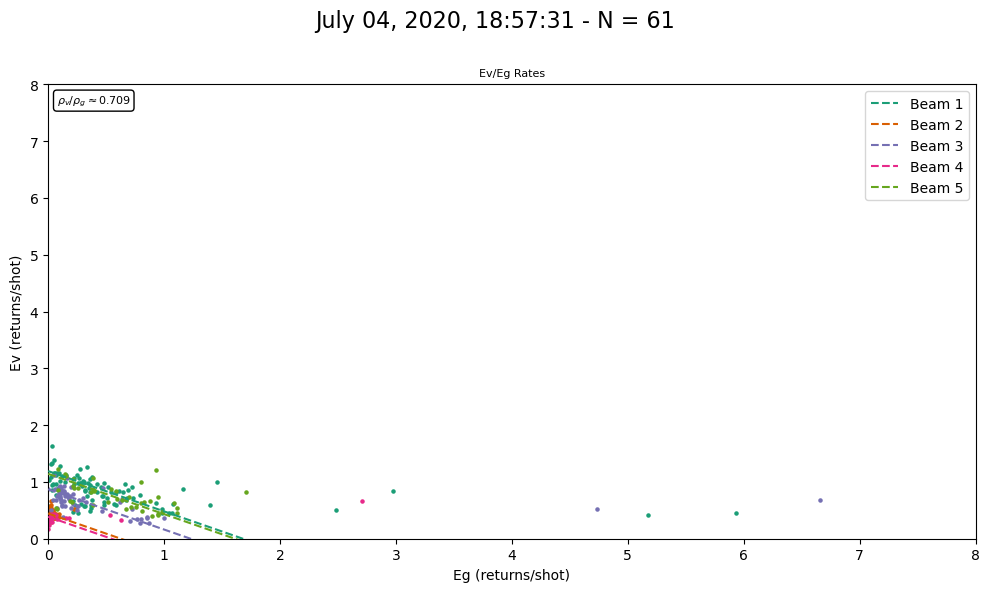

Beam 1 in file 62 has insufficient data.
Beam 2 in file 62 has insufficient data.
Beam 3 in file 62 has insufficient data.
Beam 4 in file 62 has insufficient data.
Beam 5 in file 62 has insufficient data.
Beam 6 in file 62 has insufficient data.
No beams have data in file 62, cannot regress.
Beam 1 in file 63 has insufficient data.
Beam 2 in file 63 has insufficient data.
Beam 3 in file 63 has insufficient data.
Beam 4 in file 63 has insufficient data.
Beam 5 in file 63 has insufficient data.
Beam 6 in file 63 has insufficient data.
No beams have data in file 63, cannot regress.
Beam 1 in file 64 has insufficient data.
Beam 2 in file 64 has insufficient data.
Beam 3 in file 64 has insufficient data.
Beam 4 in file 64 has insufficient data.
Beam 5 in file 64 has insufficient data.
Beam 6 in file 64 has insufficient data.
No beams have data in file 64, cannot regress.
Beam 2 in file 65 has insufficient data.
Beam 3 in file 65 has insufficient data.
Beam 4 in file 65 has insufficient data

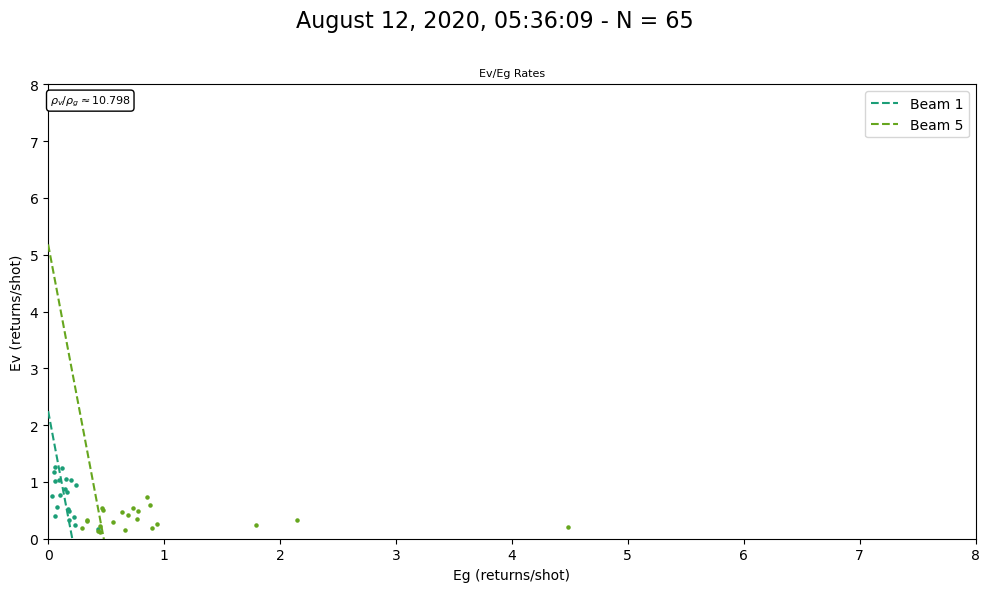

Beam 1 in file 66 has insufficient data.
Beam 2 in file 66 has insufficient data.
Beam 3 in file 66 has insufficient data.
Beam 4 in file 66 has insufficient data.
Beam 5 in file 66 has insufficient data.
Beam 6 in file 66 has insufficient data.
No beams have data in file 66, cannot regress.
Beam 1 in file 67 has insufficient data.
Beam 2 in file 67 has insufficient data.
Beam 3 in file 67 has insufficient data.
Beam 4 in file 67 has insufficient data.
Beam 5 in file 67 has insufficient data.
Beam 6 in file 67 has insufficient data.
No beams have data in file 67, cannot regress.
Beam 1 in file 68 has insufficient data.
Beam 2 in file 68 has insufficient data.
Beam 3 in file 68 has insufficient data.
Beam 4 in file 68 has insufficient data.
Beam 5 in file 68 has insufficient data.
Beam 6 in file 68 has insufficient data.
No beams have data in file 68, cannot regress.
Beam 1 in file 69 has insufficient data.
Beam 2 in file 69 has insufficient data.
Beam 3 in file 69 has insufficient data

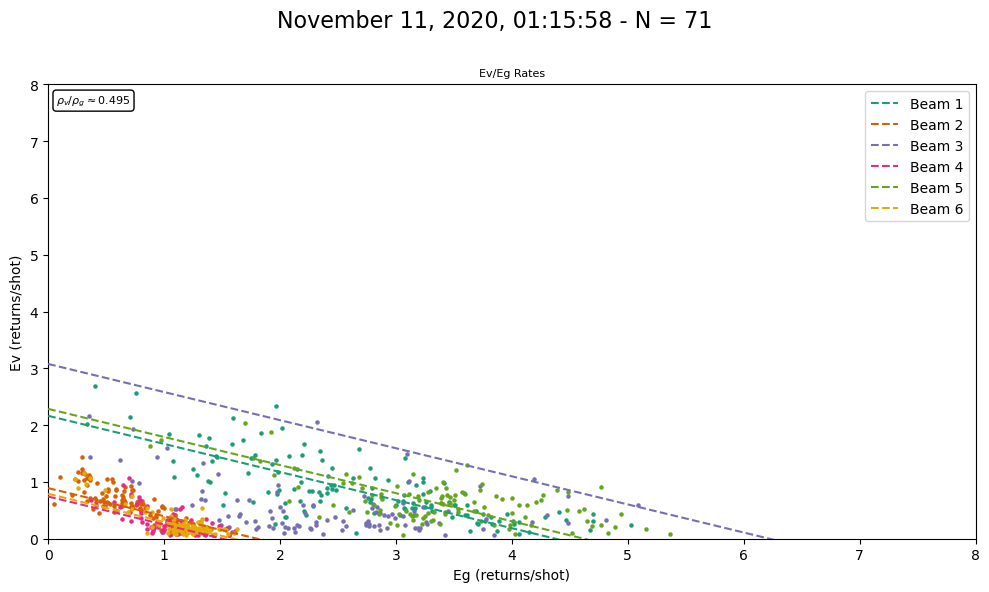

Beam 1 in file 72 has insufficient data.
Beam 2 in file 72 has insufficient data.
Beam 3 in file 72 has insufficient data.
Beam 4 in file 72 has insufficient data.


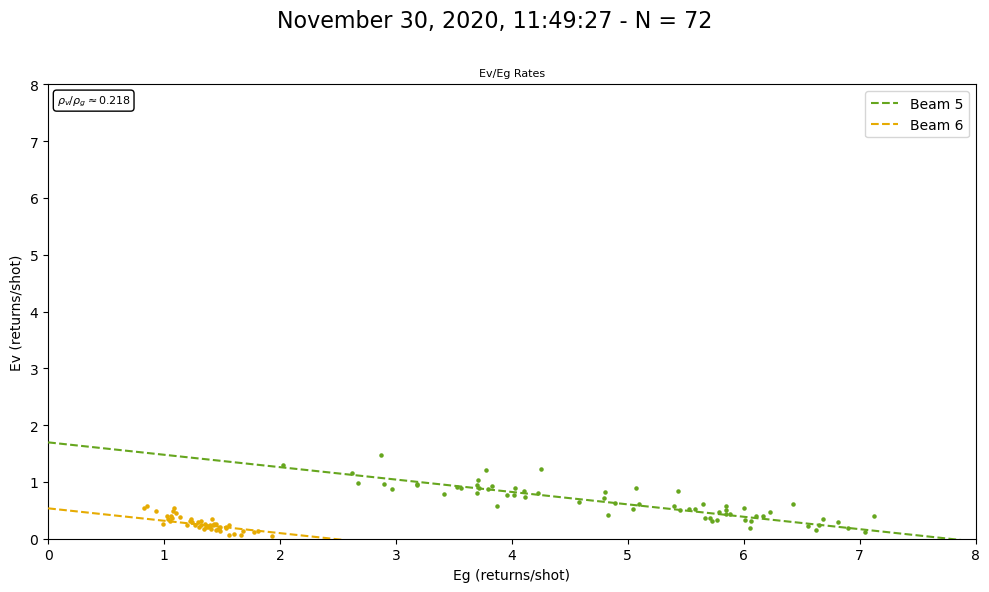

Beam 1 in file 73 has insufficient data.
Beam 2 in file 73 has insufficient data.
Beam 3 in file 73 has insufficient data.
Beam 4 in file 73 has insufficient data.
Beam 5 in file 73 has insufficient data.
Beam 6 in file 73 has insufficient data.
No beams have data in file 73, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 74 has insufficient data.
Beam 2 in file 74 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 74 has insufficient data.
Beam 4 in file 74 has insufficient data.
Beam 5 in file 74 has insufficient data.
Beam 6 in file 74 has insufficient data.
No beams have data in file 74, cannot regress.
Beam 1 in file 75 has insufficient data.
Beam 2 in file 75 has insufficient data.
Beam 3 in file 75 has insufficient data.
Beam 4 in file 75 has insufficient data.
Beam 5 in file 75 has insufficient data.
Beam 6 in file 75 has insufficient data.
No beams have data in file 75, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


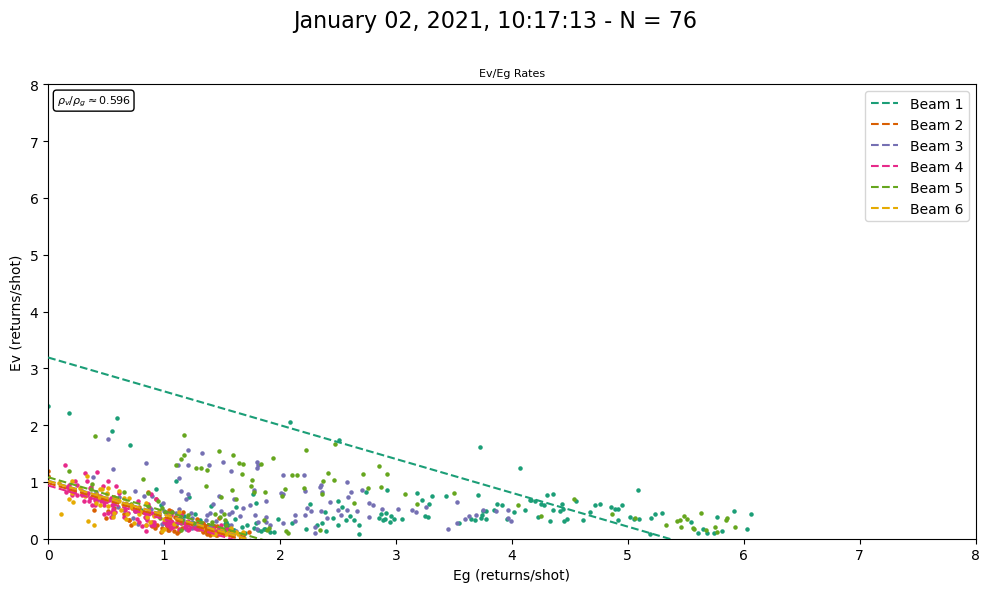

Beam 1 in file 77 has insufficient data.
Beam 2 in file 77 has insufficient data.
Beam 3 in file 77 has insufficient data.
Beam 4 in file 77 has insufficient data.
Beam 5 in file 77 has insufficient data.
Beam 6 in file 77 has insufficient data.
No beams have data in file 77, cannot regress.
Beam 1 in file 78 has insufficient data.
Beam 2 in file 78 has insufficient data.
Beam 3 in file 78 has insufficient data.
Beam 4 in file 78 has insufficient data.
Beam 5 in file 78 has insufficient data.
Beam 6 in file 78 has insufficient data.
No beams have data in file 78, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 79 has insufficient data.
Beam 2 in file 79 has insufficient data.
Beam 3 in file 79 has insufficient data.
Beam 4 in file 79 has insufficient data.
Beam 5 in file 79 has insufficient data.
Beam 6 in file 79 has insufficient data.
No beams have data in file 79, cannot regress.
Beam 1 in file 80 has insufficient data.
Beam 2 in file 80 has insufficient data.
Beam 3 in file 80 has insufficient data.
Beam 4 in file 80 has insufficient data.
Beam 5 in file 80 has insufficient data.
Beam 6 in file 80 has insufficient data.
No beams have data in file 80, cannot regress.
Beam 1 in file 81 has insufficient data.
Beam 2 in file 81 has insufficient data.
Beam 3 in file 81 has insufficient data.
Beam 4 in file 81 has insufficient data.
Beam 5 in file 81 has insufficient data.
Beam 6 in file 81 has insufficient data.
No beams have data in file 81, cannot regress.


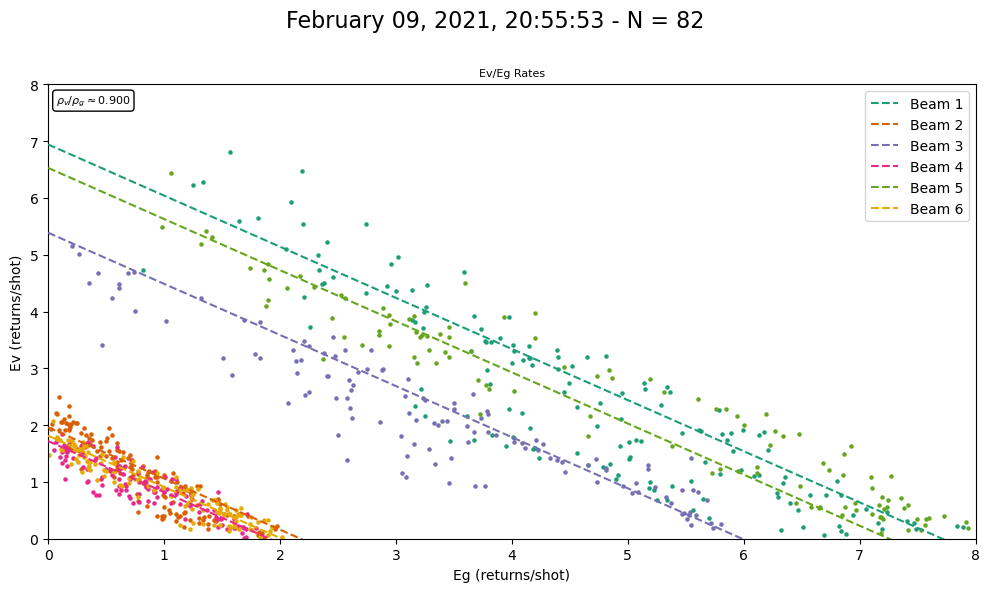

Beam 1 in file 83 has insufficient data.
Beam 2 in file 83 has insufficient data.
Beam 3 in file 83 has insufficient data.
Beam 4 in file 83 has insufficient data.
Beam 5 in file 83 has insufficient data.
Beam 6 in file 83 has insufficient data.
No beams have data in file 83, cannot regress.
Beam 1 in file 84 has insufficient data.
Beam 2 in file 84 has insufficient data.
Beam 3 in file 84 has insufficient data.
Beam 4 in file 84 has insufficient data.
Beam 5 in file 84 has insufficient data.
Beam 6 in file 84 has insufficient data.
No beams have data in file 84, cannot regress.
Beam 1 in file 85 has insufficient data.
Beam 2 in file 85 has insufficient data.
Beam 3 in file 85 has insufficient data.
Beam 4 in file 85 has insufficient data.
Beam 5 in file 85 has insufficient data.
Beam 6 in file 85 has insufficient data.
No beams have data in file 85, cannot regress.
Beam 1 in file 86 has insufficient data.
Beam 2 in file 86 has insufficient data.
Beam 3 in file 86 has insufficient data

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 87 has insufficient data.
Beam 6 in file 87 has insufficient data.
No beams have data in file 87, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 88 has insufficient data.
Beam 2 in file 88 has insufficient data.
Beam 3 in file 88 has insufficient data.
Beam 4 in file 88 has insufficient data.
Beam 5 in file 88 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 88 has insufficient data.
No beams have data in file 88, cannot regress.
Beam 1 in file 89 has insufficient data.
Beam 2 in file 89 has insufficient data.
Beam 3 in file 89 has insufficient data.
Beam 4 in file 89 has insufficient data.
Beam 5 in file 89 has insufficient data.
Beam 6 in file 89 has insufficient data.
No beams have data in file 89, cannot regress.
Beam 2 in file 90 has insufficient data.
Beam 3 in file 90 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 90 has insufficient data.
Beam 5 in file 90 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 90 has insufficient data.


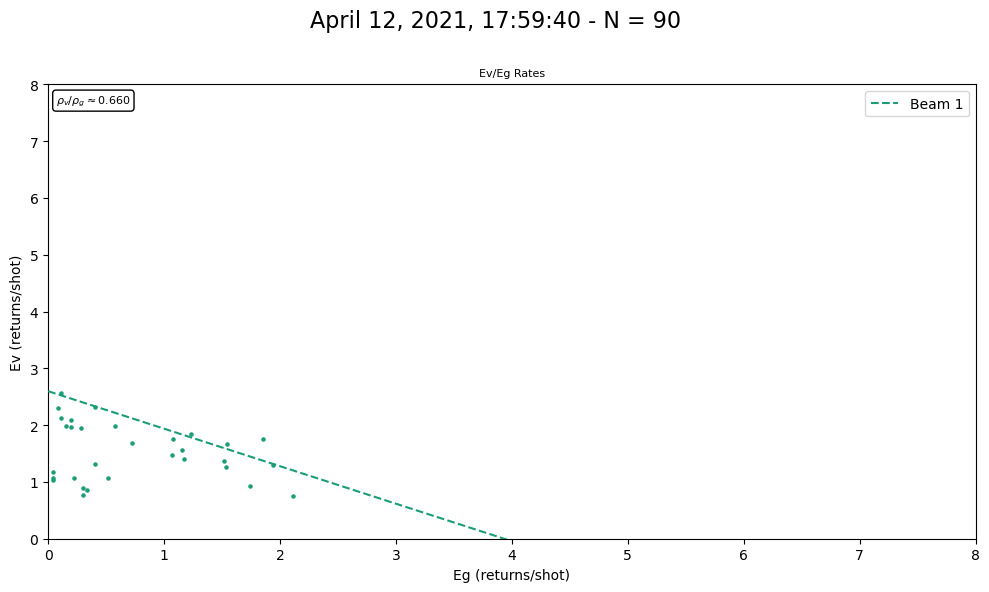

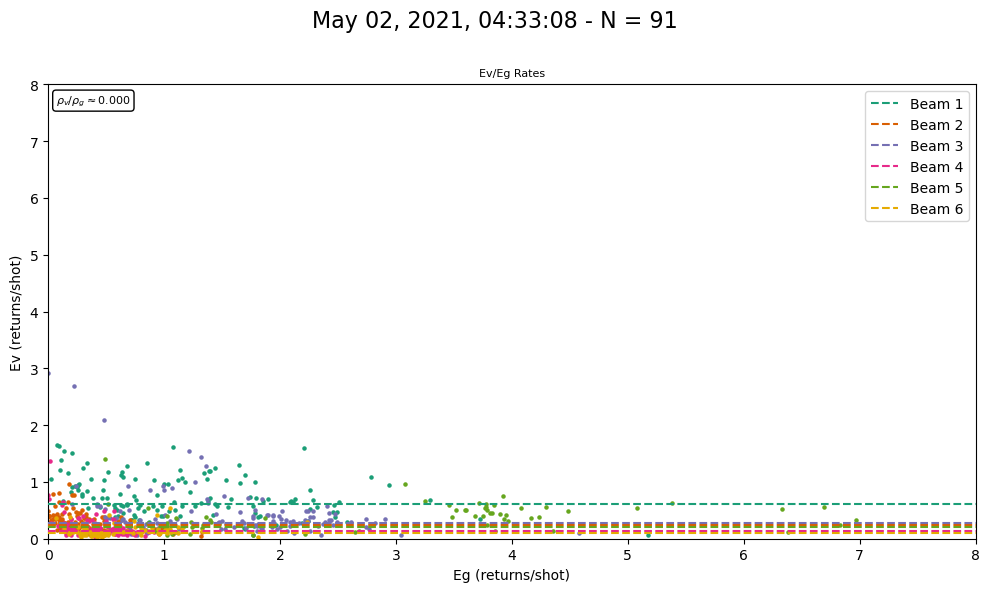

Beam 1 in file 92 has insufficient data.
Beam 2 in file 92 has insufficient data.
Beam 3 in file 92 has insufficient data.
Beam 4 in file 92 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 92 has insufficient data.
Beam 6 in file 92 has insufficient data.
No beams have data in file 92, cannot regress.
Beam 1 in file 93 has insufficient data.
Beam 2 in file 93 has insufficient data.
Beam 3 in file 93 has insufficient data.
Beam 4 in file 93 has insufficient data.
Beam 5 in file 93 has insufficient data.
Beam 6 in file 93 has insufficient data.
No beams have data in file 93, cannot regress.
Beam 1 in file 94 has insufficient data.
Beam 2 in file 94 has insufficient data.
Beam 3 in file 94 has insufficient data.
Beam 4 in file 94 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 94 has insufficient data.
Beam 6 in file 94 has insufficient data.
No beams have data in file 94, cannot regress.
Beam 1 in file 95 has insufficient data.
Beam 2 in file 95 has insufficient data.
Beam 3 in file 95 has insufficient data.
Beam 4 in file 95 has insufficient data.
Beam 5 in file 95 has insufficient data.
Beam 6 in file 95 has insufficient data.
No beams have data in file 95, cannot regress.
Beam 1 in file 96 has insufficient data.
Beam 2 in file 96 has insufficient data.
Beam 3 in file 96 has insufficient data.
Beam 4 in file 96 has insufficient data.
Beam 5 in file 96 has insufficient data.
Beam 6 in file 96 has insufficient data.
No beams have data in file 96, cannot regress.
Beam 3 in file 97 has insufficient data.
Beam 4 in file 97 has insufficient data.
Beam 5 in file 97 has insufficient data.
Beam 6 in file 97 has insufficient data.


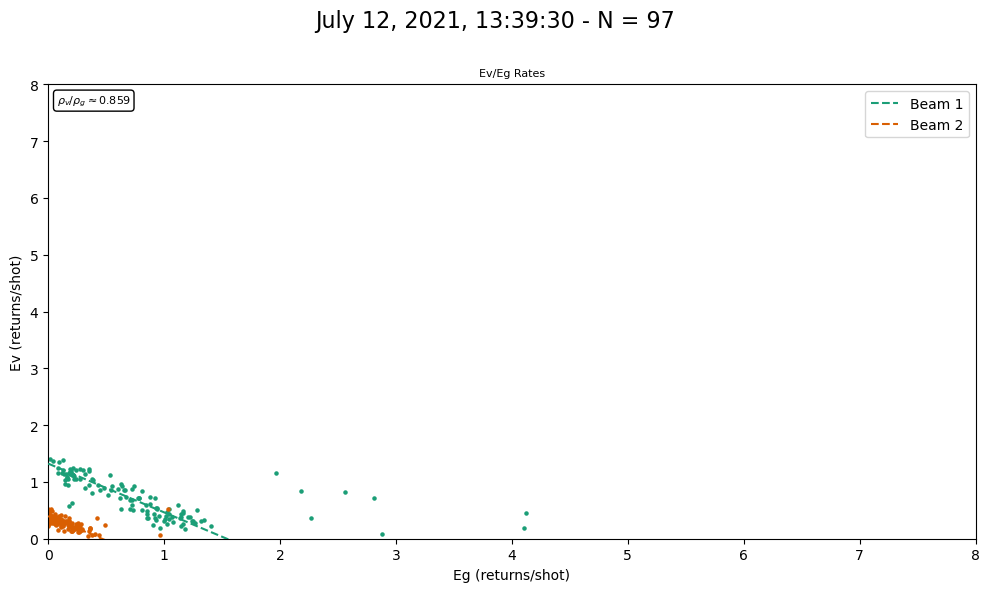

Beam 2 in file 98 has insufficient data.
Beam 4 in file 98 has insufficient data.


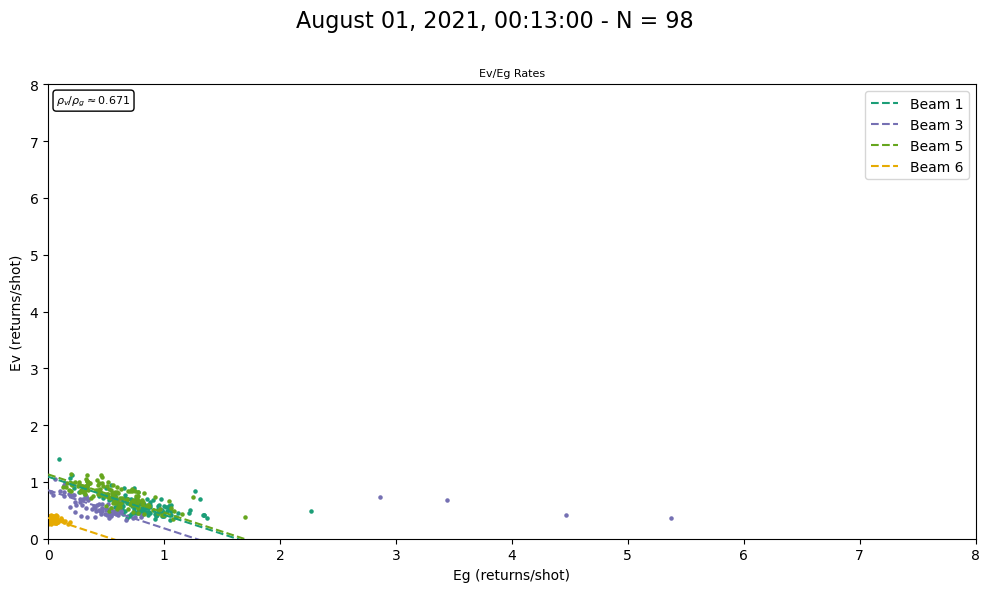

Beam 1 in file 99 has insufficient data.
Beam 2 in file 99 has insufficient data.
Beam 3 in file 99 has insufficient data.
Beam 4 in file 99 has insufficient data.
Beam 5 in file 99 has insufficient data.
Beam 6 in file 99 has insufficient data.
No beams have data in file 99, cannot regress.
Beam 1 in file 100 has insufficient data.
Beam 2 in file 100 has insufficient data.
Beam 3 in file 100 has insufficient data.
Beam 4 in file 100 has insufficient data.
Beam 5 in file 100 has insufficient data.
Beam 6 in file 100 has insufficient data.
No beams have data in file 100, cannot regress.
Beam 1 in file 101 has insufficient data.
Beam 2 in file 101 has insufficient data.
Beam 3 in file 101 has insufficient data.
Beam 4 in file 101 has insufficient data.
Beam 6 in file 101 has insufficient data.


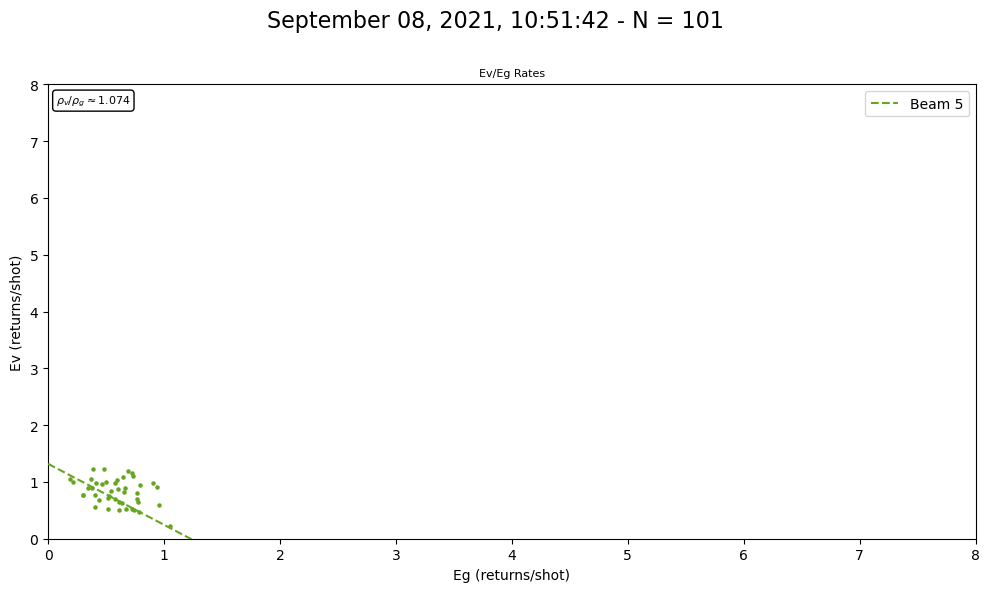

Beam 1 in file 102 has insufficient data.
Beam 2 in file 102 has insufficient data.
Beam 3 in file 102 has insufficient data.
Beam 4 in file 102 has insufficient data.
Beam 5 in file 102 has insufficient data.
Beam 6 in file 102 has insufficient data.
No beams have data in file 102, cannot regress.
Beam 1 in file 103 has insufficient data.
Beam 2 in file 103 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 103 has insufficient data.
Beam 4 in file 103 has insufficient data.
Beam 5 in file 103 has insufficient data.
Beam 6 in file 103 has insufficient data.
No beams have data in file 103, cannot regress.
Beam 1 in file 104 has insufficient data.
Beam 2 in file 104 has insufficient data.
Beam 3 in file 104 has insufficient data.
Beam 4 in file 104 has insufficient data.
Beam 5 in file 104 has insufficient data.
Beam 6 in file 104 has insufficient data.
No beams have data in file 104, cannot regress.
Beam 1 in file 105 has insufficient data.
Beam 2 in file 105 has insufficient data.
Beam 3 in file 105 has insufficient data.
Beam 4 in file 105 has insufficient data.
Beam 5 in file 105 has insufficient data.
Beam 6 in file 105 has insufficient data.
No beams have data in file 105, cannot regress.
Beam 1 in file 106 has insufficient data.
Beam 2 in file 106 has insufficient data.


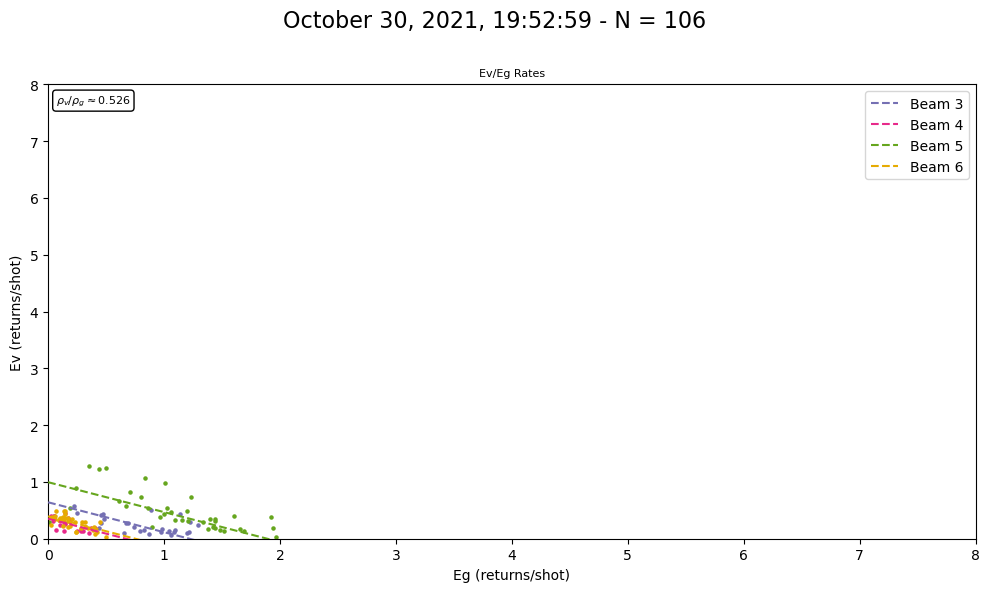

Beam 1 in file 107 has insufficient data.
Beam 2 in file 107 has insufficient data.
Beam 3 in file 107 has insufficient data.
Beam 4 in file 107 has insufficient data.
Beam 5 in file 107 has insufficient data.
Beam 6 in file 107 has insufficient data.
No beams have data in file 107, cannot regress.
Beam 1 in file 108 has insufficient data.
Beam 2 in file 108 has insufficient data.
Beam 3 in file 108 has insufficient data.
Beam 4 in file 108 has insufficient data.
Beam 5 in file 108 has insufficient data.
Beam 6 in file 108 has insufficient data.
No beams have data in file 108, cannot regress.
Beam 1 in file 109 has insufficient data.
Beam 2 in file 109 has insufficient data.
Beam 3 in file 109 has insufficient data.
Beam 4 in file 109 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 109 has insufficient data.
Beam 6 in file 109 has insufficient data.
No beams have data in file 109, cannot regress.
Beam 1 in file 110 has insufficient data.
Beam 2 in file 110 has insufficient data.
Beam 3 in file 110 has insufficient data.
Beam 4 in file 110 has insufficient data.
Beam 5 in file 110 has insufficient data.
Beam 6 in file 110 has insufficient data.
No beams have data in file 110, cannot regress.
Beam 1 in file 111 has insufficient data.
Beam 2 in file 111 has insufficient data.
Beam 3 in file 111 has insufficient data.
Beam 4 in file 111 has insufficient data.
Beam 5 in file 111 has insufficient data.
Beam 6 in file 111 has insufficient data.
No beams have data in file 111, cannot regress.
Beam 1 in file 112 has insufficient data.
Beam 2 in file 112 has insufficient data.
Beam 3 in file 112 has insufficient data.
Beam 4 in file 112 has insufficient data.
Beam 5 in file 112 has insufficient data.
Beam 6 in file 112 has insufficient data.
No beams have da

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 113 has insufficient data.
Beam 2 in file 113 has insufficient data.
Beam 3 in file 113 has insufficient data.
Beam 4 in file 113 has insufficient data.
Beam 5 in file 113 has insufficient data.
Beam 6 in file 113 has insufficient data.
No beams have data in file 113, cannot regress.
Beam 1 in file 114 has insufficient data.
Beam 2 in file 114 has insufficient data.
Beam 3 in file 114 has insufficient data.
Beam 4 in file 114 has insufficient data.
Beam 5 in file 114 has insufficient data.
Beam 6 in file 114 has insufficient data.
No beams have data in file 114, cannot regress.
Beam 1 in file 115 has insufficient data.
Beam 2 in file 115 has insufficient data.
Beam 3 in file 115 has insufficient data.
Beam 4 in file 115 has insufficient data.


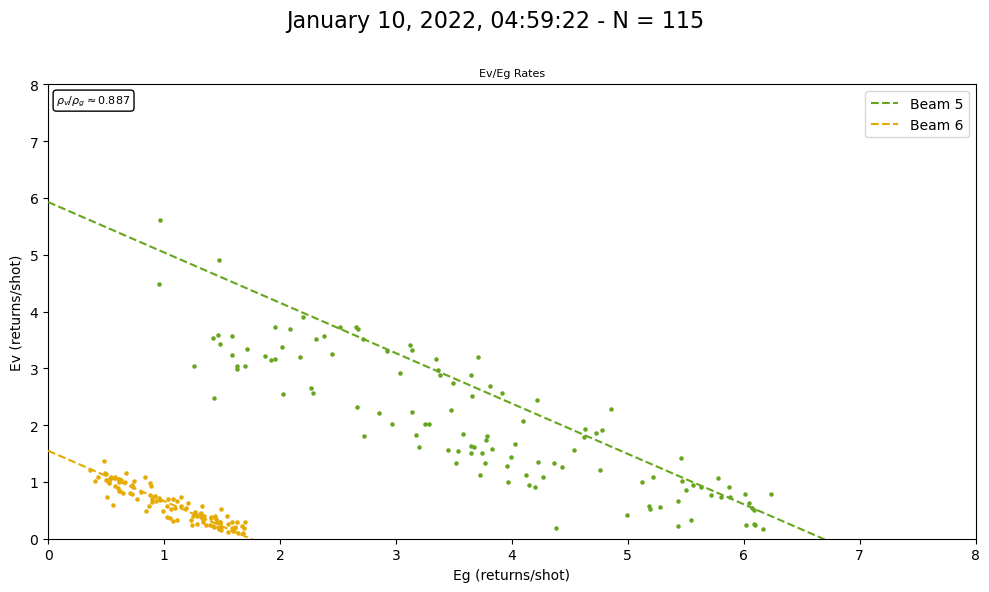

Beam 1 in file 116 has insufficient data.
Beam 2 in file 116 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 116 has insufficient data.
Beam 4 in file 116 has insufficient data.
Beam 5 in file 116 has insufficient data.
Beam 6 in file 116 has insufficient data.
No beams have data in file 116, cannot regress.
Beam 1 in file 117 has insufficient data.
Beam 2 in file 117 has insufficient data.
Beam 3 in file 117 has insufficient data.
Beam 4 in file 117 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 117 has insufficient data.
Beam 6 in file 117 has insufficient data.
No beams have data in file 117, cannot regress.
Beam 1 in file 118 has insufficient data.
Beam 2 in file 118 has insufficient data.
Beam 3 in file 118 has insufficient data.
Beam 4 in file 118 has insufficient data.
Beam 5 in file 118 has insufficient data.
Beam 6 in file 118 has insufficient data.
No beams have data in file 118, cannot regress.
Beam 5 in file 119 has insufficient data.
Beam 6 in file 119 has insufficient data.


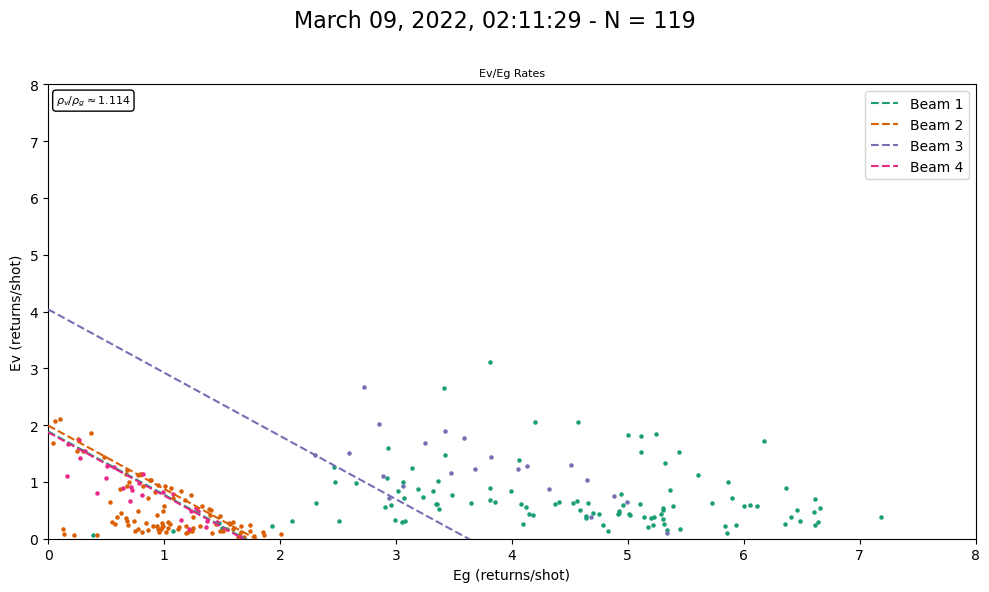

Beam 1 in file 120 has insufficient data.
Beam 2 in file 120 has insufficient data.
Beam 3 in file 120 has insufficient data.
Beam 4 in file 120 has insufficient data.
Beam 5 in file 120 has insufficient data.
Beam 6 in file 120 has insufficient data.
No beams have data in file 120, cannot regress.
Beam 1 in file 121 has insufficient data.
Beam 2 in file 121 has insufficient data.
Beam 3 in file 121 has insufficient data.
Beam 4 in file 121 has insufficient data.
Beam 5 in file 121 has insufficient data.
Beam 6 in file 121 has insufficient data.
No beams have data in file 121, cannot regress.
Beam 1 in file 122 has insufficient data.
Beam 2 in file 122 has insufficient data.
Beam 3 in file 122 has insufficient data.
Beam 4 in file 122 has insufficient data.
Beam 5 in file 122 has insufficient data.
Beam 6 in file 122 has insufficient data.
No beams have data in file 122, cannot regress.


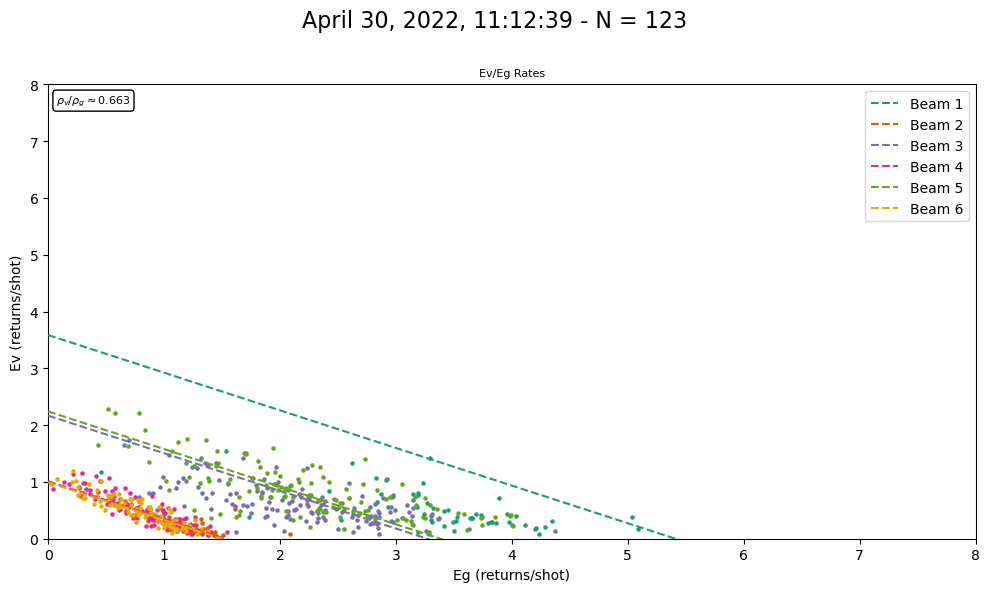

Beam 1 in file 124 has insufficient data.
Beam 2 in file 124 has insufficient data.
Beam 3 in file 124 has insufficient data.
Beam 4 in file 124 has insufficient data.
Beam 5 in file 124 has insufficient data.
Beam 6 in file 124 has insufficient data.
No beams have data in file 124, cannot regress.
Beam 1 in file 125 has insufficient data.
Beam 2 in file 125 has insufficient data.
Beam 3 in file 125 has insufficient data.
Beam 4 in file 125 has insufficient data.
Beam 5 in file 125 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 125 has insufficient data.
No beams have data in file 125, cannot regress.
Beam 1 in file 126 has insufficient data.
Beam 2 in file 126 has insufficient data.
Beam 3 in file 126 has insufficient data.
Beam 4 in file 126 has insufficient data.
Beam 6 in file 126 has insufficient data.


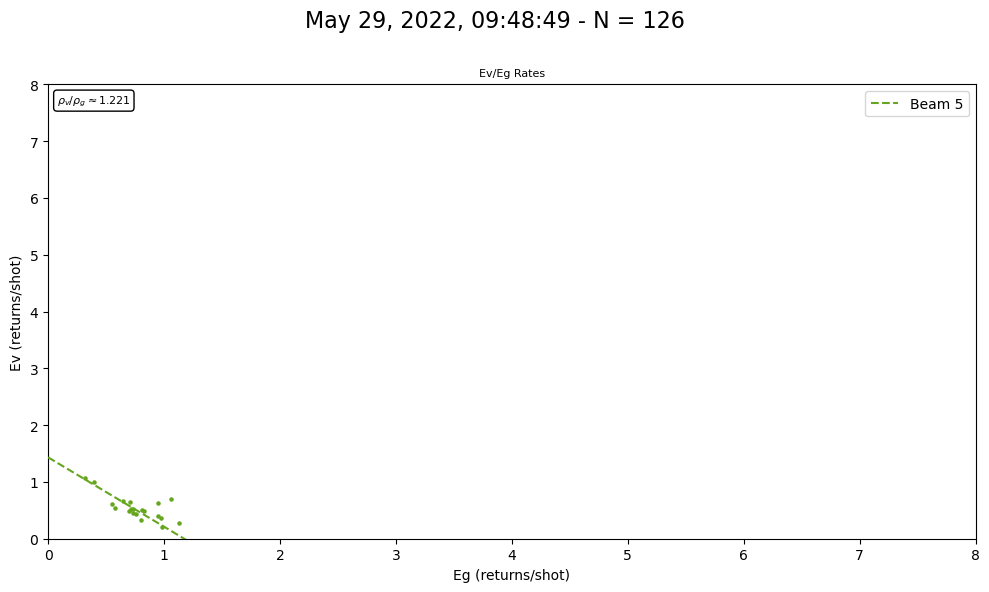

Beam 1 in file 127 has insufficient data.
Beam 2 in file 127 has insufficient data.
Beam 3 in file 127 has insufficient data.
Beam 4 in file 127 has insufficient data.
Beam 5 in file 127 has insufficient data.
Beam 6 in file 127 has insufficient data.
No beams have data in file 127, cannot regress.
Beam 1 in file 128 has insufficient data.
Beam 2 in file 128 has insufficient data.
Beam 3 in file 128 has insufficient data.
Beam 4 in file 128 has insufficient data.
Beam 5 in file 128 has insufficient data.
Beam 6 in file 128 has insufficient data.
No beams have data in file 128, cannot regress.
Beam 1 in file 129 has insufficient data.
Beam 2 in file 129 has insufficient data.
Beam 3 in file 129 has insufficient data.
Beam 4 in file 129 has insufficient data.
Beam 5 in file 129 has insufficient data.
Beam 6 in file 129 has insufficient data.
No beams have data in file 129, cannot regress.
Beam 1 in file 130 has insufficient data.
Beam 2 in file 130 has insufficient data.
Beam 3 in file 1

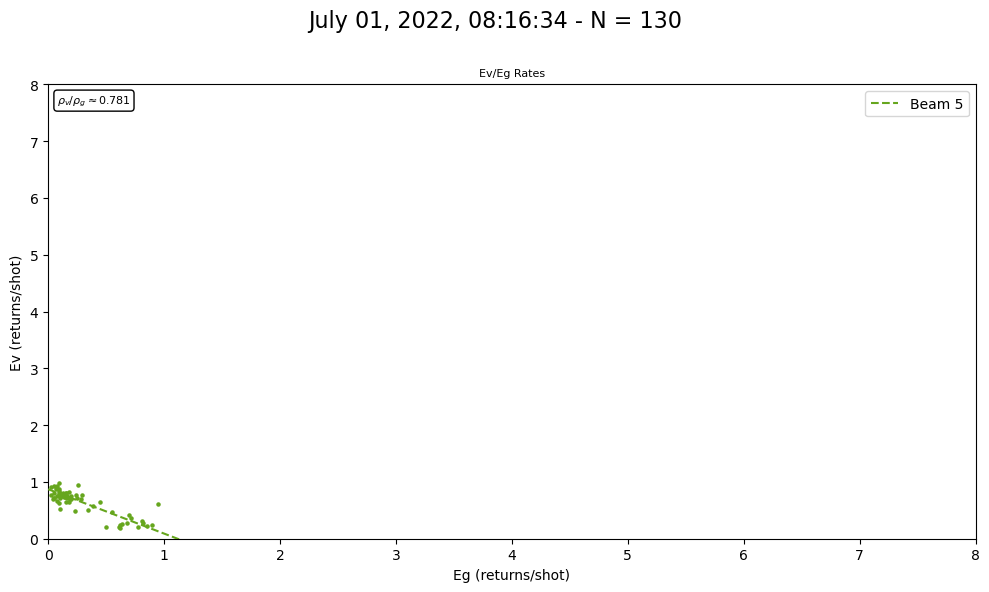

Beam 1 in file 131 has insufficient data.
Beam 2 in file 131 has insufficient data.
Beam 3 in file 131 has insufficient data.
Beam 4 in file 131 has insufficient data.
Beam 5 in file 131 has insufficient data.
Beam 6 in file 131 has insufficient data.
No beams have data in file 131, cannot regress.


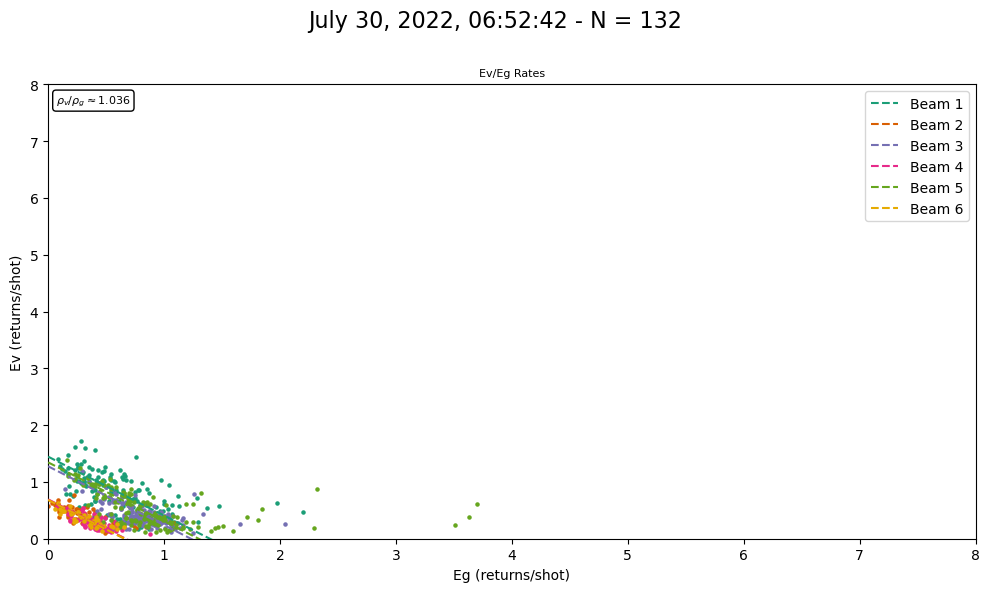

Beam 1 in file 133 has insufficient data.
Beam 2 in file 133 has insufficient data.
Beam 3 in file 133 has insufficient data.
Beam 4 in file 133 has insufficient data.
Beam 5 in file 133 has insufficient data.
Beam 6 in file 133 has insufficient data.
No beams have data in file 133, cannot regress.
Beam 1 in file 134 has insufficient data.
Beam 2 in file 134 has insufficient data.
Beam 3 in file 134 has insufficient data.
Beam 4 in file 134 has insufficient data.
Beam 5 in file 134 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 134 has insufficient data.
No beams have data in file 134, cannot regress.
Beam 1 in file 135 has insufficient data.
Beam 2 in file 135 has insufficient data.
Beam 3 in file 135 has insufficient data.
Beam 4 in file 135 has insufficient data.
Beam 5 in file 135 has insufficient data.
Beam 6 in file 135 has insufficient data.
No beams have data in file 135, cannot regress.
Beam 1 in file 136 has insufficient data.
Beam 2 in file 136 has insufficient data.
Beam 3 in file 136 has insufficient data.
Beam 4 in file 136 has insufficient data.
Beam 5 in file 136 has insufficient data.
Beam 6 in file 136 has insufficient data.
No beams have data in file 136, cannot regress.
Beam 1 in file 137 has insufficient data.
Beam 2 in file 137 has insufficient data.
Beam 3 in file 137 has insufficient data.
Beam 4 in file 137 has insufficient data.
Beam 5 in file 137 has insufficient data.
Beam 6 in file 137 has insufficient data.
No beams have data in file 137, cannot regress.
Beam 1 in 

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 138 has insufficient data.
Beam 5 in file 138 has insufficient data.
Beam 6 in file 138 has insufficient data.
No beams have data in file 138, cannot regress.
Beam 1 in file 139 has insufficient data.
Beam 2 in file 139 has insufficient data.
Beam 3 in file 139 has insufficient data.
Beam 4 in file 139 has insufficient data.
Beam 5 in file 139 has insufficient data.
Beam 6 in file 139 has insufficient data.
No beams have data in file 139, cannot regress.
Beam 1 in file 140 has insufficient data.
Beam 2 in file 140 has insufficient data.
Beam 3 in file 140 has insufficient data.
Beam 4 in file 140 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 140 has insufficient data.
Beam 6 in file 140 has insufficient data.
No beams have data in file 140, cannot regress.


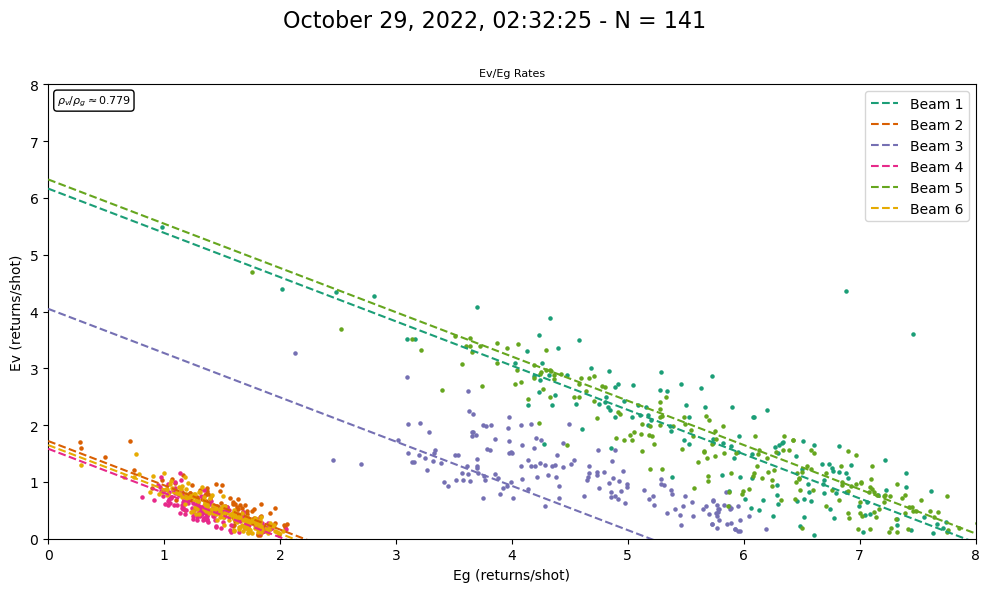

Beam 1 in file 142 has insufficient data.
Beam 2 in file 142 has insufficient data.
Beam 3 in file 142 has insufficient data.
Beam 4 in file 142 has insufficient data.
Beam 5 in file 142 has insufficient data.
Beam 6 in file 142 has insufficient data.
No beams have data in file 142, cannot regress.
Beam 1 in file 143 has insufficient data.
Beam 2 in file 143 has insufficient data.
Beam 3 in file 143 has insufficient data.
Beam 4 in file 143 has insufficient data.
Beam 5 in file 143 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 143 has insufficient data.
No beams have data in file 143, cannot regress.
Beam 1 in file 144 has insufficient data.
Beam 2 in file 144 has insufficient data.
Beam 3 in file 144 has insufficient data.
Beam 4 in file 144 has insufficient data.
Beam 5 in file 144 has insufficient data.
Beam 6 in file 144 has insufficient data.
No beams have data in file 144, cannot regress.
Beam 1 in file 145 has insufficient data.
Beam 2 in file 145 has insufficient data.
Beam 4 in file 145 has insufficient data.
Beam 6 in file 145 has insufficient data.


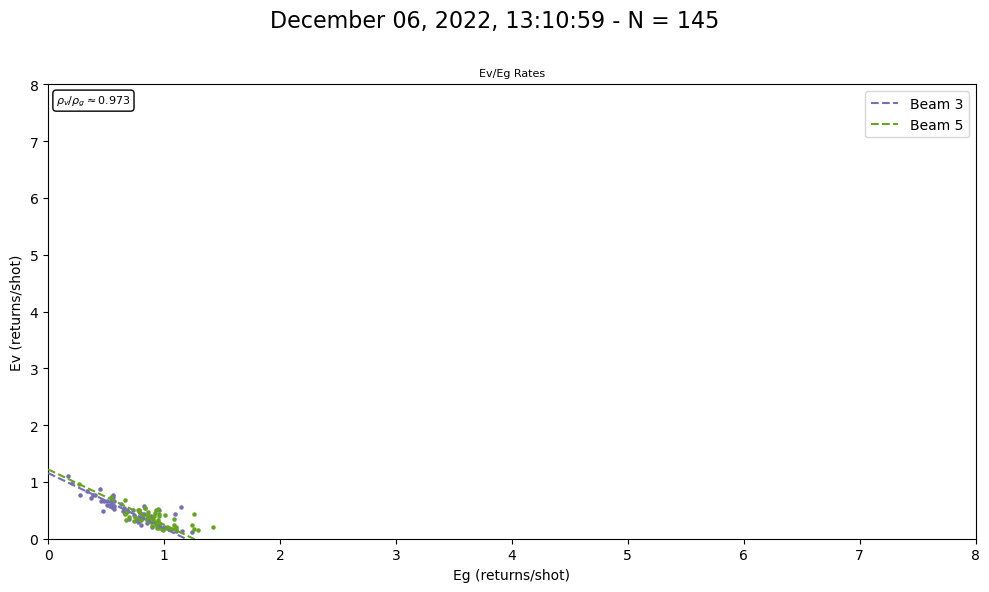

Beam 1 in file 146 has insufficient data.
Beam 2 in file 146 has insufficient data.
Beam 3 in file 146 has insufficient data.
Beam 4 in file 146 has insufficient data.
Beam 5 in file 146 has insufficient data.
Beam 6 in file 146 has insufficient data.
No beams have data in file 146, cannot regress.
Beam 1 in file 147 has insufficient data.
Beam 2 in file 147 has insufficient data.
Beam 3 in file 147 has insufficient data.
Beam 4 in file 147 has insufficient data.
Beam 5 in file 147 has insufficient data.
Beam 6 in file 147 has insufficient data.
No beams have data in file 147, cannot regress.
Beam 1 in file 148 has insufficient data.
Beam 2 in file 148 has insufficient data.
Beam 4 in file 148 has insufficient data.
Beam 5 in file 148 has insufficient data.
Beam 6 in file 148 has insufficient data.


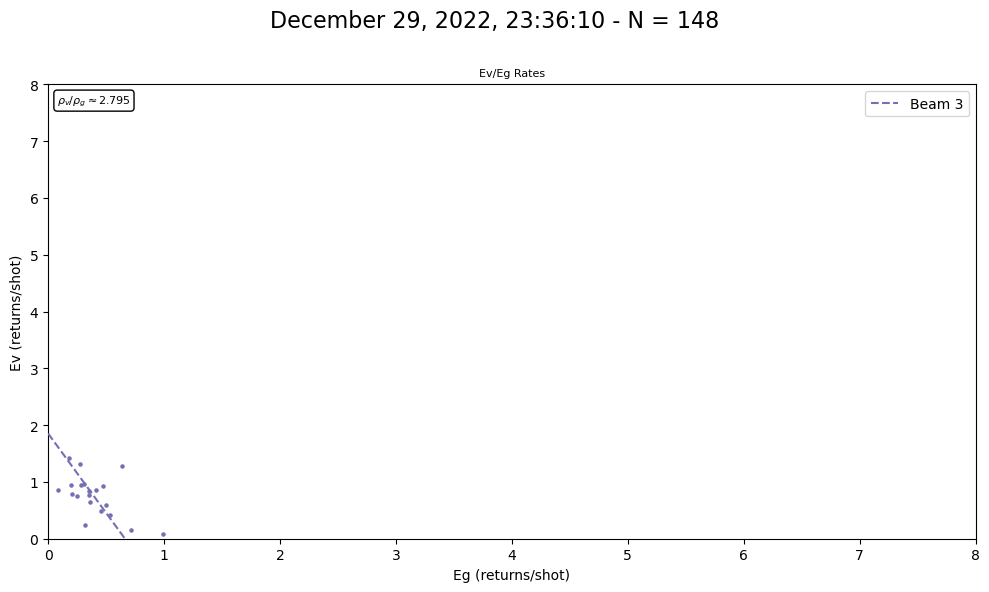

Beam 1 in file 149 has insufficient data.
Beam 2 in file 149 has insufficient data.
Beam 3 in file 149 has insufficient data.
Beam 4 in file 149 has insufficient data.
Beam 5 in file 149 has insufficient data.
Beam 6 in file 149 has insufficient data.
No beams have data in file 149, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


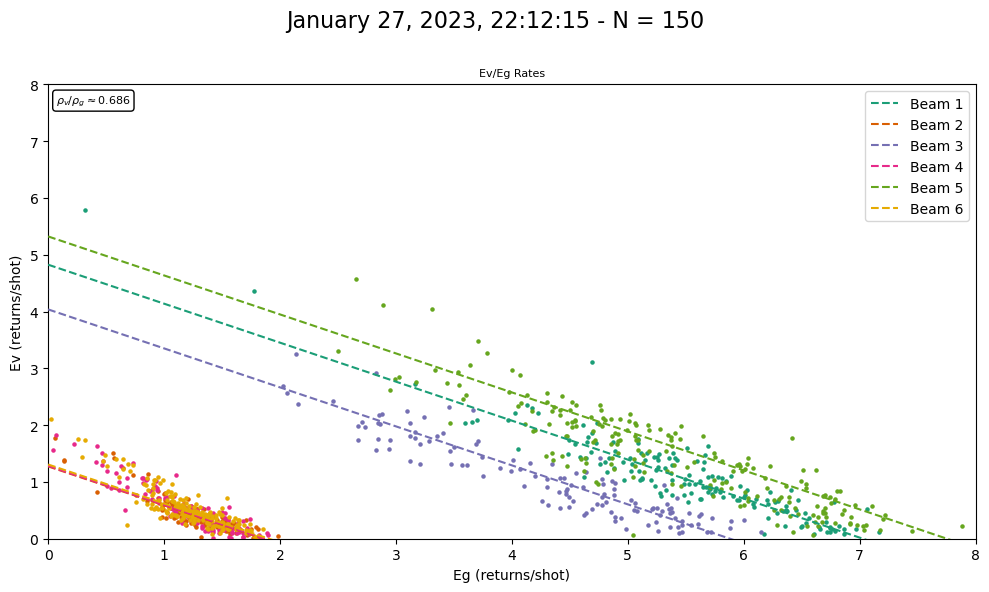

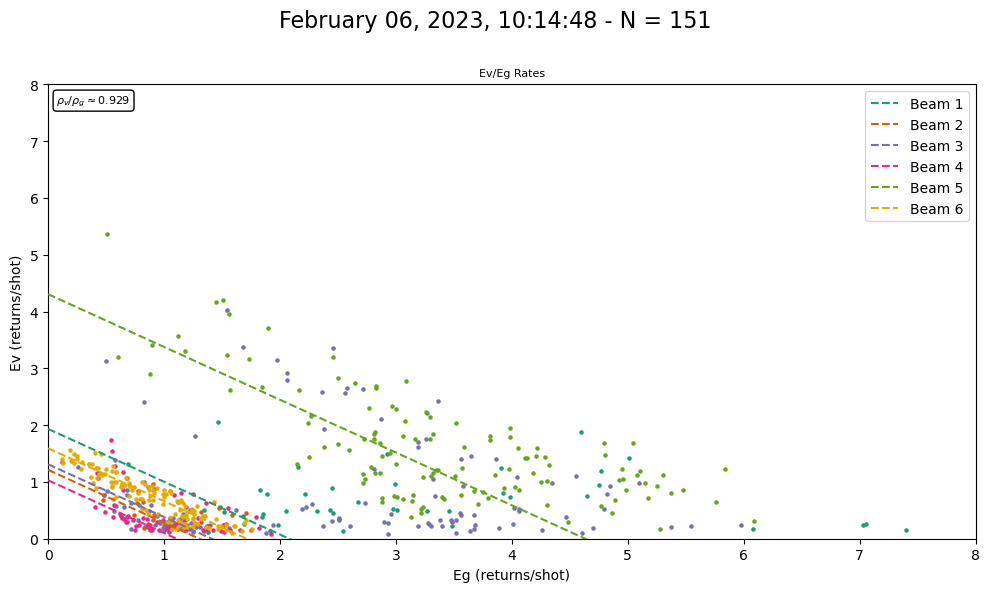

Beam 1 in file 152 has insufficient data.
Beam 2 in file 152 has insufficient data.
Beam 3 in file 152 has insufficient data.
Beam 4 in file 152 has insufficient data.
Beam 5 in file 152 has insufficient data.
Beam 6 in file 152 has insufficient data.
No beams have data in file 152, cannot regress.
Beam 1 in file 153 has insufficient data.
Beam 2 in file 153 has insufficient data.
Beam 3 in file 153 has insufficient data.
Beam 4 in file 153 has insufficient data.
Beam 5 in file 153 has insufficient data.
Beam 6 in file 153 has insufficient data.
No beams have data in file 153, cannot regress.
Beam 1 in file 154 has insufficient data.
Beam 2 in file 154 has insufficient data.
Beam 3 in file 154 has insufficient data.
Beam 4 in file 154 has insufficient data.
Beam 5 in file 154 has insufficient data.
Beam 6 in file 154 has insufficient data.
No beams have data in file 154, cannot regress.
Beam 1 in file 155 has insufficient data.
Beam 2 in file 155 has insufficient data.
Beam 3 in file 1

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 155 has insufficient data.
Beam 5 in file 155 has insufficient data.
Beam 6 in file 155 has insufficient data.
No beams have data in file 155, cannot regress.
Beam 1 in file 156 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 2 in file 156 has insufficient data.
Beam 3 in file 156 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 156 has insufficient data.
Beam 5 in file 156 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 156 has insufficient data.
No beams have data in file 156, cannot regress.
Beam 1 in file 157 has insufficient data.
Beam 2 in file 157 has insufficient data.
Beam 3 in file 157 has insufficient data.
Beam 4 in file 157 has insufficient data.
Beam 5 in file 157 has insufficient data.
Beam 6 in file 157 has insufficient data.
No beams have data in file 157, cannot regress.
Beam 1 in file 158 has insufficient data.
Beam 2 in file 158 has insufficient data.
Beam 3 in file 158 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 158 has insufficient data.
Beam 5 in file 158 has insufficient data.
Beam 6 in file 158 has insufficient data.
No beams have data in file 158, cannot regress.
Beam 1 in file 159 has insufficient data.
Beam 2 in file 159 has insufficient data.
Beam 3 in file 159 has insufficient data.
Beam 4 in file 159 has insufficient data.
Beam 6 in file 159 has insufficient data.


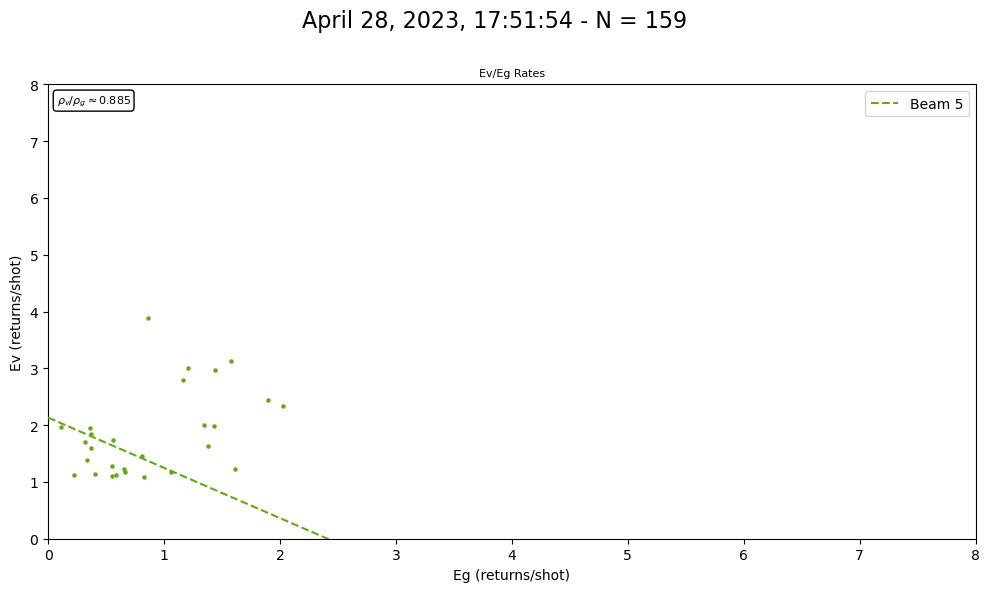

Beam 4 in file 160 has insufficient data.


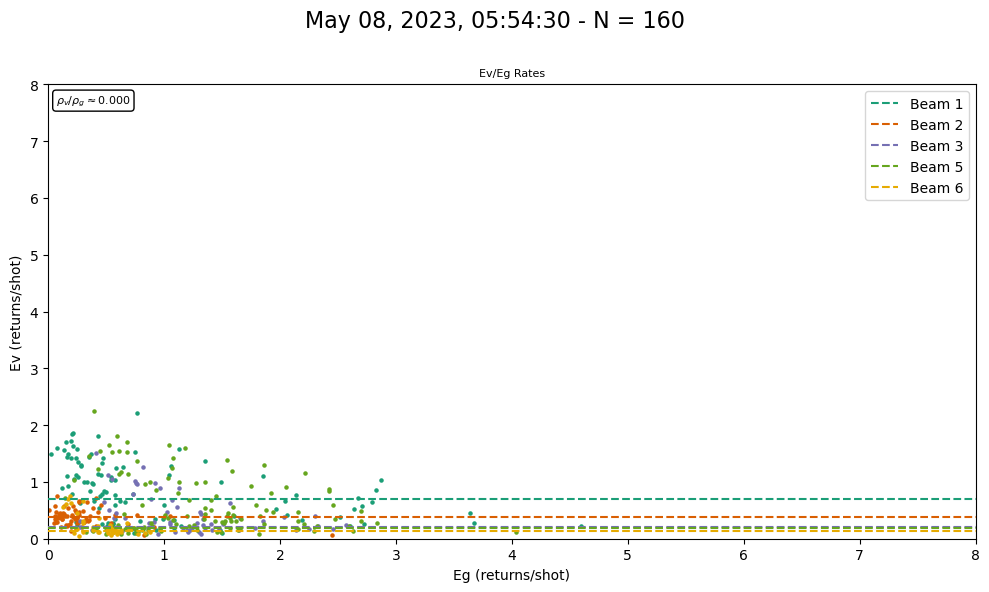

Beam 1 in file 161 has insufficient data.
Beam 2 in file 161 has insufficient data.
Beam 3 in file 161 has insufficient data.
Beam 4 in file 161 has insufficient data.
Beam 5 in file 161 has insufficient data.
Beam 6 in file 161 has insufficient data.
No beams have data in file 161, cannot regress.
Beam 3 in file 162 has insufficient data.
Beam 4 in file 162 has insufficient data.
Beam 5 in file 162 has insufficient data.
Beam 6 in file 162 has insufficient data.


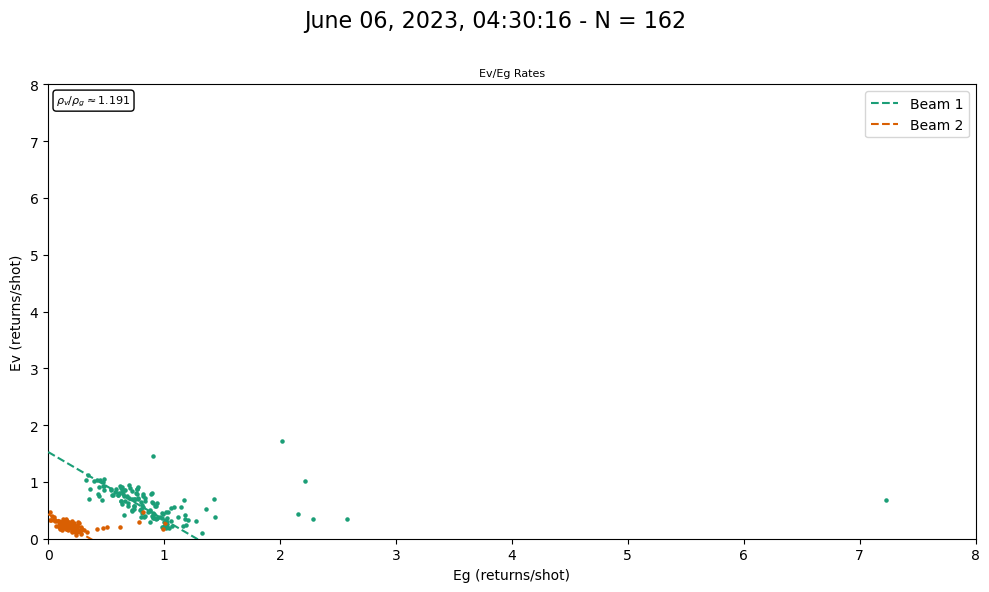

Beam 1 in file 163 has insufficient data.
Beam 2 in file 163 has insufficient data.
Beam 3 in file 163 has insufficient data.
Beam 4 in file 163 has insufficient data.
Beam 5 in file 163 has insufficient data.
Beam 6 in file 163 has insufficient data.
No beams have data in file 163, cannot regress.
Beam 1 in file 164 has insufficient data.
Beam 2 in file 164 has insufficient data.
Beam 3 in file 164 has insufficient data.
Beam 4 in file 164 has insufficient data.
Beam 5 in file 164 has insufficient data.
Beam 6 in file 164 has insufficient data.
No beams have data in file 164, cannot regress.
Beam 1 in file 165 has insufficient data.
Beam 2 in file 165 has insufficient data.
Beam 3 in file 165 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 165 has insufficient data.
Beam 5 in file 165 has insufficient data.
Beam 6 in file 165 has insufficient data.
No beams have data in file 165, cannot regress.
Beam 1 in file 166 has insufficient data.
Beam 2 in file 166 has insufficient data.
Beam 3 in file 166 has insufficient data.
Beam 4 in file 166 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 166 has insufficient data.
Beam 6 in file 166 has insufficient data.
No beams have data in file 166, cannot regress.
Beam 1 in file 167 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 2 in file 167 has insufficient data.
Beam 3 in file 167 has insufficient data.
Beam 4 in file 167 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 167 has insufficient data.
Beam 6 in file 167 has insufficient data.
No beams have data in file 167, cannot regress.
Beam 1 in file 168 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 2 in file 168 has insufficient data.
Beam 3 in file 168 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 168 has insufficient data.
Beam 5 in file 168 has insufficient data.
Beam 6 in file 168 has insufficient data.
No beams have data in file 168, cannot regress.
Beam 1 in file 169 has insufficient data.
Beam 2 in file 169 has insufficient data.
Beam 3 in file 169 has insufficient data.
Beam 4 in file 169 has insufficient data.
Beam 5 in file 169 has insufficient data.
Beam 6 in file 169 has insufficient data.
No beams have data in file 169, cannot regress.
Beam 1 in file 170 has insufficient data.
Beam 2 in file 170 has insufficient data.
Beam 3 in file 170 has insufficient data.
Beam 4 in file 170 has insufficient data.
Beam 5 in file 170 has insufficient data.
Beam 6 in file 170 has insufficient data.
No beams have data in file 170, cannot regress.
Beam 2 in file 171 has insufficient data.
Beam 4 in file 171 has insufficient data.
Beam 6 in file 171 has insufficient data.


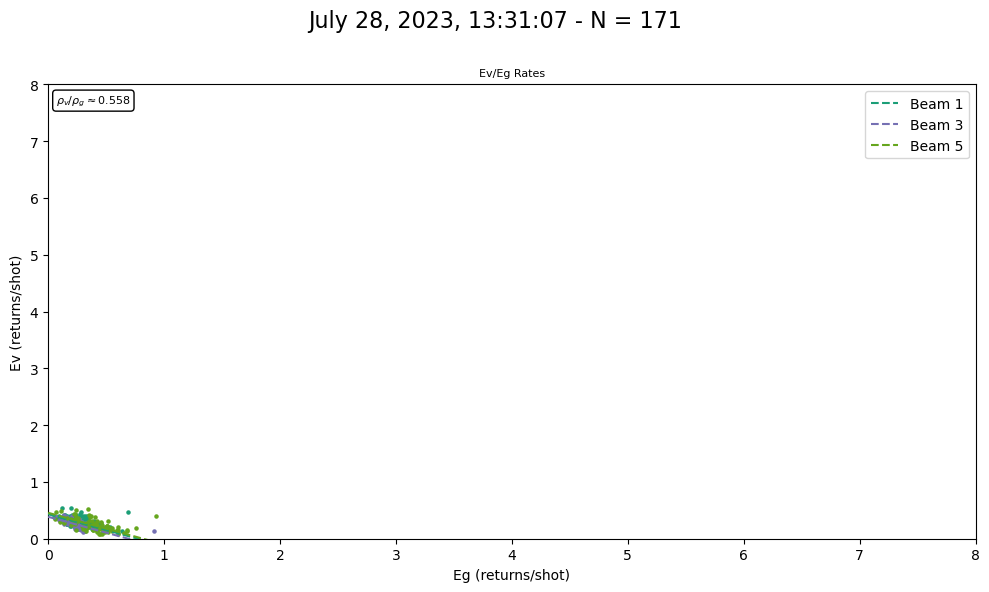

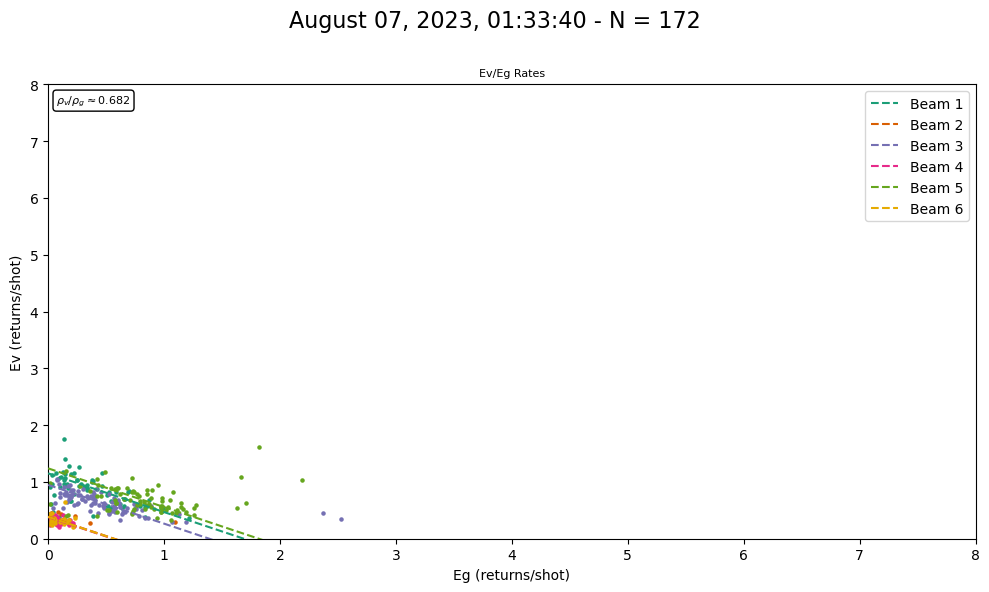

Beam 1 in file 173 has insufficient data.
Beam 2 in file 173 has insufficient data.
Beam 3 in file 173 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 173 has insufficient data.
Beam 5 in file 173 has insufficient data.
Beam 6 in file 173 has insufficient data.
No beams have data in file 173, cannot regress.
Beam 1 in file 174 has insufficient data.
Beam 2 in file 174 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 174 has insufficient data.
Beam 4 in file 174 has insufficient data.
Beam 5 in file 174 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 174 has insufficient data.
No beams have data in file 174, cannot regress.
Beam 1 in file 175 has insufficient data.
Beam 2 in file 175 has insufficient data.
Beam 3 in file 175 has insufficient data.
Beam 4 in file 175 has insufficient data.
Beam 5 in file 175 has insufficient data.
Beam 6 in file 175 has insufficient data.
No beams have data in file 175, cannot regress.


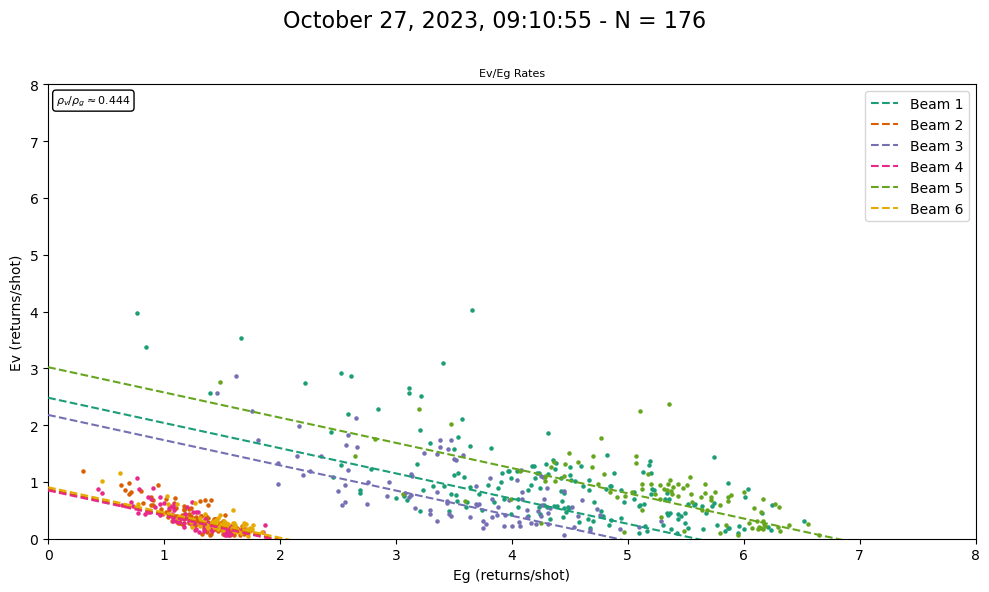

Beam 1 in file 177 has insufficient data.
Beam 2 in file 177 has insufficient data.
Beam 3 in file 177 has insufficient data.
Beam 4 in file 177 has insufficient data.
Beam 5 in file 177 has insufficient data.
Beam 6 in file 177 has insufficient data.
No beams have data in file 177, cannot regress.
Beam 1 in file 178 has insufficient data.
Beam 2 in file 178 has insufficient data.
Beam 3 in file 178 has insufficient data.
Beam 4 in file 178 has insufficient data.
Beam 5 in file 178 has insufficient data.
Beam 6 in file 178 has insufficient data.
No beams have data in file 178, cannot regress.
Beam 1 in file 179 has insufficient data.
Beam 2 in file 179 has insufficient data.
Beam 3 in file 179 has insufficient data.
Beam 4 in file 179 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 179 has insufficient data.
Beam 6 in file 179 has insufficient data.
No beams have data in file 179, cannot regress.


In [5]:
from scripts.parallel import *

# dirpath = 'R:/data/sodankyla_full/'
dirpath = '../data_store/data/delta_junction/'

# data = []

all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

coords = (-145.7514, 63.8811)

# problematic: 0, 25, 48, 

for i in range(N):
    data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
                         graph_detail=1, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1, altitude=504)
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
    #                      graph_detail=2, loss='linear',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1, altitude=504)
#     print(data)

# Marcell MN

Beam 2 in file 64 has insufficient data.
Beam 4 in file 64 has insufficient data.
Beam 6 in file 64 has insufficient data.


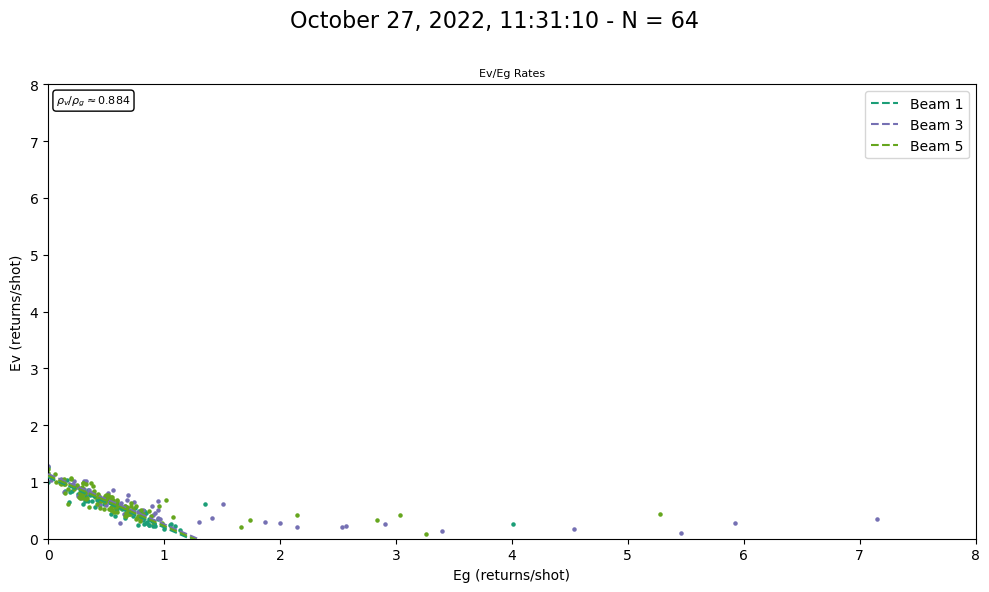

Beam 1 in file 65 has insufficient data.
Beam 2 in file 65 has insufficient data.
Beam 3 in file 65 has insufficient data.
Beam 4 in file 65 has insufficient data.
Beam 6 in file 65 has insufficient data.


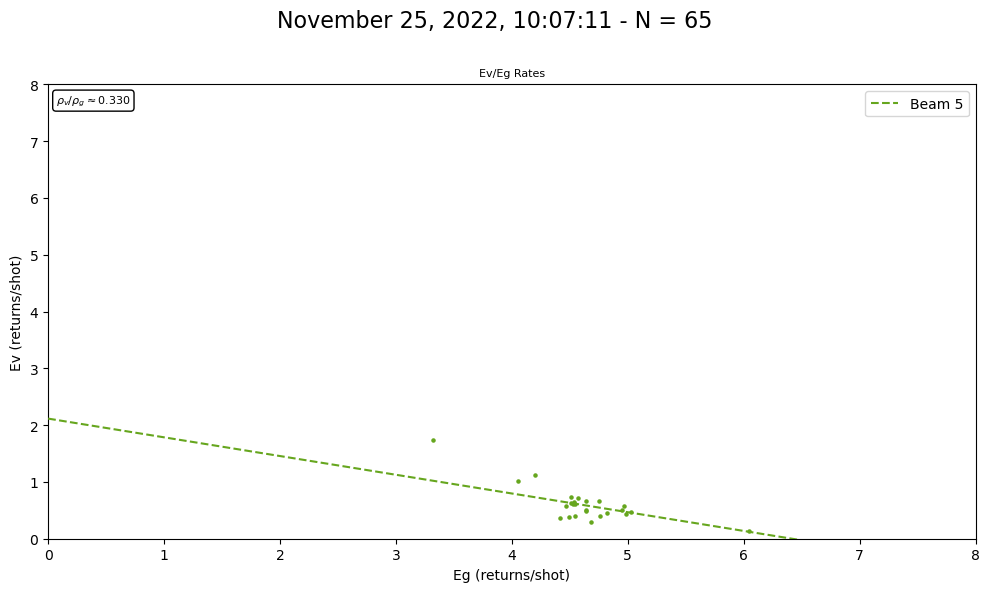

Beam 1 in file 66 has insufficient data.
Beam 2 in file 66 has insufficient data.
Beam 3 in file 66 has insufficient data.
Beam 4 in file 66 has insufficient data.
Beam 5 in file 66 has insufficient data.
Beam 6 in file 66 has insufficient data.
No beams have data in file 66, cannot regress.


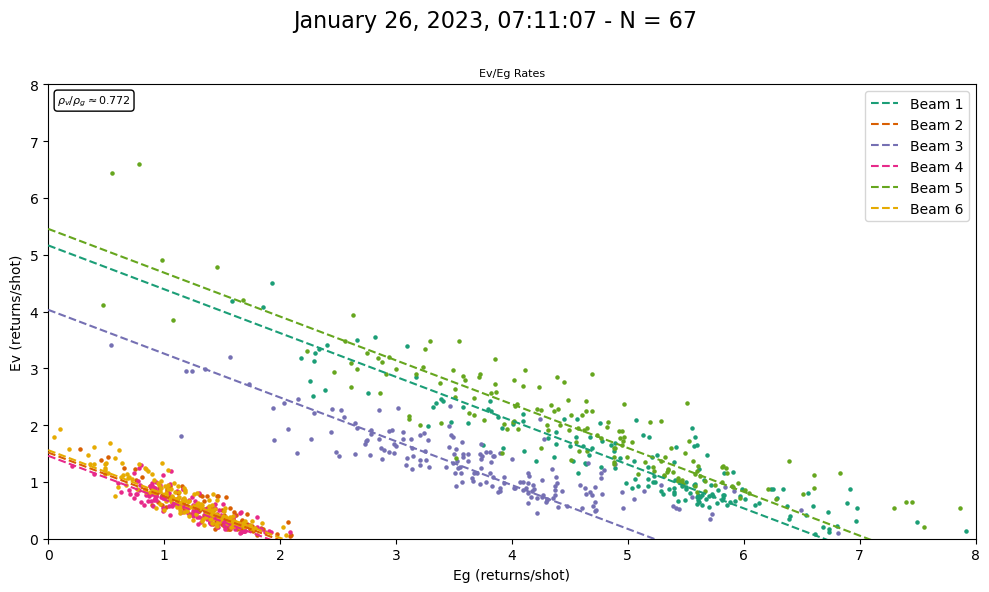

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 68 has insufficient data.
Beam 2 in file 68 has insufficient data.
Beam 3 in file 68 has insufficient data.
Beam 4 in file 68 has insufficient data.
Beam 5 in file 68 has insufficient data.
Beam 6 in file 68 has insufficient data.
No beams have data in file 68, cannot regress.
Beam 1 in file 69 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 2 in file 69 has insufficient data.
Beam 3 in file 69 has insufficient data.
Beam 4 in file 69 has insufficient data.
Beam 5 in file 69 has insufficient data.
Beam 6 in file 69 has insufficient data.
No beams have data in file 69, cannot regress.
Beam 1 in file 70 has insufficient data.
Beam 2 in file 70 has insufficient data.
Beam 3 in file 70 has insufficient data.
Beam 4 in file 70 has insufficient data.
Beam 5 in file 70 has insufficient data.
Beam 6 in file 70 has insufficient data.
No beams have data in file 70, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 71 has insufficient data.
Beam 2 in file 71 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 71 has insufficient data.
Beam 4 in file 71 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 71 has insufficient data.
Beam 6 in file 71 has insufficient data.
No beams have data in file 71, cannot regress.
Beam 1 in file 72 has insufficient data.
Beam 2 in file 72 has insufficient data.
Beam 3 in file 72 has insufficient data.
Beam 4 in file 72 has insufficient data.
Beam 5 in file 72 has insufficient data.
Beam 6 in file 72 has insufficient data.
No beams have data in file 72, cannot regress.
Beam 1 in file 73 has insufficient data.
Beam 2 in file 73 has insufficient data.
Beam 3 in file 73 has insufficient data.
Beam 4 in file 73 has insufficient data.
Beam 5 in file 73 has insufficient data.
Beam 6 in file 73 has insufficient data.
No beams have data in file 73, cannot regress.
Beam 1 in file 74 has insufficient data.
Beam 2 in file 74 has insufficient data.
Beam 3 in file 74 has insufficient data.
Beam 4 in file 74 has insufficient data.
Beam 5 in file 74 has insufficient data.
Beam 6 in file 74 has insufficient data.
No beams have data in file 74, cannot r

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 75 has insufficient data.
Beam 4 in file 75 has insufficient data.
Beam 5 in file 75 has insufficient data.
Beam 6 in file 75 has insufficient data.
No beams have data in file 75, cannot regress.
Beam 1 in file 76 has insufficient data.
Beam 2 in file 76 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 76 has insufficient data.
Beam 4 in file 76 has insufficient data.
Beam 5 in file 76 has insufficient data.
Beam 6 in file 76 has insufficient data.
No beams have data in file 76, cannot regress.
Beam 1 in file 77 has insufficient data.
Beam 2 in file 77 has insufficient data.
Beam 3 in file 77 has insufficient data.
Beam 4 in file 77 has insufficient data.
Beam 5 in file 77 has insufficient data.
Beam 6 in file 77 has insufficient data.
No beams have data in file 77, cannot regress.


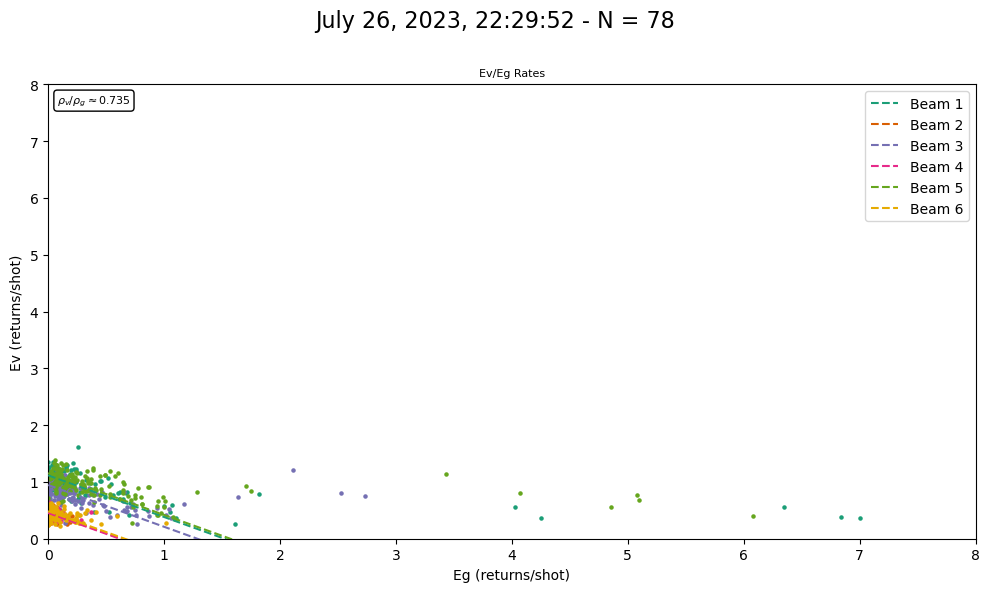

Beam 3 in file 79 has insufficient data.
Beam 4 in file 79 has insufficient data.
Beam 5 in file 79 has insufficient data.
Beam 6 in file 79 has insufficient data.


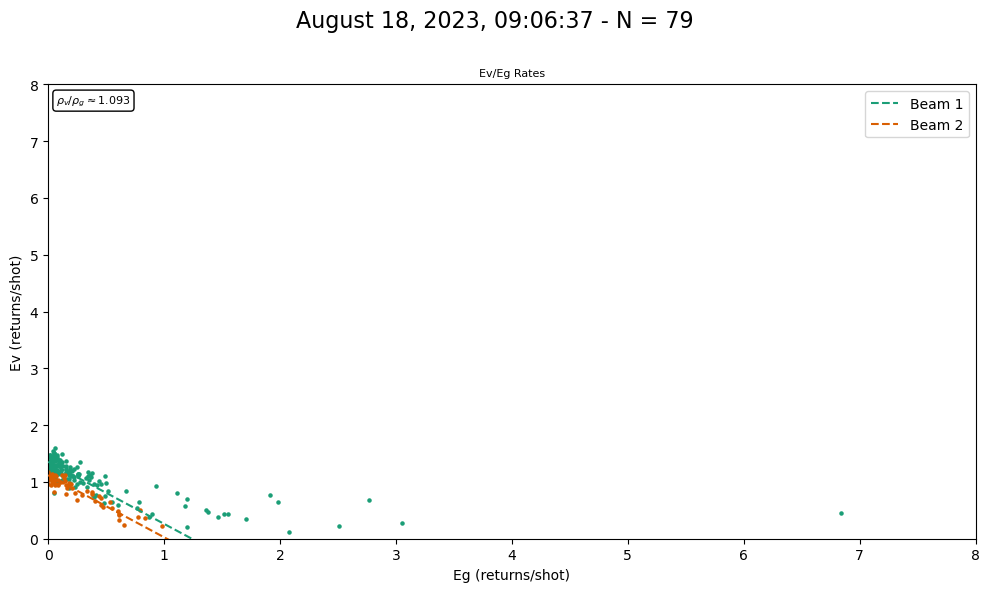

Beam 1 in file 80 has insufficient data.
Beam 2 in file 80 has insufficient data.
Beam 3 in file 80 has insufficient data.
Beam 4 in file 80 has insufficient data.
Beam 5 in file 80 has insufficient data.
Beam 6 in file 80 has insufficient data.
No beams have data in file 80, cannot regress.
Beam 1 in file 81 has insufficient data.
Beam 2 in file 81 has insufficient data.
Beam 3 in file 81 has insufficient data.
Beam 4 in file 81 has insufficient data.
Beam 5 in file 81 has insufficient data.
Beam 6 in file 81 has insufficient data.
No beams have data in file 81, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 82 has insufficient data.
Beam 2 in file 82 has insufficient data.
Beam 3 in file 82 has insufficient data.
Beam 4 in file 82 has insufficient data.
Beam 5 in file 82 has insufficient data.
Beam 6 in file 82 has insufficient data.
No beams have data in file 82, cannot regress.
Beam 1 in file 83 has insufficient data.
Beam 2 in file 83 has insufficient data.
Beam 3 in file 83 has insufficient data.
Beam 4 in file 83 has insufficient data.
Beam 5 in file 83 has insufficient data.
Beam 6 in file 83 has insufficient data.
No beams have data in file 83, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 84 has insufficient data.
Beam 2 in file 84 has insufficient data.
Beam 3 in file 84 has insufficient data.
Beam 4 in file 84 has insufficient data.
Beam 5 in file 84 has insufficient data.
Beam 6 in file 84 has insufficient data.
No beams have data in file 84, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 85 has insufficient data.
Beam 2 in file 85 has insufficient data.
Beam 3 in file 85 has insufficient data.
Beam 4 in file 85 has insufficient data.
Beam 5 in file 85 has insufficient data.
Beam 6 in file 85 has insufficient data.
No beams have data in file 85, cannot regress.
Beam 1 in file 86 has insufficient data.
Beam 2 in file 86 has insufficient data.
Beam 3 in file 86 has insufficient data.
Beam 4 in file 86 has insufficient data.


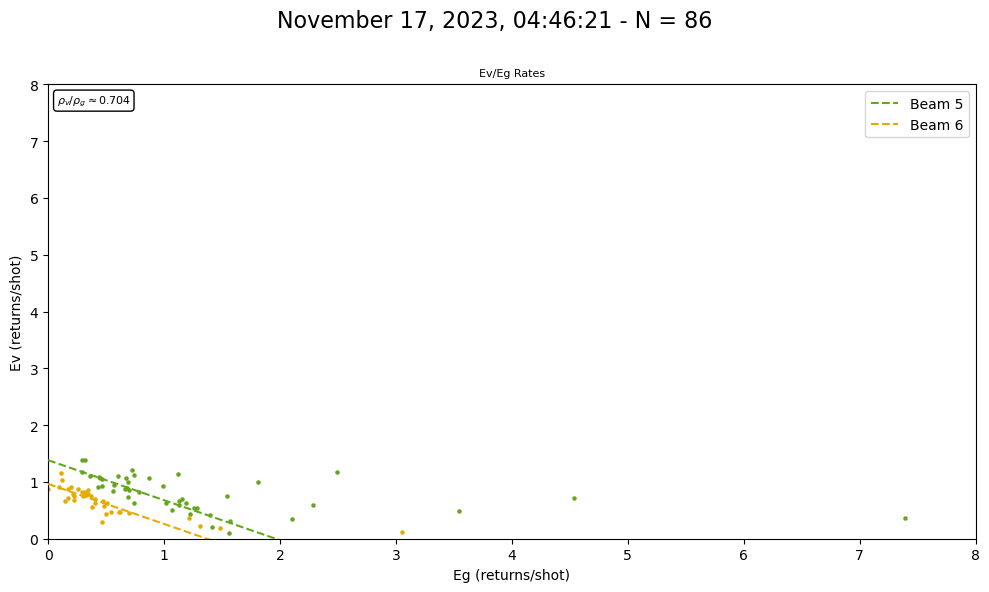

Beam 1 in file 87 has insufficient data.
Beam 2 in file 87 has insufficient data.
Beam 3 in file 87 has insufficient data.
Beam 4 in file 87 has insufficient data.
Beam 5 in file 87 has insufficient data.
Beam 6 in file 87 has insufficient data.
No beams have data in file 87, cannot regress.


In [12]:
from scripts.parallel import *

# dirpath = 'R:/data/sodankyla_full/'
dirpath = '../data_store/data/marcell_MN/'

# data = []

all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

coords = (-93.4541, 47.5049)

# problematic: 12!, 28!, 

for i in range(64,N):
    data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
                         graph_detail=1, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1, altitude=413)
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
    #                      graph_detail=1, loss='linear',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1, altitude=413)
#     print(data)

# Lacclair

Beam 1 in file 0 has insufficient data.
Beam 2 in file 0 has insufficient data.
Beam 3 in file 0 has insufficient data.
Beam 4 in file 0 has insufficient data.
Beam 5 in file 0 has insufficient data.
Beam 6 in file 0 has insufficient data.
No beams have data in file 0, cannot regress.
Beam 1 in file 1 has insufficient data.
Beam 2 in file 1 has insufficient data.
Beam 3 in file 1 has insufficient data.
Beam 4 in file 1 has insufficient data.
Beam 5 in file 1 has insufficient data.
Beam 6 in file 1 has insufficient data.
No beams have data in file 1, cannot regress.
Beam 1 in file 2 has insufficient data.
Beam 2 in file 2 has insufficient data.
Beam 3 in file 2 has insufficient data.
Beam 4 in file 2 has insufficient data.
Beam 5 in file 2 has insufficient data.
Beam 6 in file 2 has insufficient data.
No beams have data in file 2, cannot regress.
Beam 1 in file 3 has insufficient data.
Beam 2 in file 3 has insufficient data.
Beam 3 in file 3 has insufficient data.
Beam 4 in file 3 has i

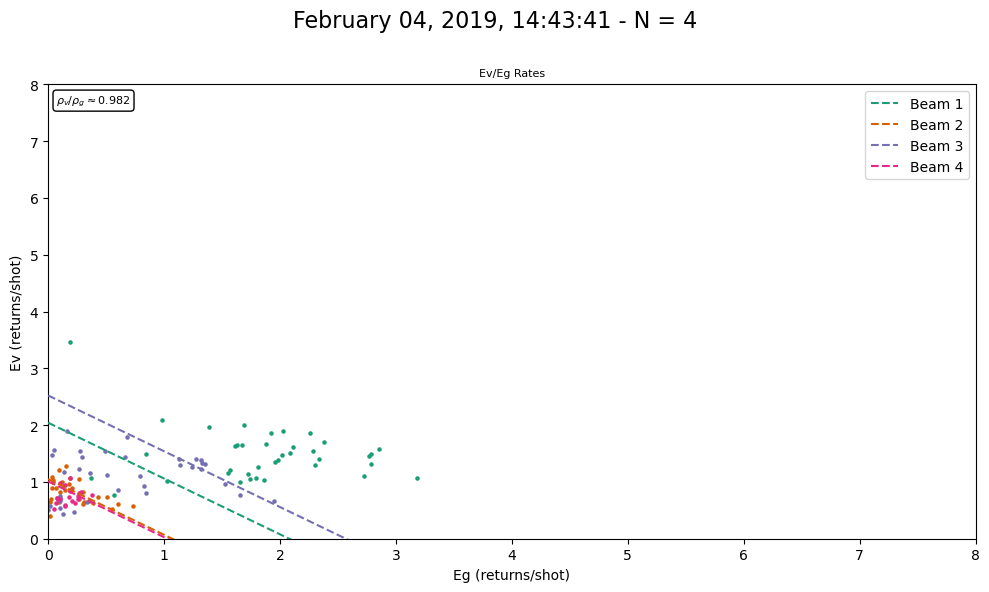

Beam 1 in file 5 has insufficient data.
Beam 2 in file 5 has insufficient data.
Beam 3 in file 5 has insufficient data.
Beam 4 in file 5 has insufficient data.
Beam 5 in file 5 has insufficient data.
Beam 6 in file 5 has insufficient data.
No beams have data in file 5, cannot regress.
Beam 1 in file 6 has insufficient data.
Beam 2 in file 6 has insufficient data.


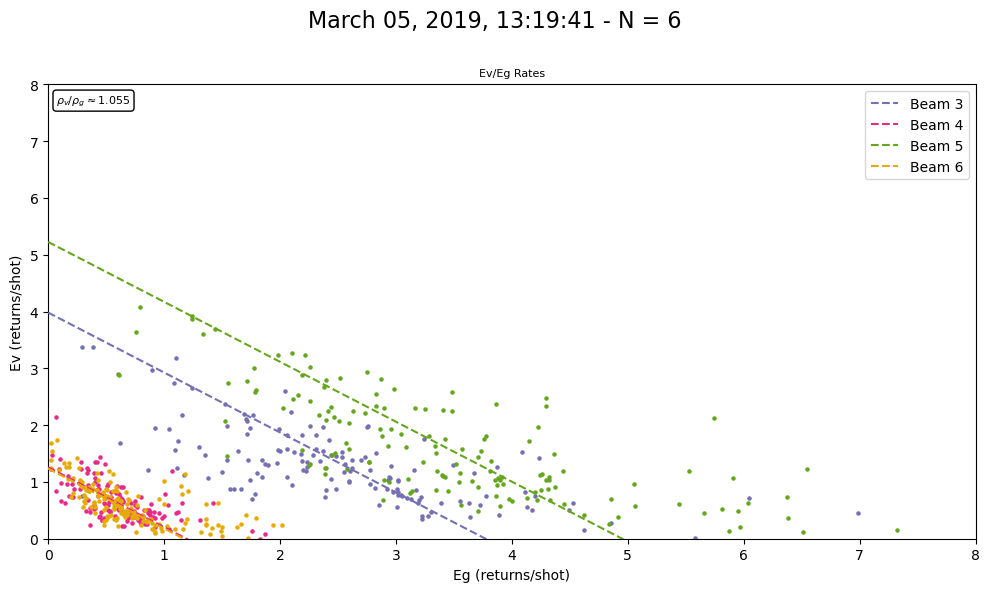

Beam 1 in file 7 has insufficient data.
Beam 2 in file 7 has insufficient data.
Beam 3 in file 7 has insufficient data.
Beam 4 in file 7 has insufficient data.
Beam 5 in file 7 has insufficient data.
Beam 6 in file 7 has insufficient data.
No beams have data in file 7, cannot regress.
Beam 1 in file 8 has insufficient data.
Beam 2 in file 8 has insufficient data.
Beam 3 in file 8 has insufficient data.
Beam 4 in file 8 has insufficient data.
Beam 5 in file 8 has insufficient data.
Beam 6 in file 8 has insufficient data.
No beams have data in file 8, cannot regress.


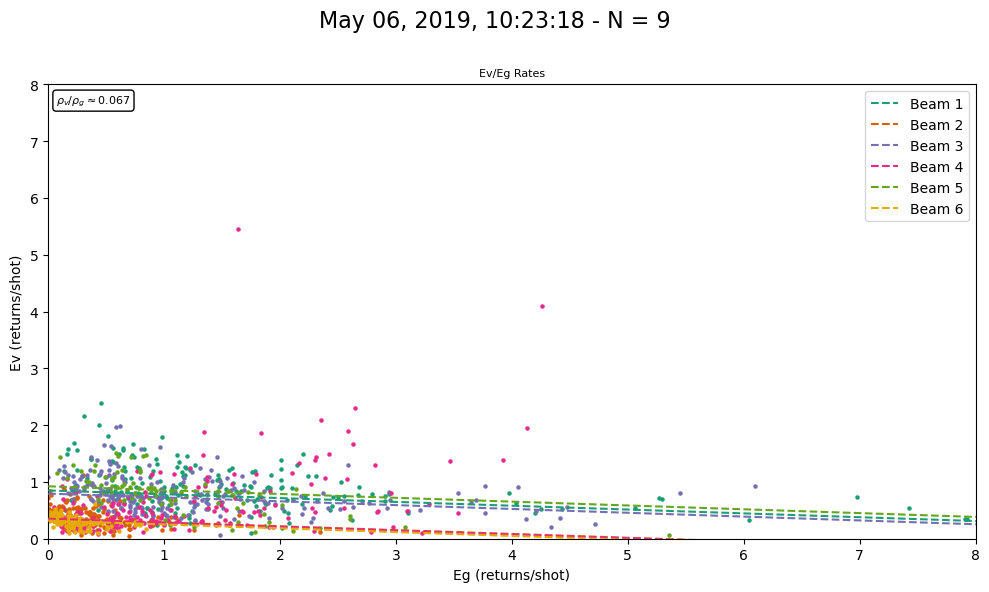

Beam 3 in file 10 has insufficient data.
Beam 4 in file 10 has insufficient data.
Beam 5 in file 10 has insufficient data.
Beam 6 in file 10 has insufficient data.


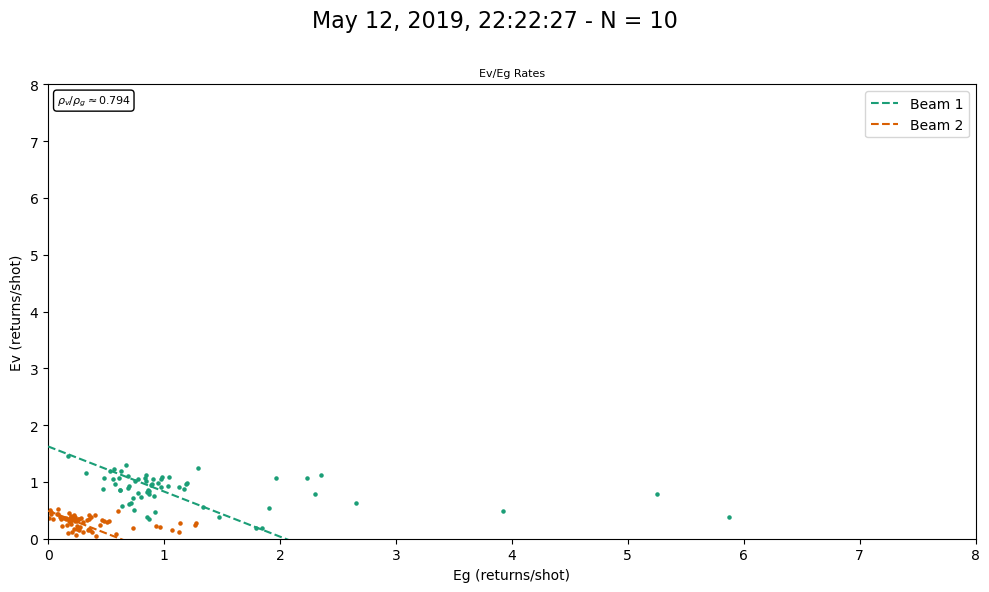

Beam 1 in file 11 has insufficient data.
Beam 2 in file 11 has insufficient data.
Beam 3 in file 11 has insufficient data.
Beam 4 in file 11 has insufficient data.
Beam 5 in file 11 has insufficient data.
Beam 6 in file 11 has insufficient data.
No beams have data in file 11, cannot regress.
Beam 1 in file 12 has insufficient data.
Beam 2 in file 12 has insufficient data.
Beam 3 in file 12 has insufficient data.
Beam 4 in file 12 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 12 has insufficient data.
Beam 6 in file 12 has insufficient data.
No beams have data in file 12, cannot regress.


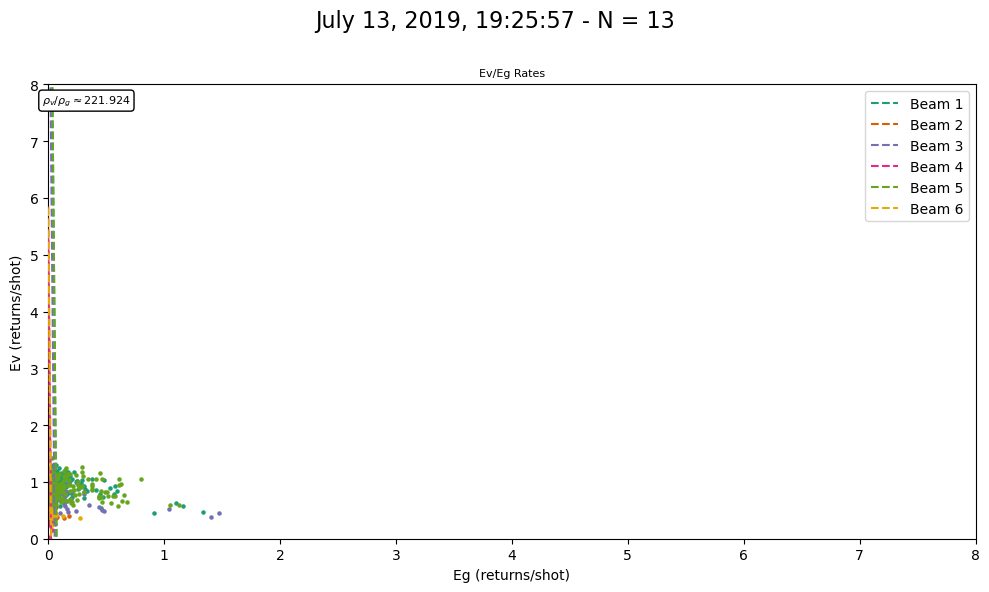

Beam 1 in file 14 has insufficient data.
Beam 2 in file 14 has insufficient data.
Beam 3 in file 14 has insufficient data.
Beam 4 in file 14 has insufficient data.
Beam 5 in file 14 has insufficient data.
Beam 6 in file 14 has insufficient data.
No beams have data in file 14, cannot regress.
Beam 2 in file 15 has insufficient data.
Beam 6 in file 15 has insufficient data.


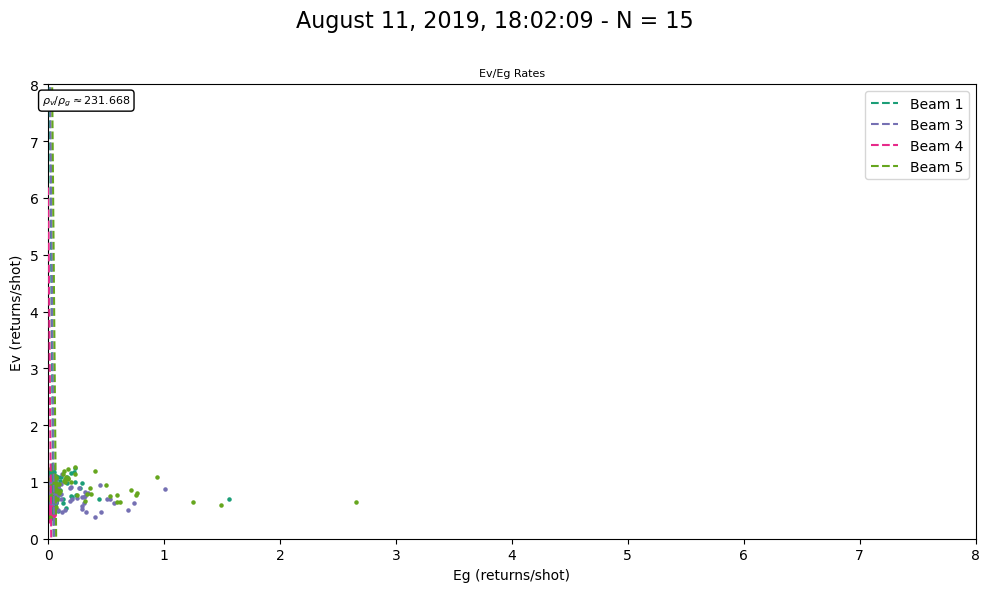

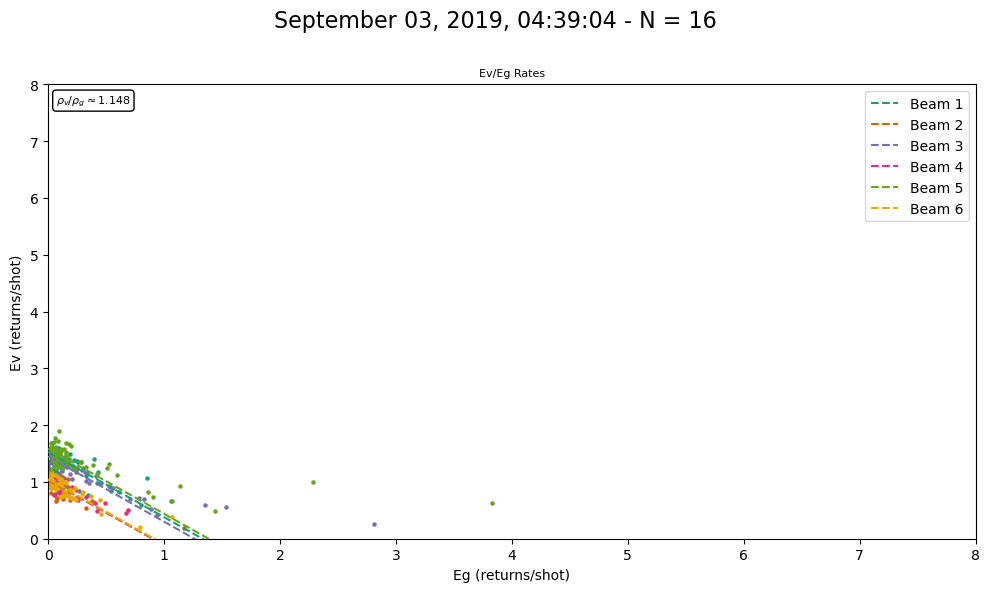

Beam 1 in file 17 has insufficient data.
Beam 2 in file 17 has insufficient data.
Beam 3 in file 17 has insufficient data.
Beam 4 in file 17 has insufficient data.
Beam 5 in file 17 has insufficient data.
Beam 6 in file 17 has insufficient data.
No beams have data in file 17, cannot regress.
Beam 1 in file 18 has insufficient data.
Beam 2 in file 18 has insufficient data.
Beam 3 in file 18 has insufficient data.
Beam 4 in file 18 has insufficient data.
Beam 5 in file 18 has insufficient data.
Beam 6 in file 18 has insufficient data.
No beams have data in file 18, cannot regress.


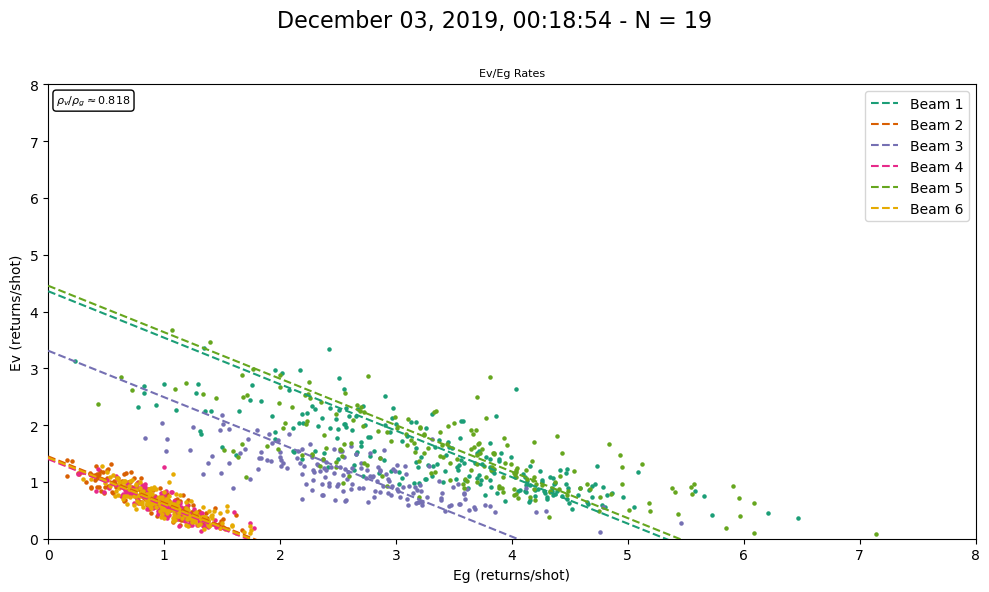

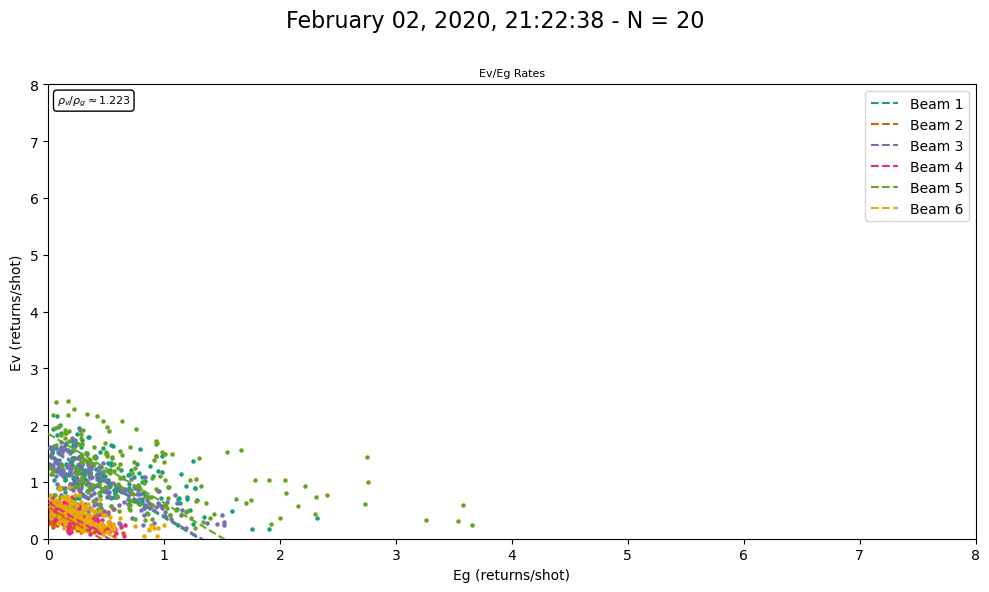

Beam 1 in file 21 has insufficient data.
Beam 2 in file 21 has insufficient data.


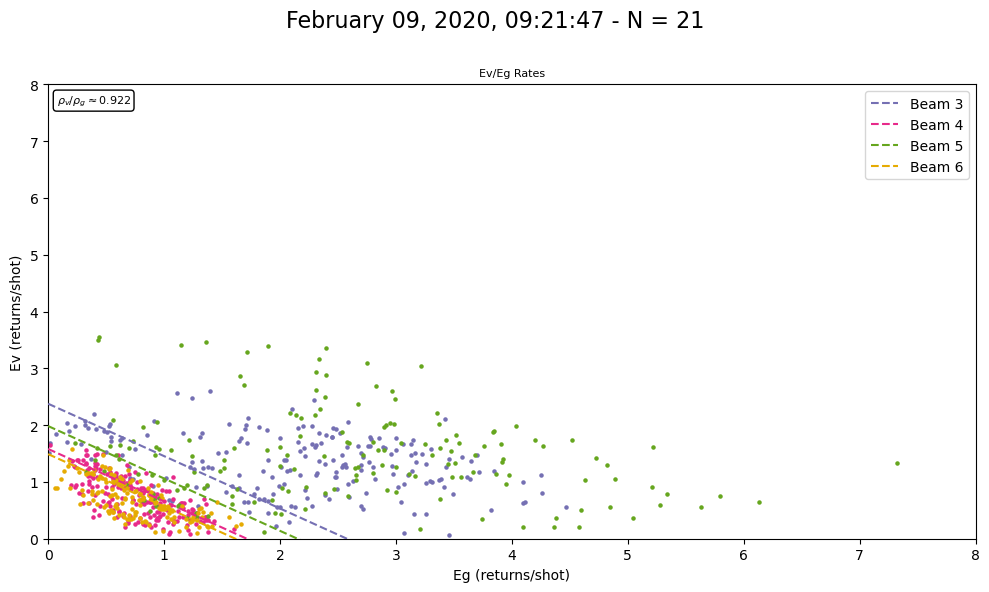

Beam 1 in file 22 has insufficient data.
Beam 2 in file 22 has insufficient data.
Beam 3 in file 22 has insufficient data.
Beam 4 in file 22 has insufficient data.
Beam 5 in file 22 has insufficient data.
Beam 6 in file 22 has insufficient data.
No beams have data in file 22, cannot regress.
Beam 1 in file 23 has insufficient data.
Beam 2 in file 23 has insufficient data.
Beam 3 in file 23 has insufficient data.
Beam 4 in file 23 has insufficient data.
Beam 5 in file 23 has insufficient data.
Beam 6 in file 23 has insufficient data.
No beams have data in file 23, cannot regress.
Beam 1 in file 24 has insufficient data.
Beam 2 in file 24 has insufficient data.
Beam 4 in file 24 has insufficient data.
Beam 6 in file 24 has insufficient data.


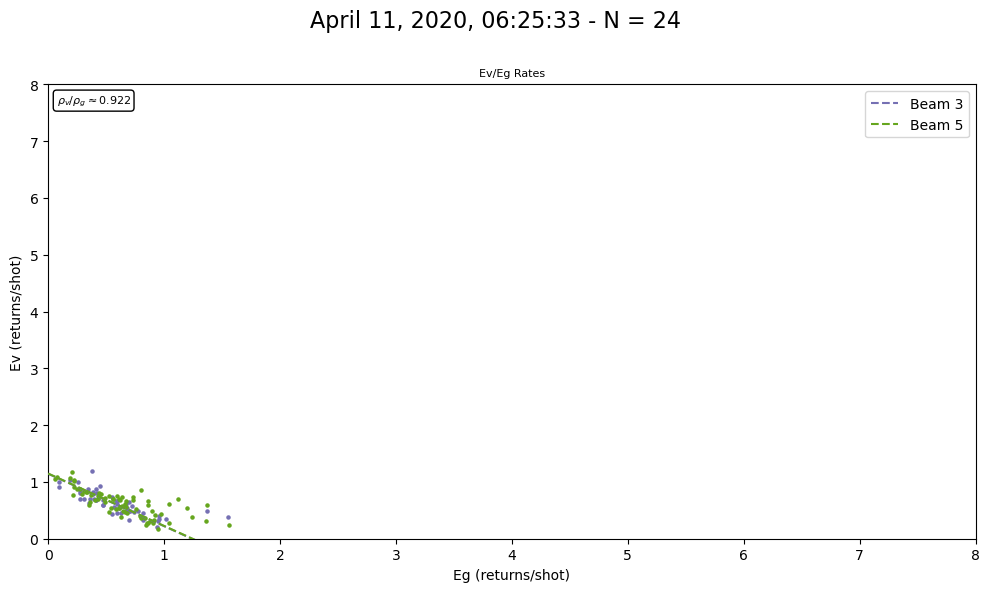

Beam 1 in file 25 has insufficient data.
Beam 2 in file 25 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 25 has insufficient data.
Beam 4 in file 25 has insufficient data.
Beam 5 in file 25 has insufficient data.
Beam 6 in file 25 has insufficient data.
No beams have data in file 25, cannot regress.
Beam 1 in file 26 has insufficient data.
Beam 2 in file 26 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 26 has insufficient data.
Beam 4 in file 26 has insufficient data.
Beam 5 in file 26 has insufficient data.
Beam 6 in file 26 has insufficient data.
No beams have data in file 26, cannot regress.
Beam 1 in file 27 has insufficient data.
Beam 2 in file 27 has insufficient data.
Beam 3 in file 27 has insufficient data.
Beam 4 in file 27 has insufficient data.
Beam 5 in file 27 has insufficient data.
Beam 6 in file 27 has insufficient data.
No beams have data in file 27, cannot regress.
Beam 1 in file 28 has insufficient data.
Beam 2 in file 28 has insufficient data.
Beam 3 in file 28 has insufficient data.
Beam 4 in file 28 has insufficient data.
Beam 5 in file 28 has insufficient data.
Beam 6 in file 28 has insufficient data.
No beams have data in file 28, cannot regress.
Beam 2 in file 29 has insufficient data.
Beam 3 in file 29 has insufficient data.
Beam 4 in file 29 has insufficient data.
Beam 6 in file 29 has insufficient data.


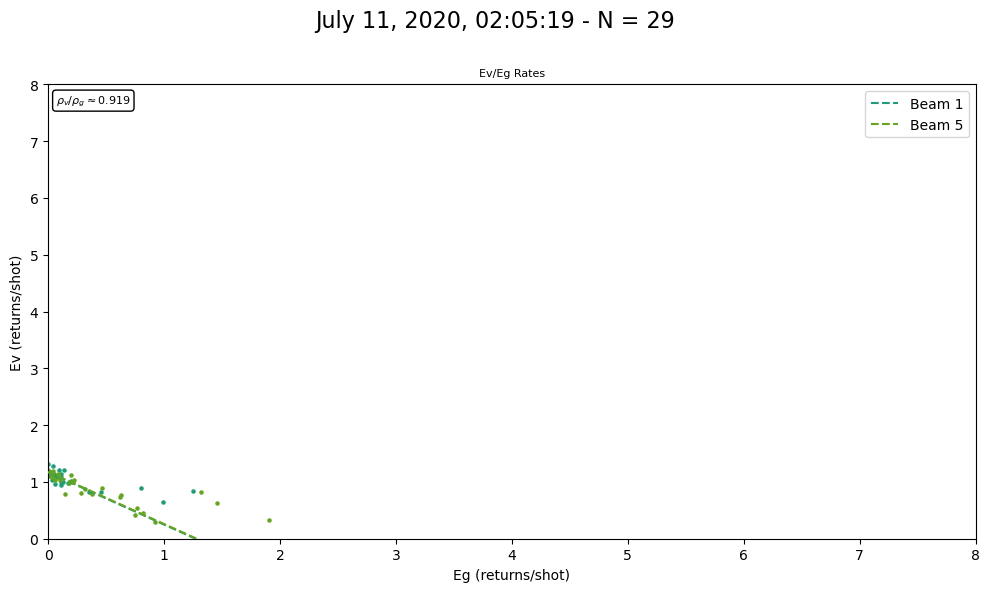

Beam 4 in file 30 has insufficient data.


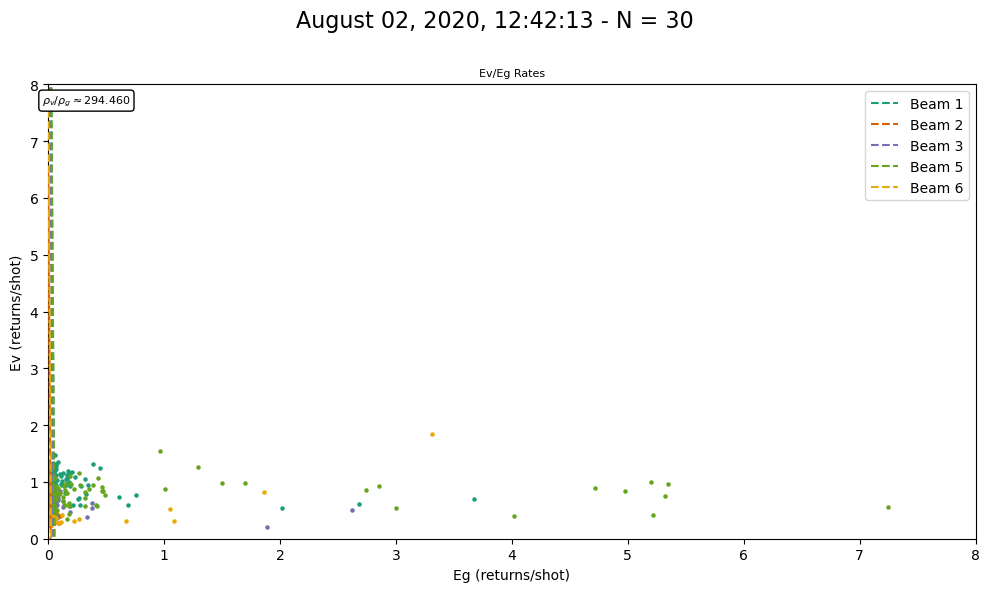

Beam 3 in file 31 has insufficient data.
Beam 4 in file 31 has insufficient data.
Beam 5 in file 31 has insufficient data.
Beam 6 in file 31 has insufficient data.


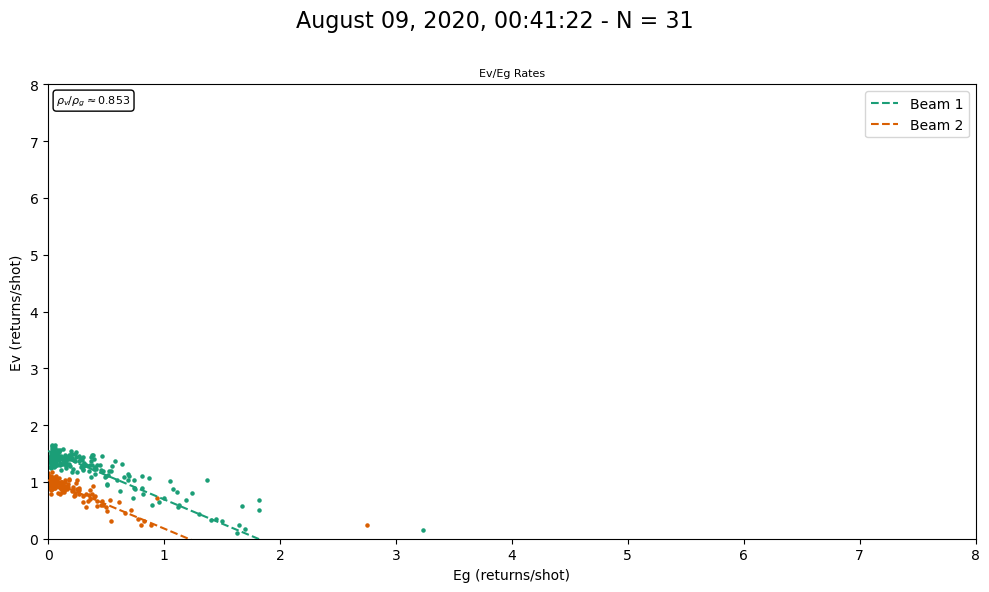

Beam 1 in file 32 has insufficient data.
Beam 2 in file 32 has insufficient data.
Beam 3 in file 32 has insufficient data.
Beam 4 in file 32 has insufficient data.
Beam 5 in file 32 has insufficient data.
Beam 6 in file 32 has insufficient data.
No beams have data in file 32, cannot regress.
Beam 1 in file 33 has insufficient data.
Beam 2 in file 33 has insufficient data.
Beam 3 in file 33 has insufficient data.
Beam 4 in file 33 has insufficient data.
Beam 5 in file 33 has insufficient data.
Beam 6 in file 33 has insufficient data.
No beams have data in file 33, cannot regress.
Beam 1 in file 34 has insufficient data.
Beam 2 in file 34 has insufficient data.
Beam 3 in file 34 has insufficient data.
Beam 4 in file 34 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 34 has insufficient data.
Beam 6 in file 34 has insufficient data.
No beams have data in file 34, cannot regress.
Beam 1 in file 35 has insufficient data.
Beam 2 in file 35 has insufficient data.
Beam 3 in file 35 has insufficient data.
Beam 4 in file 35 has insufficient data.
Beam 5 in file 35 has insufficient data.
Beam 6 in file 35 has insufficient data.
No beams have data in file 35, cannot regress.
Beam 1 in file 36 has insufficient data.
Beam 2 in file 36 has insufficient data.
Beam 3 in file 36 has insufficient data.
Beam 4 in file 36 has insufficient data.
Beam 5 in file 36 has insufficient data.
Beam 6 in file 36 has insufficient data.
No beams have data in file 36, cannot regress.
Beam 1 in file 37 has insufficient data.
Beam 2 in file 37 has insufficient data.
Beam 3 in file 37 has insufficient data.
Beam 4 in file 37 has insufficient data.
Beam 5 in file 37 has insufficient data.
Beam 6 in file 37 has insufficient data.
No beams have data in file 37, cannot r

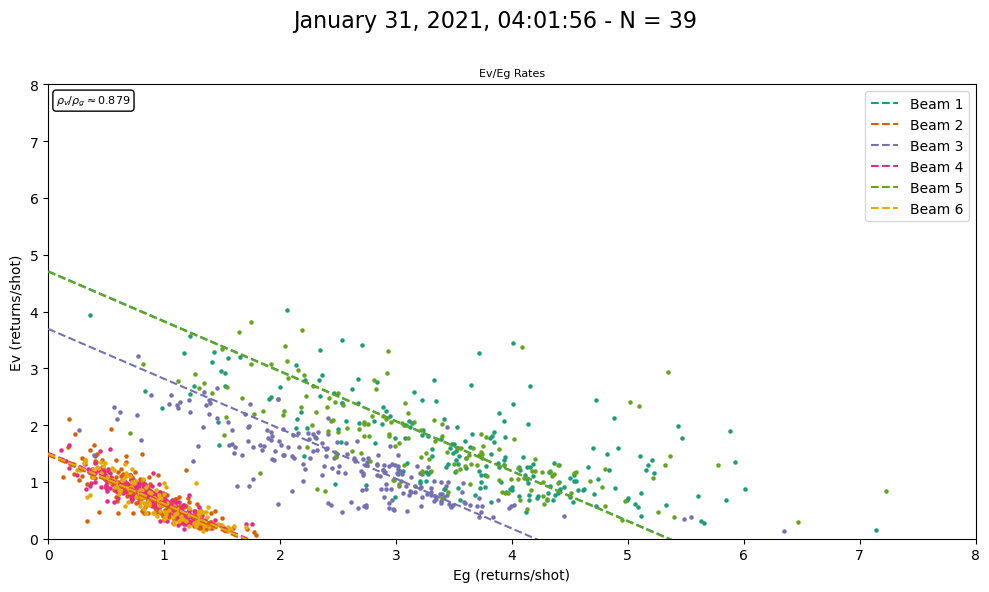

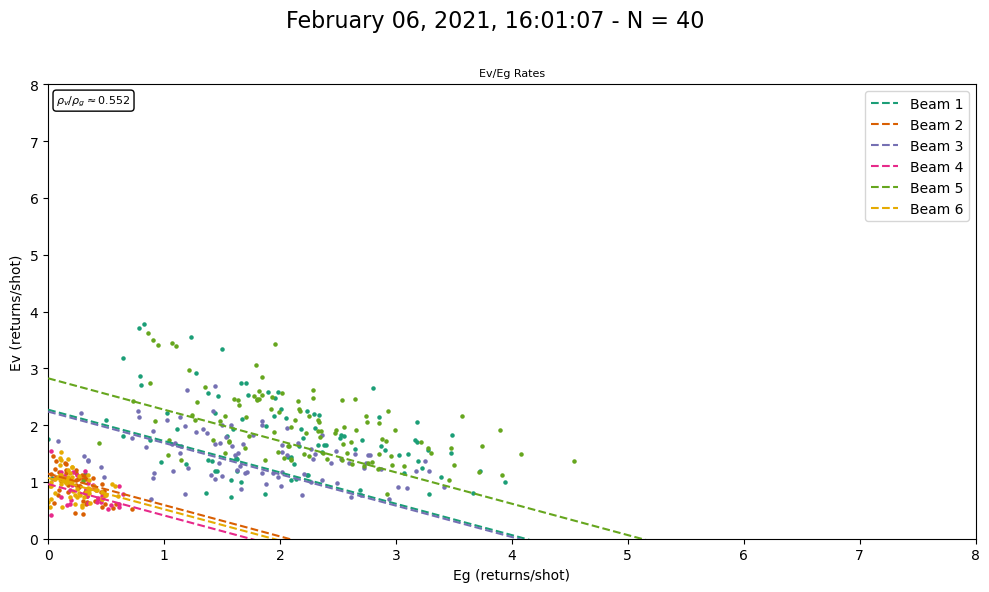

Beam 1 in file 41 has insufficient data.
Beam 2 in file 41 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 41 has insufficient data.
Beam 4 in file 41 has insufficient data.
Beam 5 in file 41 has insufficient data.
Beam 6 in file 41 has insufficient data.
No beams have data in file 41, cannot regress.
Beam 1 in file 42 has insufficient data.
Beam 2 in file 42 has insufficient data.
Beam 3 in file 42 has insufficient data.
Beam 4 in file 42 has insufficient data.
Beam 5 in file 42 has insufficient data.
Beam 6 in file 42 has insufficient data.
No beams have data in file 42, cannot regress.


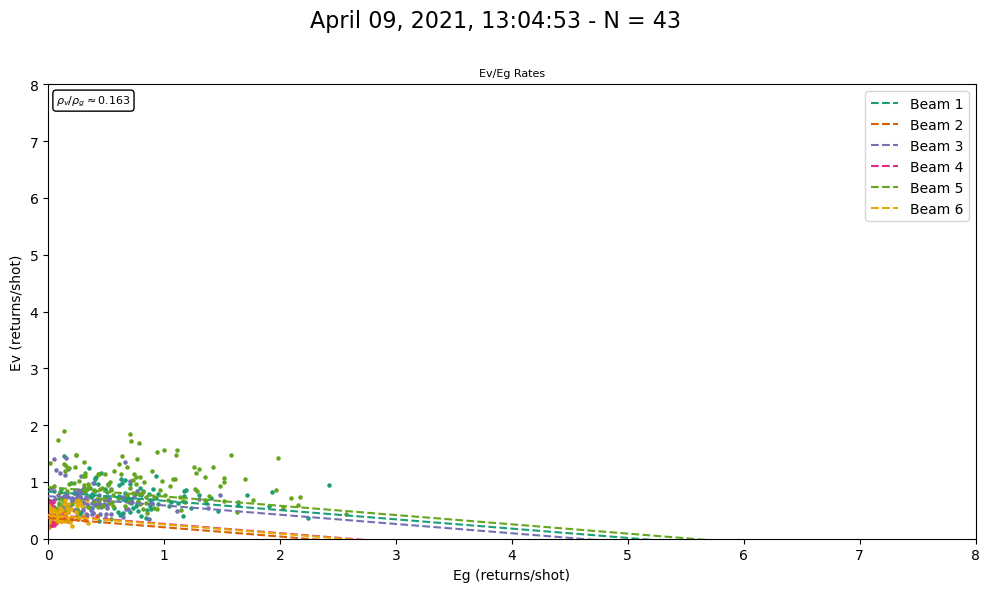

Beam 1 in file 44 has insufficient data.
Beam 2 in file 44 has insufficient data.
Beam 3 in file 44 has insufficient data.
Beam 4 in file 44 has insufficient data.
Beam 5 in file 44 has insufficient data.
Beam 6 in file 44 has insufficient data.
No beams have data in file 44, cannot regress.
Beam 1 in file 45 has insufficient data.
Beam 2 in file 45 has insufficient data.
Beam 3 in file 45 has insufficient data.
Beam 4 in file 45 has insufficient data.
Beam 5 in file 45 has insufficient data.
Beam 6 in file 45 has insufficient data.
No beams have data in file 45, cannot regress.
Beam 1 in file 46 has insufficient data.
Beam 2 in file 46 has insufficient data.
Beam 3 in file 46 has insufficient data.
Beam 4 in file 46 has insufficient data.
Beam 5 in file 46 has insufficient data.
Beam 6 in file 46 has insufficient data.
No beams have data in file 46, cannot regress.
Beam 1 in file 47 has insufficient data.
Beam 2 in file 47 has insufficient data.
Beam 3 in file 47 has insufficient data

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 5 in file 47 has insufficient data.
Beam 6 in file 47 has insufficient data.
No beams have data in file 47, cannot regress.


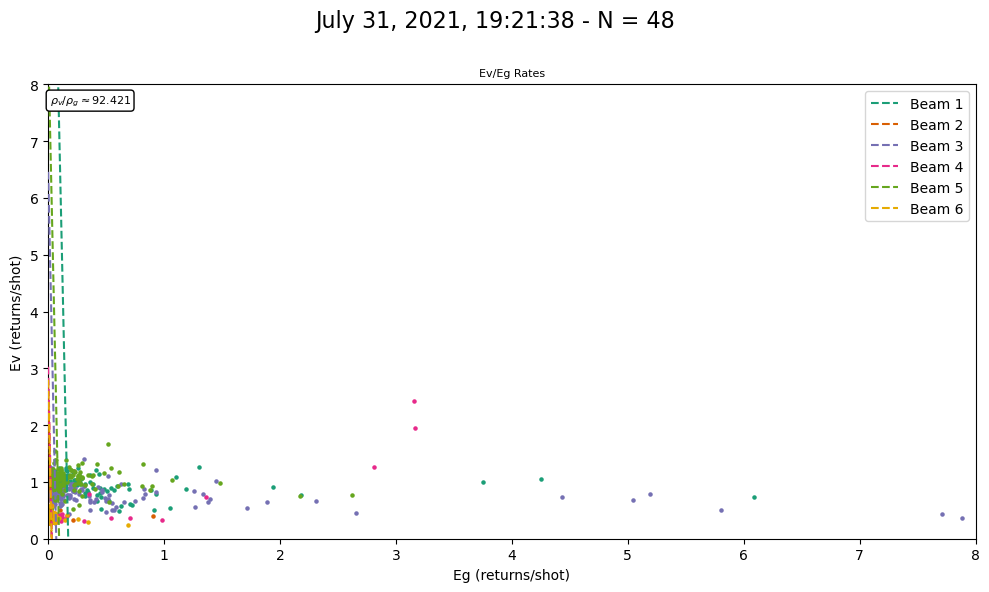

Beam 1 in file 49 has insufficient data.
Beam 2 in file 49 has insufficient data.
Beam 3 in file 49 has insufficient data.
Beam 4 in file 49 has insufficient data.
Beam 5 in file 49 has insufficient data.
Beam 6 in file 49 has insufficient data.
No beams have data in file 49, cannot regress.
Beam 1 in file 50 has insufficient data.
Beam 2 in file 50 has insufficient data.
Beam 3 in file 50 has insufficient data.
Beam 4 in file 50 has insufficient data.


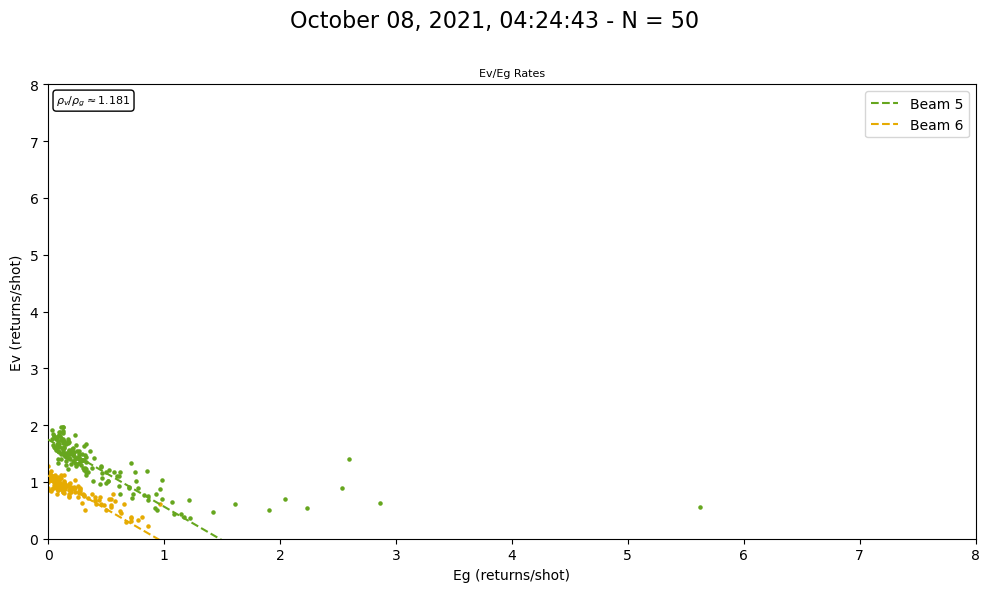

Beam 1 in file 51 has insufficient data.
Beam 2 in file 51 has insufficient data.
Beam 3 in file 51 has insufficient data.
Beam 4 in file 51 has insufficient data.
Beam 5 in file 51 has insufficient data.
Beam 6 in file 51 has insufficient data.
No beams have data in file 51, cannot regress.
Beam 1 in file 52 has insufficient data.
Beam 2 in file 52 has insufficient data.
Beam 3 in file 52 has insufficient data.
Beam 4 in file 52 has insufficient data.
Beam 5 in file 52 has insufficient data.
Beam 6 in file 52 has insufficient data.
No beams have data in file 52, cannot regress.
Beam 1 in file 53 has insufficient data.
Beam 2 in file 53 has insufficient data.
Beam 3 in file 53 has insufficient data.
Beam 4 in file 53 has insufficient data.
Beam 5 in file 53 has insufficient data.
Beam 6 in file 53 has insufficient data.
No beams have data in file 53, cannot regress.
Beam 1 in file 54 has insufficient data.
Beam 2 in file 54 has insufficient data.
Beam 3 in file 54 has insufficient data

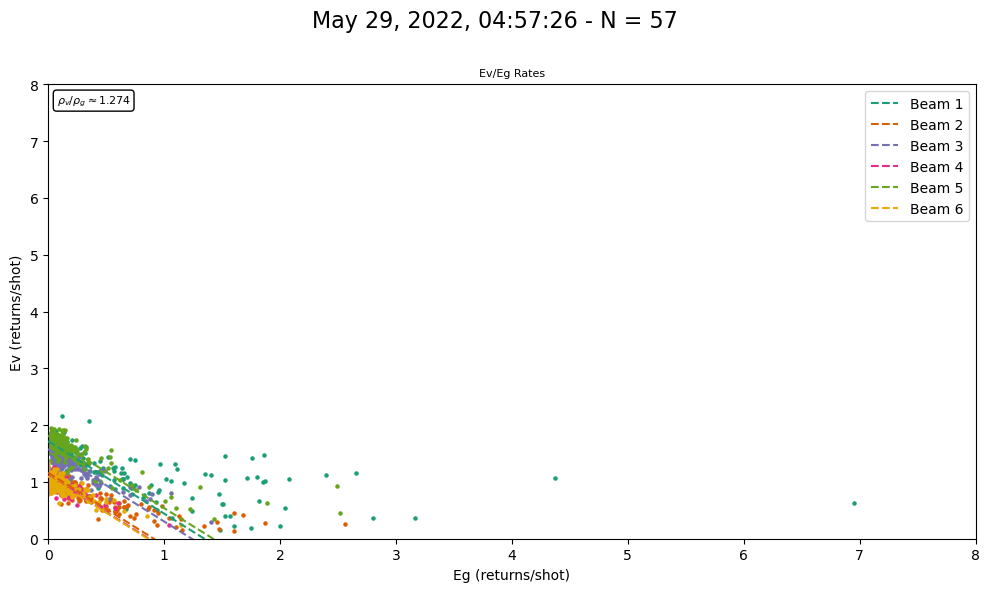

Beam 1 in file 58 has insufficient data.
Beam 2 in file 58 has insufficient data.
Beam 3 in file 58 has insufficient data.
Beam 4 in file 58 has insufficient data.
Beam 5 in file 58 has insufficient data.
Beam 6 in file 58 has insufficient data.
No beams have data in file 58, cannot regress.
Beam 1 in file 59 has insufficient data.
Beam 2 in file 59 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 59 has insufficient data.
Beam 5 in file 59 has insufficient data.
Beam 6 in file 59 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


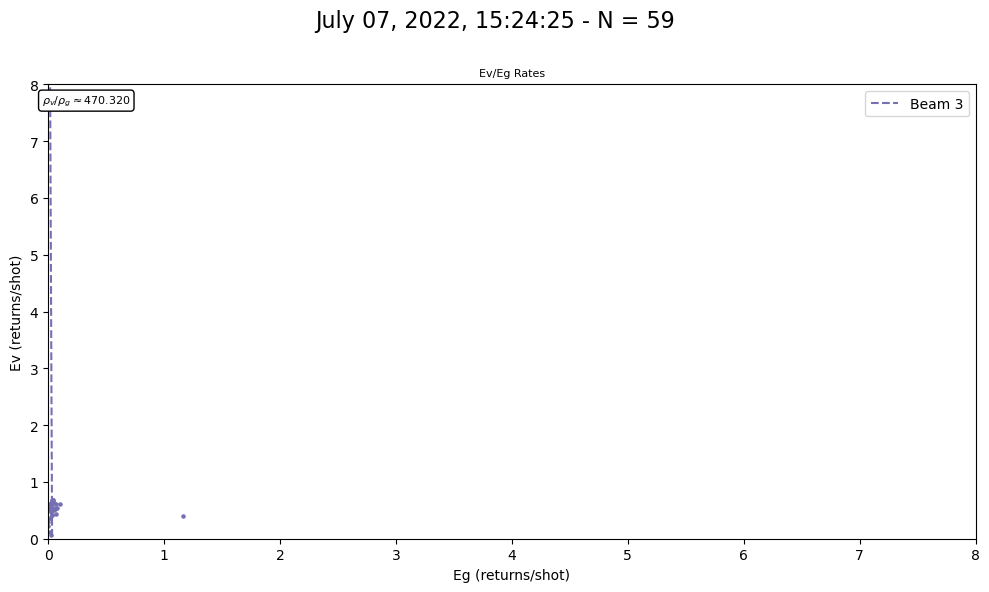

Beam 1 in file 60 has insufficient data.
Beam 2 in file 60 has insufficient data.
Beam 3 in file 60 has insufficient data.
Beam 4 in file 60 has insufficient data.


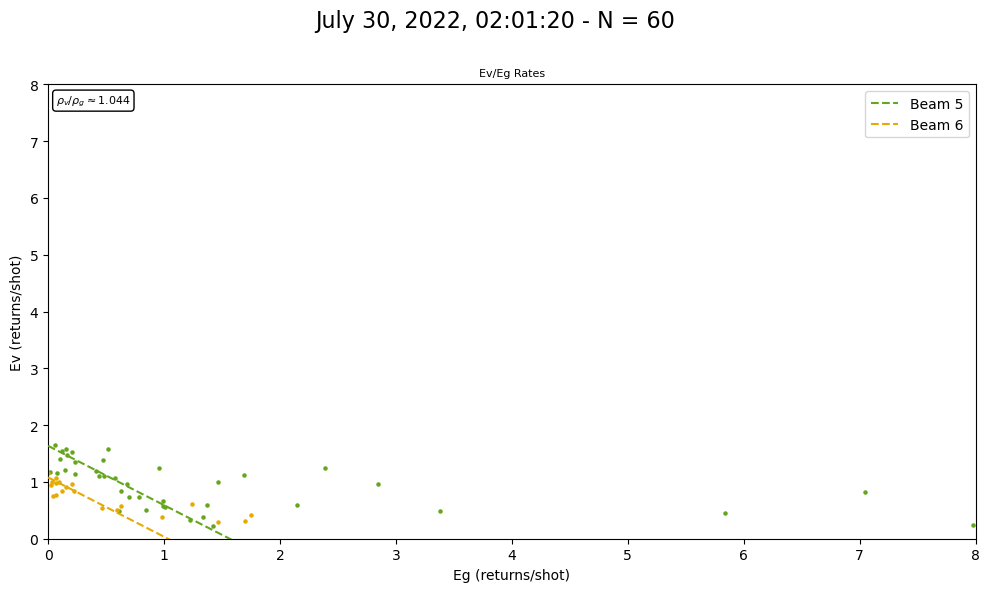

Beam 1 in file 61 has insufficient data.
Beam 2 in file 61 has insufficient data.
Beam 3 in file 61 has insufficient data.
Beam 4 in file 61 has insufficient data.
Beam 5 in file 61 has insufficient data.
Beam 6 in file 61 has insufficient data.
No beams have data in file 61, cannot regress.


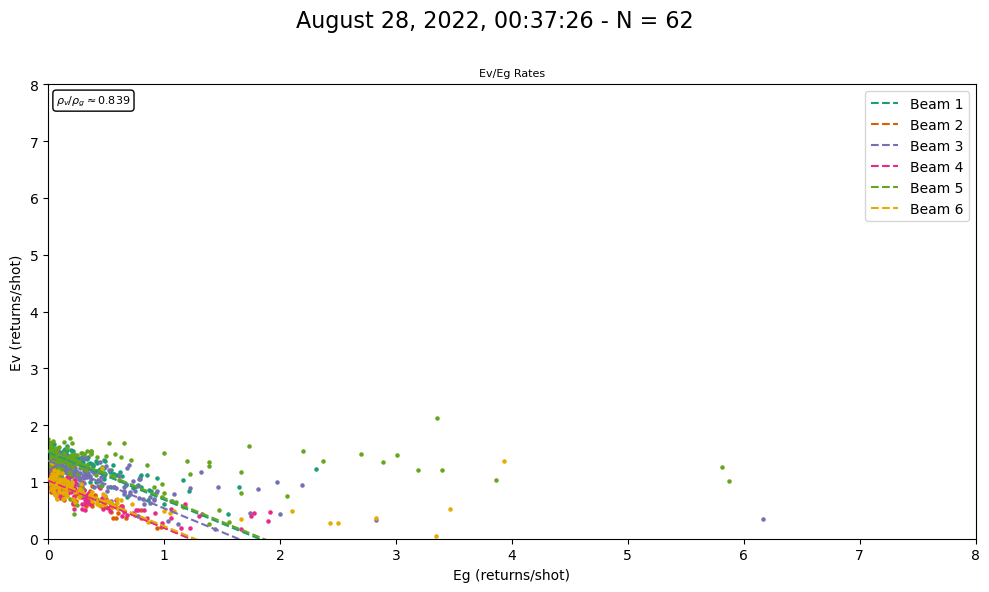

Beam 1 in file 63 has insufficient data.
Beam 2 in file 63 has insufficient data.
Beam 3 in file 63 has insufficient data.
Beam 4 in file 63 has insufficient data.
Beam 5 in file 63 has insufficient data.
Beam 6 in file 63 has insufficient data.
No beams have data in file 63, cannot regress.
Beam 1 in file 64 has insufficient data.
Beam 2 in file 64 has insufficient data.
Beam 3 in file 64 has insufficient data.
Beam 4 in file 64 has insufficient data.
Beam 5 in file 64 has insufficient data.
Beam 6 in file 64 has insufficient data.
No beams have data in file 64, cannot regress.
Beam 5 in file 65 has insufficient data.
Beam 6 in file 65 has insufficient data.


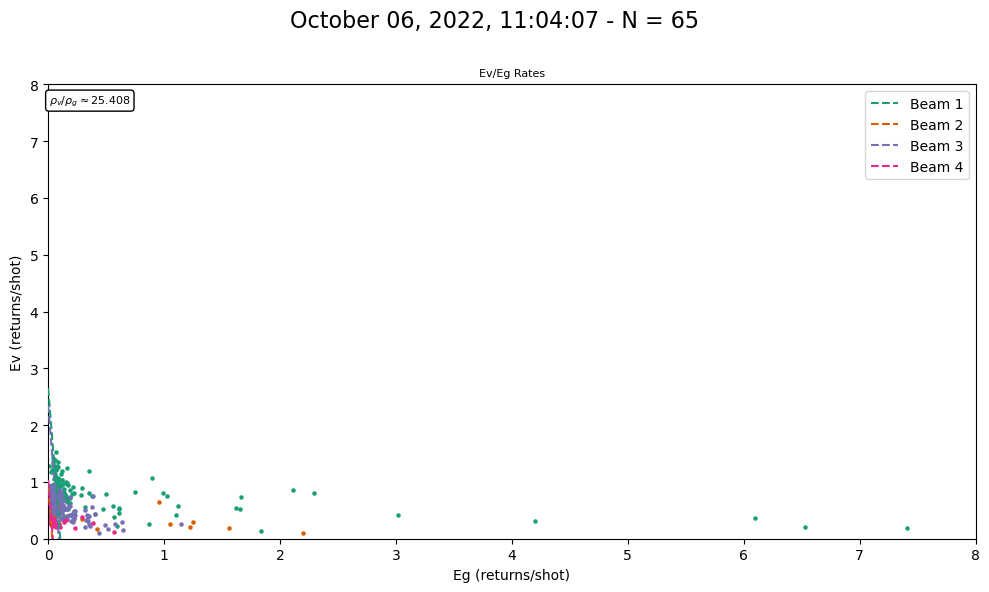

Beam 2 in file 66 has insufficient data.
Beam 4 in file 66 has insufficient data.
Beam 6 in file 66 has insufficient data.


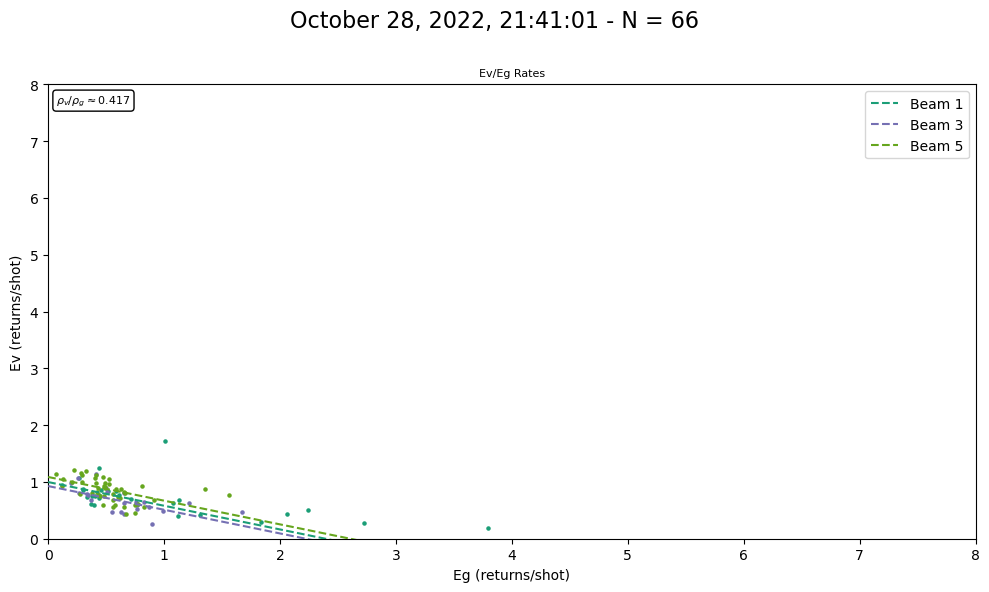

Beam 1 in file 67 has insufficient data.
Beam 2 in file 67 has insufficient data.


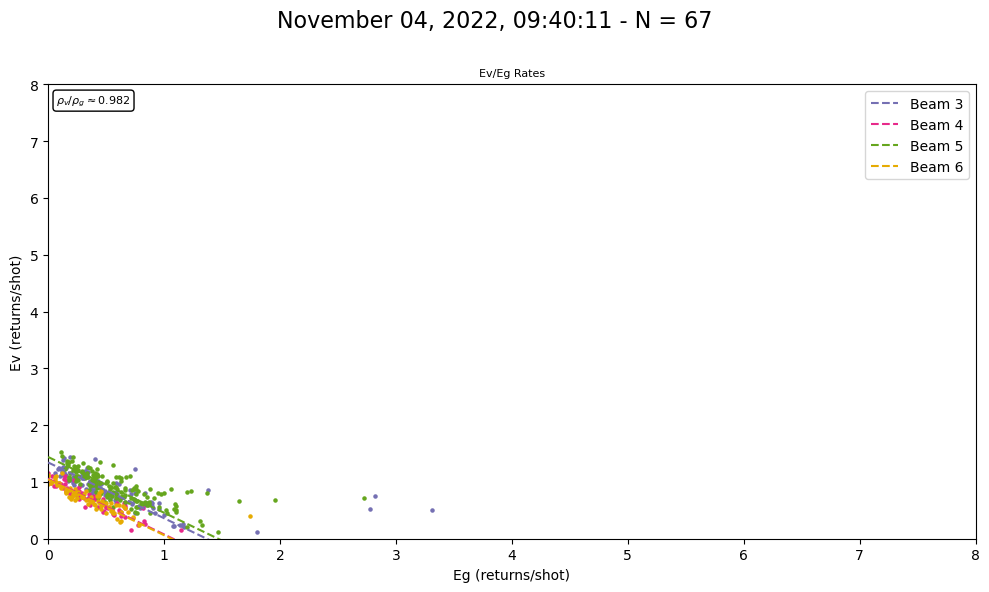

Beam 1 in file 68 has insufficient data.
Beam 2 in file 68 has insufficient data.
Beam 3 in file 68 has insufficient data.
Beam 4 in file 68 has insufficient data.
Beam 5 in file 68 has insufficient data.
Beam 6 in file 68 has insufficient data.
No beams have data in file 68, cannot regress.
Beam 1 in file 69 has insufficient data.
Beam 2 in file 69 has insufficient data.
Beam 3 in file 69 has insufficient data.
Beam 4 in file 69 has insufficient data.
Beam 5 in file 69 has insufficient data.
Beam 6 in file 69 has insufficient data.
No beams have data in file 69, cannot regress.


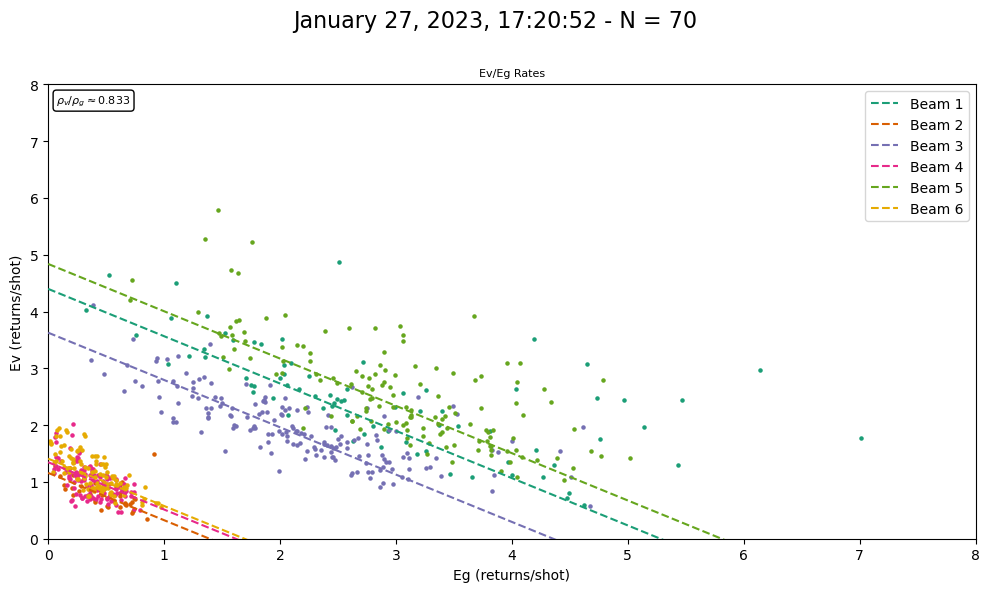

Beam 1 in file 71 has insufficient data.
Beam 2 in file 71 has insufficient data.
Beam 3 in file 71 has insufficient data.
Beam 4 in file 71 has insufficient data.


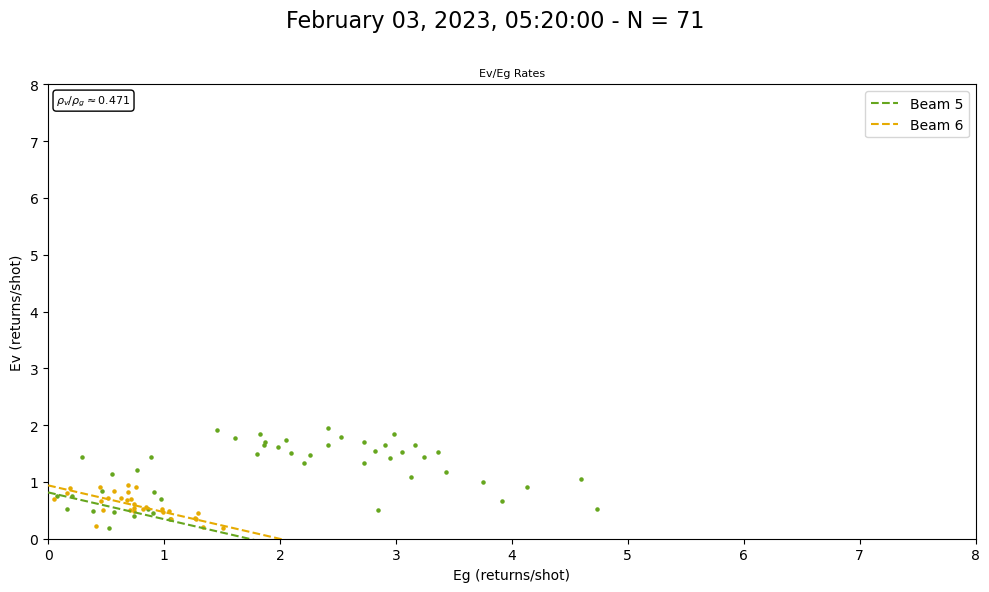

Beam 1 in file 72 has insufficient data.
Beam 2 in file 72 has insufficient data.
Beam 4 in file 72 has insufficient data.
Beam 6 in file 72 has insufficient data.


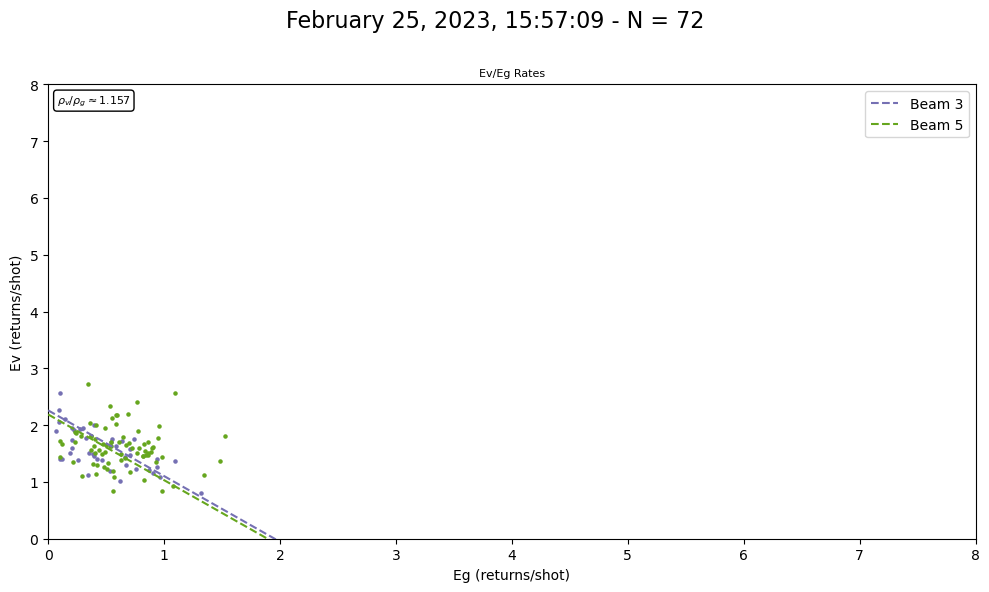

Beam 1 in file 73 has insufficient data.
Beam 2 in file 73 has insufficient data.
Beam 3 in file 73 has insufficient data.
Beam 4 in file 73 has insufficient data.
Beam 5 in file 73 has insufficient data.
Beam 6 in file 73 has insufficient data.
No beams have data in file 73, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 74 has insufficient data.
Beam 2 in file 74 has insufficient data.
Beam 3 in file 74 has insufficient data.
Beam 4 in file 74 has insufficient data.
Beam 5 in file 74 has insufficient data.
Beam 6 in file 74 has insufficient data.
No beams have data in file 74, cannot regress.
Beam 4 in file 75 has insufficient data.
Beam 5 in file 75 has insufficient data.
Beam 6 in file 75 has insufficient data.


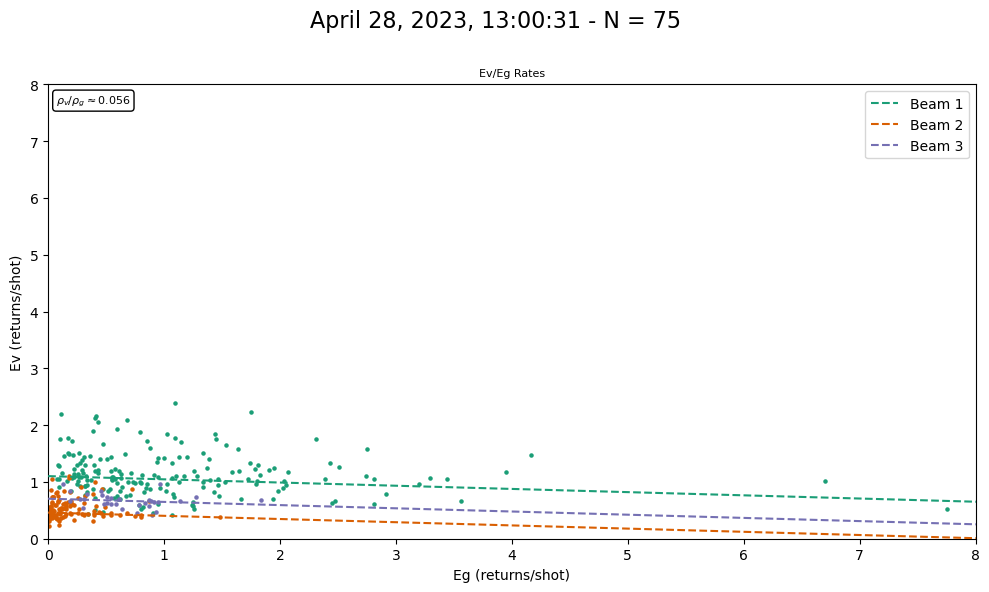

Beam 1 in file 76 has insufficient data.
Beam 2 in file 76 has insufficient data.
Beam 3 in file 76 has insufficient data.
Beam 4 in file 76 has insufficient data.
Beam 5 in file 76 has insufficient data.
Beam 6 in file 76 has insufficient data.
No beams have data in file 76, cannot regress.
Beam 1 in file 77 has insufficient data.
Beam 2 in file 77 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 77 has insufficient data.
Beam 4 in file 77 has insufficient data.
Beam 5 in file 77 has insufficient data.
Beam 6 in file 77 has insufficient data.
No beams have data in file 77, cannot regress.


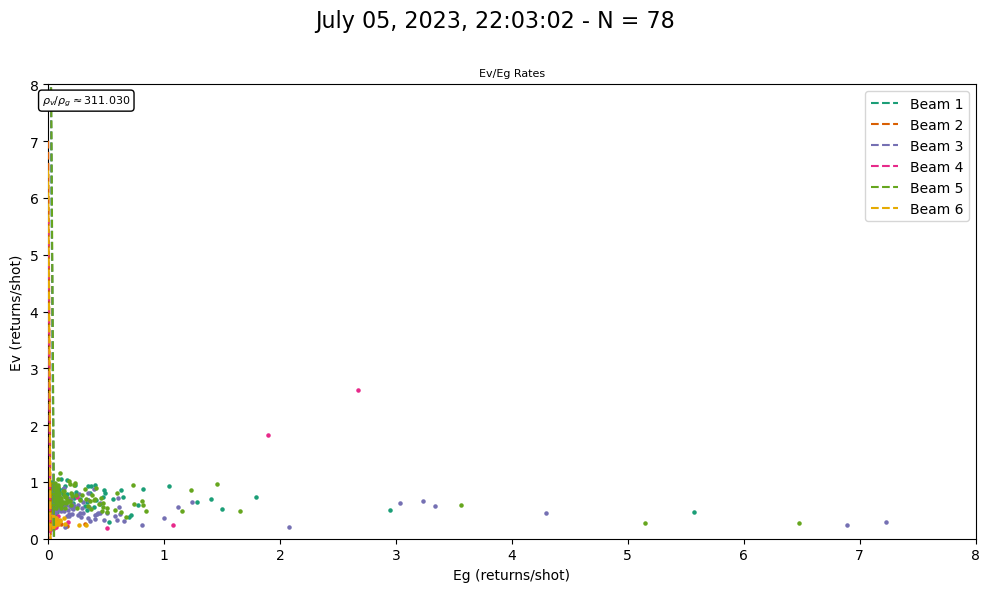

Beam 1 in file 79 has insufficient data.
Beam 2 in file 79 has insufficient data.
Beam 3 in file 79 has insufficient data.
Beam 4 in file 79 has insufficient data.
Beam 5 in file 79 has insufficient data.
Beam 6 in file 79 has insufficient data.
No beams have data in file 79, cannot regress.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 1 in file 80 has insufficient data.
Beam 2 in file 80 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 80 has insufficient data.
Beam 4 in file 80 has insufficient data.
Beam 5 in file 80 has insufficient data.
Beam 6 in file 80 has insufficient data.
No beams have data in file 80, cannot regress.
Beam 1 in file 81 has insufficient data.
Beam 2 in file 81 has insufficient data.
Beam 3 in file 81 has insufficient data.
Beam 4 in file 81 has insufficient data.
Beam 5 in file 81 has insufficient data.
Beam 6 in file 81 has insufficient data.
No beams have data in file 81, cannot regress.
Beam 1 in file 82 has insufficient data.
Beam 2 in file 82 has insufficient data.
Beam 3 in file 82 has insufficient data.
Beam 4 in file 82 has insufficient data.
Beam 5 in file 82 has insufficient data.
Beam 6 in file 82 has insufficient data.
No beams have data in file 82, cannot regress.
Beam 1 in file 83 has insufficient data.
Beam 2 in file 83 has insufficient data.
Beam 3 in file 83 has insufficient data.
Beam 4 in file 83 has insufficient data.
Beam 5 in file 83 has insufficient data

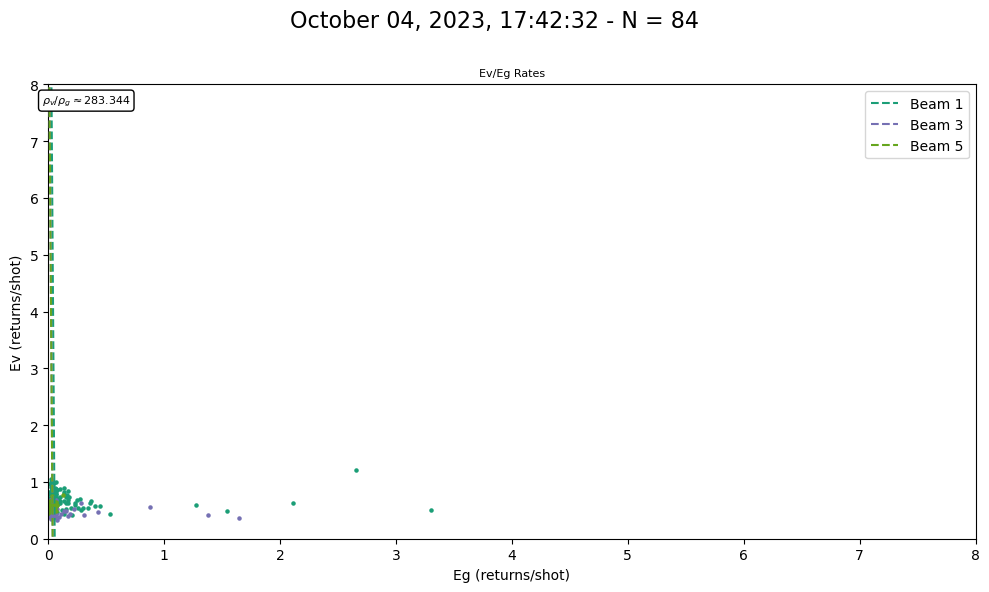

Beam 2 in file 85 has insufficient data.
Beam 4 in file 85 has insufficient data.
Beam 6 in file 85 has insufficient data.


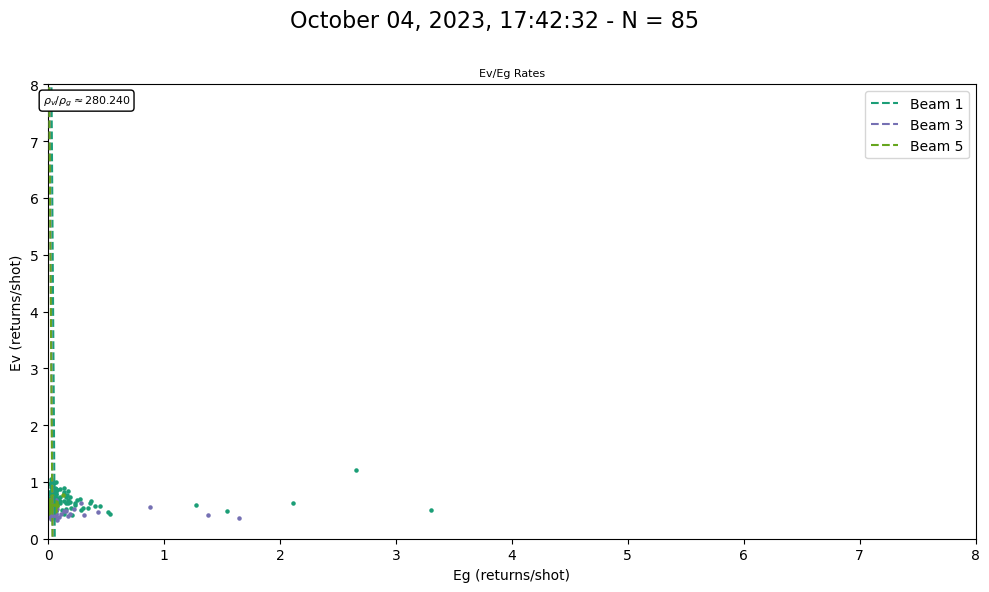

Beam 1 in file 86 has insufficient data.
Beam 2 in file 86 has insufficient data.
Beam 3 in file 86 has insufficient data.
Beam 4 in file 86 has insufficient data.


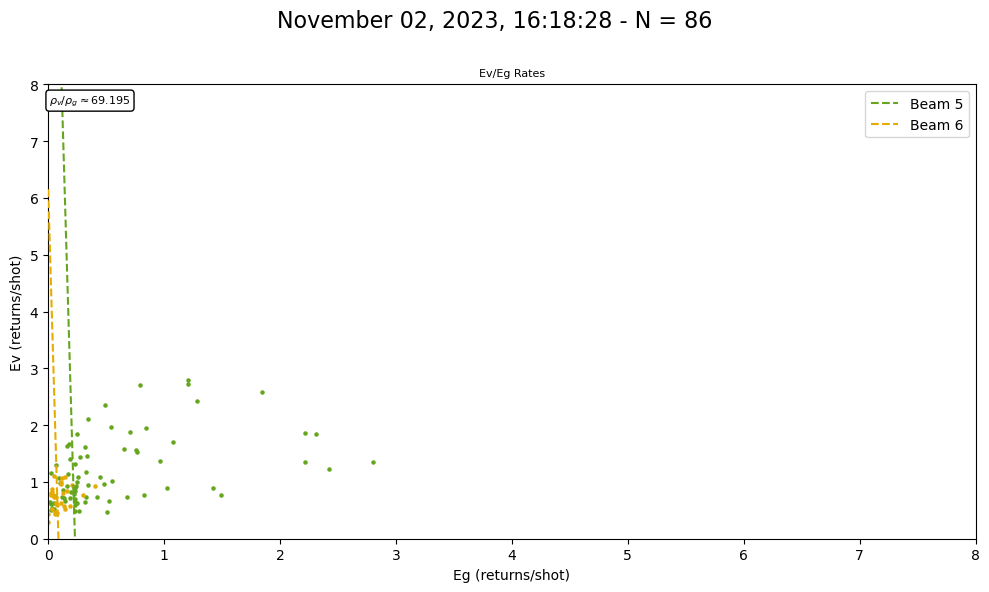

Beam 5 in file 87 has insufficient data.
Beam 6 in file 87 has insufficient data.


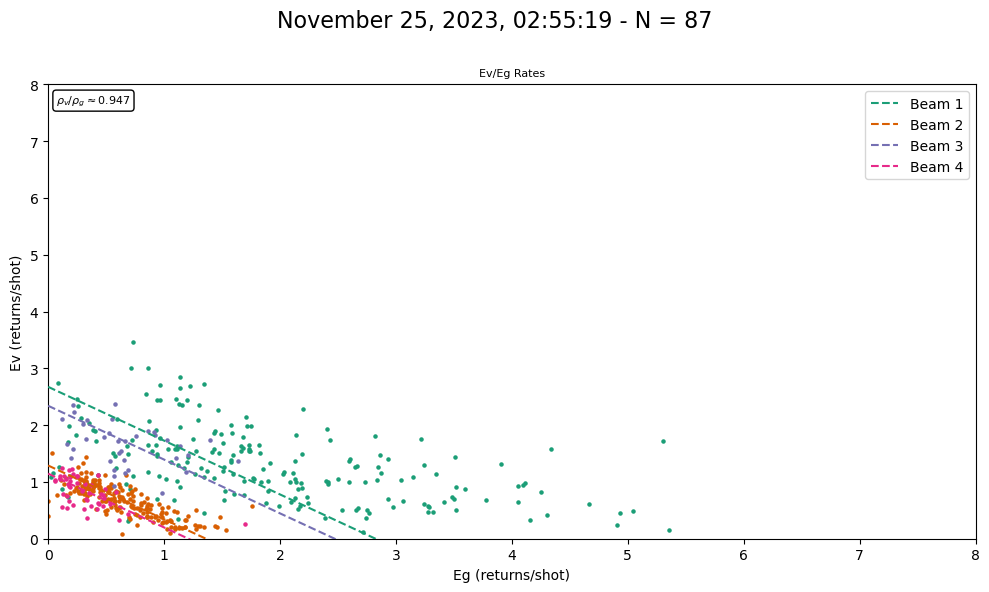

In [13]:
from scripts.parallel import *

# dirpath = 'R:/data/sodankyla_full/'
dirpath = '../data_store/data/lacclair/'

# data = []

all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

coords = (-71.6696, 46.9521)

# problematic: 4!, 5!, 12!, 

for i in range(N):
    data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
                         graph_detail=1, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1, altitude = 313)
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
    #                      graph_detail=1, loss='linear',file_index=i, keep_flagged=1, opsys='bad',f_scale=.05, altitude = 313)
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
    #                      graph_detail=1, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.01, altitude = 313)
#     print(data)

# Torgnon

Beam 1 in file 0 has insufficient data.
Beam 2 in file 0 has insufficient data.
Beam 3 in file 0 has insufficient data.
Beam 4 in file 0 has insufficient data.
Beam 5 in file 0 has insufficient data.
Beam 6 in file 0 has insufficient data.
No beams have data in file 0, cannot regress.
Beam 1 in file 1 has insufficient data.
Beam 2 in file 1 has insufficient data.
Beam 3 in file 1 has insufficient data.
Beam 4 in file 1 has insufficient data.
Beam 5 in file 1 has insufficient data.
Beam 6 in file 1 has insufficient data.
No beams have data in file 1, cannot regress.
Beam 1 in file 2 has insufficient data.
Beam 2 in file 2 has insufficient data.
Beam 3 in file 2 has insufficient data.
Beam 4 in file 2 has insufficient data.
Beam 5 in file 2 has insufficient data.
Beam 6 in file 2 has insufficient data.
No beams have data in file 2, cannot regress.
Beam 1 in file 3 has insufficient data.
Beam 2 in file 3 has insufficient data.
Beam 3 in file 3 has insufficient data.
Beam 4 in file 3 has i

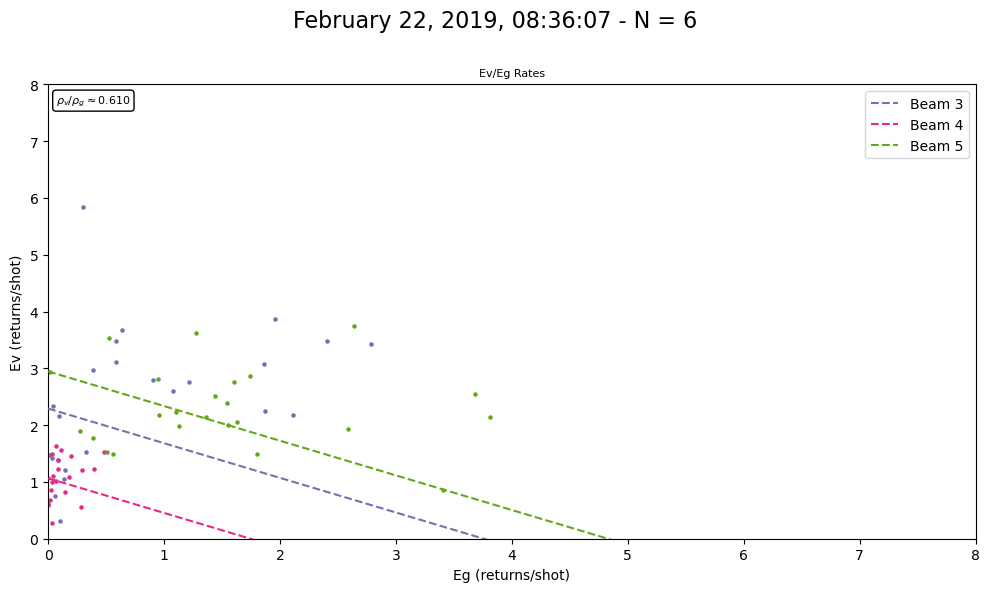

Beam 3 in file 7 has insufficient data.
Beam 4 in file 7 has insufficient data.
Beam 5 in file 7 has insufficient data.
Beam 6 in file 7 has insufficient data.


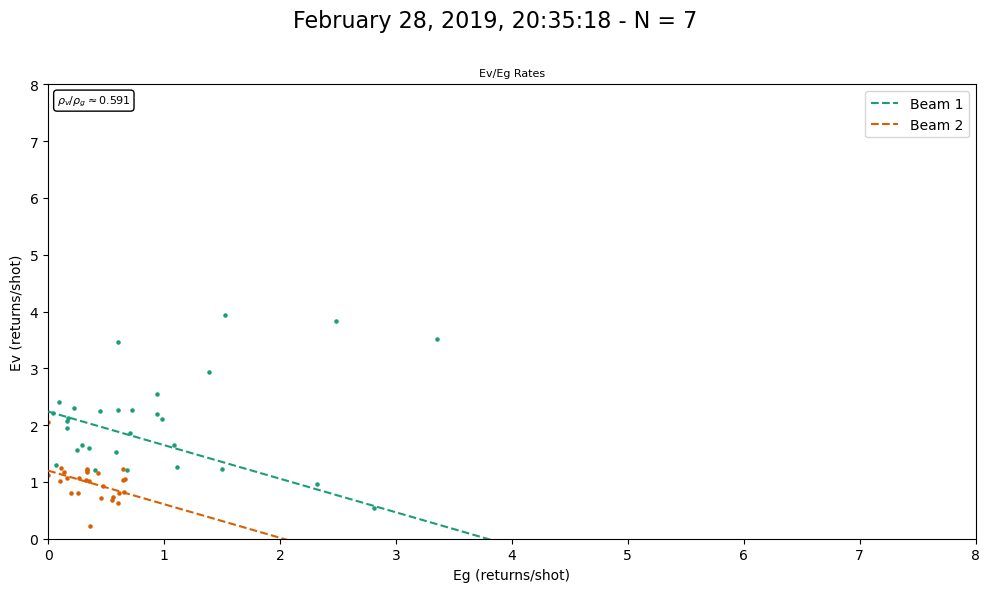

Beam 1 in file 8 has insufficient data.
Beam 2 in file 8 has insufficient data.
Beam 3 in file 8 has insufficient data.
Beam 4 in file 8 has insufficient data.
Beam 5 in file 8 has insufficient data.
Beam 6 in file 8 has insufficient data.
No beams have data in file 8, cannot regress.
Beam 1 in file 9 has insufficient data.
Beam 2 in file 9 has insufficient data.
Beam 3 in file 9 has insufficient data.
Beam 4 in file 9 has insufficient data.
Beam 5 in file 9 has insufficient data.
Beam 6 in file 9 has insufficient data.
No beams have data in file 9, cannot regress.
Beam 1 in file 10 has insufficient data.
Beam 2 in file 10 has insufficient data.
Beam 3 in file 10 has insufficient data.
Beam 4 in file 10 has insufficient data.
Beam 5 in file 10 has insufficient data.
Beam 6 in file 10 has insufficient data.
No beams have data in file 10, cannot regress.
Beam 1 in file 11 has insufficient data.
Beam 2 in file 11 has insufficient data.
Beam 3 in file 11 has insufficient data.
Beam 4 in fi

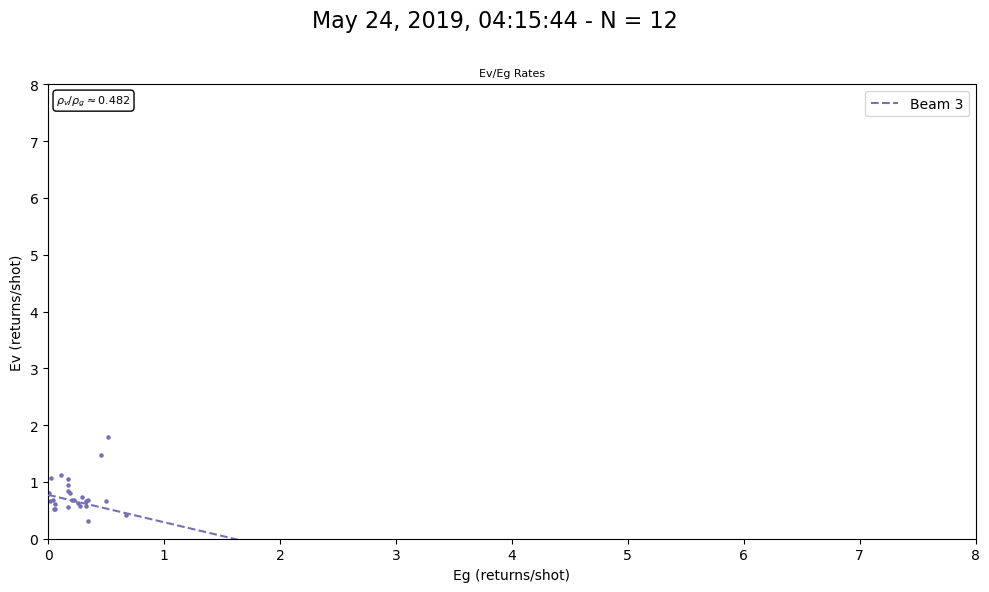

Beam 1 in file 13 has insufficient data.
Beam 2 in file 13 has insufficient data.
Beam 4 in file 13 has insufficient data.
Beam 5 in file 13 has insufficient data.
Beam 6 in file 13 has insufficient data.


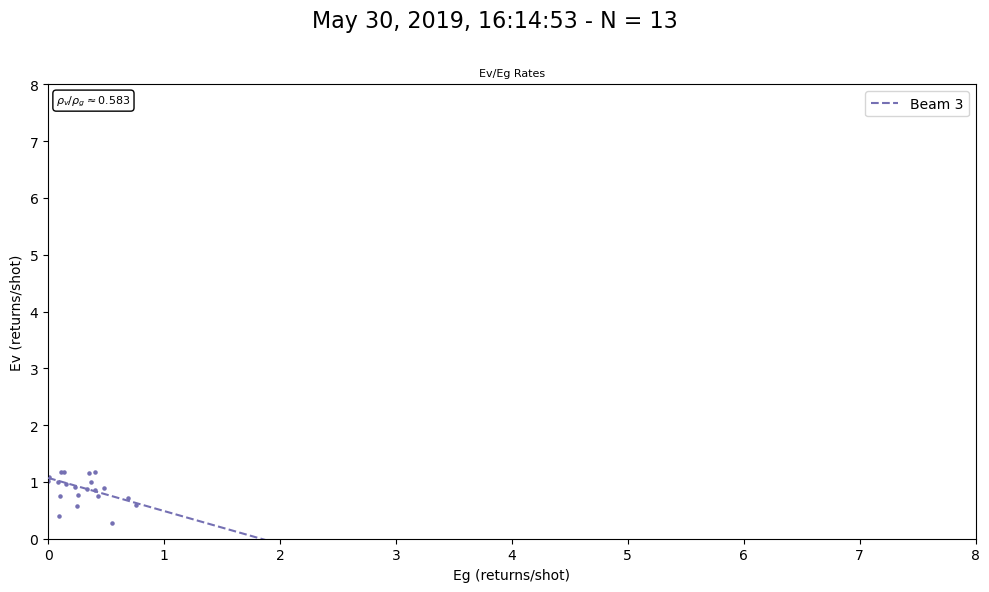

Beam 2 in file 14 has insufficient data.
Beam 3 in file 14 has insufficient data.
Beam 4 in file 14 has insufficient data.
Beam 5 in file 14 has insufficient data.
Beam 6 in file 14 has insufficient data.


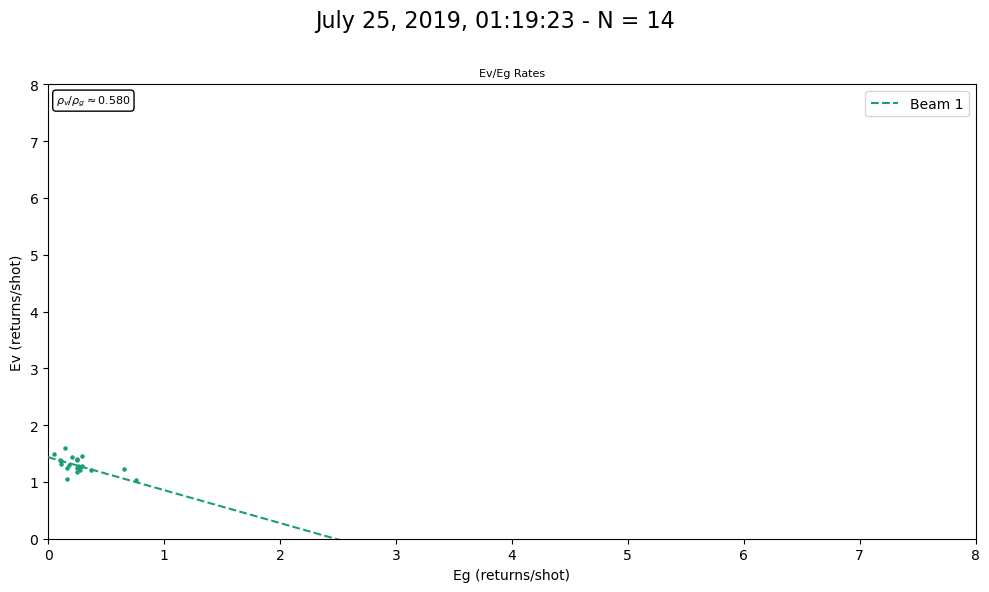

Beam 1 in file 15 has insufficient data.
Beam 2 in file 15 has insufficient data.
Beam 3 in file 15 has insufficient data.
Beam 4 in file 15 has insufficient data.
Beam 5 in file 15 has insufficient data.
Beam 6 in file 15 has insufficient data.
No beams have data in file 15, cannot regress.
Beam 2 in file 16 has insufficient data.
Beam 3 in file 16 has insufficient data.
Beam 5 in file 16 has insufficient data.
Beam 6 in file 16 has insufficient data.


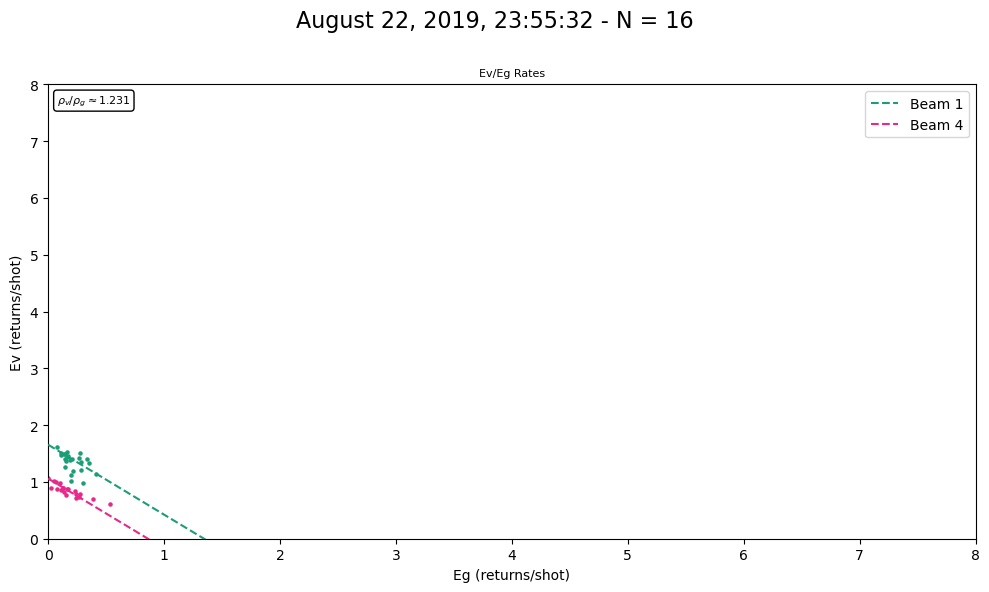

Beam 1 in file 17 has insufficient data.
Beam 2 in file 17 has insufficient data.
Beam 3 in file 17 has insufficient data.
Beam 4 in file 17 has insufficient data.
Beam 5 in file 17 has insufficient data.
Beam 6 in file 17 has insufficient data.
No beams have data in file 17, cannot regress.
Beam 1 in file 18 has insufficient data.
Beam 2 in file 18 has insufficient data.
Beam 3 in file 18 has insufficient data.
Beam 4 in file 18 has insufficient data.
Beam 5 in file 18 has insufficient data.
Beam 6 in file 18 has insufficient data.
No beams have data in file 18, cannot regress.
Beam 1 in file 19 has insufficient data.
Beam 2 in file 19 has insufficient data.
Beam 3 in file 19 has insufficient data.
Beam 4 in file 19 has insufficient data.
Beam 6 in file 19 has insufficient data.


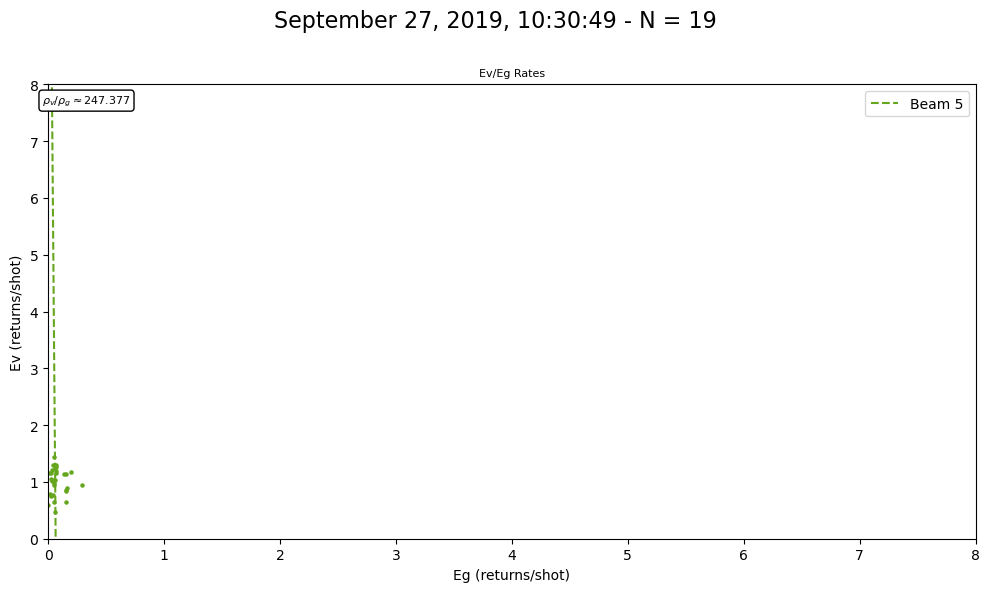

Beam 1 in file 20 has insufficient data.
Beam 2 in file 20 has insufficient data.
Beam 3 in file 20 has insufficient data.
Beam 4 in file 20 has insufficient data.
Beam 5 in file 20 has insufficient data.
Beam 6 in file 20 has insufficient data.
No beams have data in file 20, cannot regress.
Beam 1 in file 21 has insufficient data.
Beam 2 in file 21 has insufficient data.
Beam 3 in file 21 has insufficient data.
Beam 4 in file 21 has insufficient data.
Beam 5 in file 21 has insufficient data.
Beam 6 in file 21 has insufficient data.
No beams have data in file 21, cannot regress.
Beam 1 in file 22 has insufficient data.
Beam 2 in file 22 has insufficient data.
Beam 3 in file 22 has insufficient data.
Beam 4 in file 22 has insufficient data.
Beam 5 in file 22 has insufficient data.
Beam 6 in file 22 has insufficient data.
No beams have data in file 22, cannot regress.
Beam 1 in file 23 has insufficient data.
Beam 2 in file 23 has insufficient data.
Beam 3 in file 23 has insufficient data

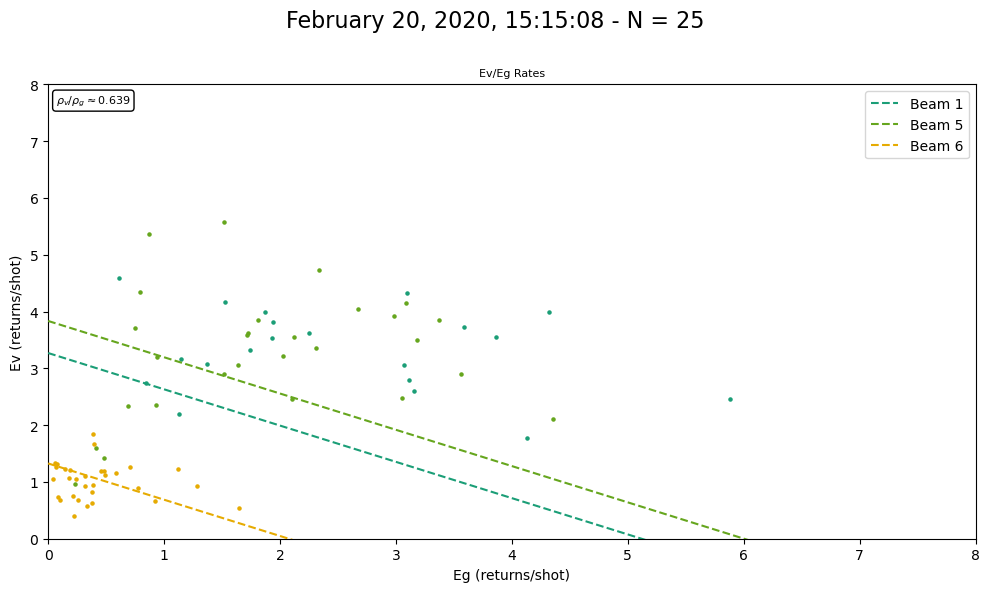

Beam 3 in file 26 has insufficient data.
Beam 4 in file 26 has insufficient data.


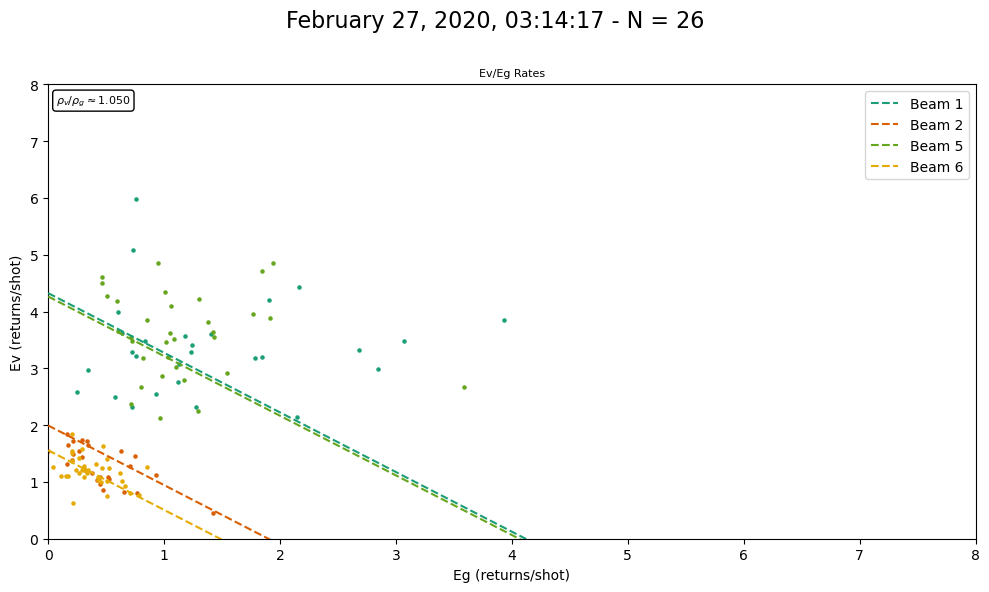

Beam 1 in file 27 has insufficient data.
Beam 2 in file 27 has insufficient data.
Beam 3 in file 27 has insufficient data.
Beam 4 in file 27 has insufficient data.
Beam 5 in file 27 has insufficient data.
Beam 6 in file 27 has insufficient data.
No beams have data in file 27, cannot regress.
Beam 1 in file 28 has insufficient data.
Beam 2 in file 28 has insufficient data.
Beam 3 in file 28 has insufficient data.
Beam 4 in file 28 has insufficient data.
Beam 5 in file 28 has insufficient data.
Beam 6 in file 28 has insufficient data.
No beams have data in file 28, cannot regress.
Beam 1 in file 29 has insufficient data.
Beam 2 in file 29 has insufficient data.
Beam 3 in file 29 has insufficient data.
Beam 4 in file 29 has insufficient data.
Beam 5 in file 29 has insufficient data.
Beam 6 in file 29 has insufficient data.
No beams have data in file 29, cannot regress.
Beam 1 in file 30 has insufficient data.
Beam 2 in file 30 has insufficient data.
Beam 3 in file 30 has insufficient data

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 3 in file 35 has insufficient data.
Beam 4 in file 35 has insufficient data.
Beam 5 in file 35 has insufficient data.
Beam 6 in file 35 has insufficient data.
No beams have data in file 35, cannot regress.
Beam 1 in file 36 has insufficient data.
Beam 2 in file 36 has insufficient data.
Beam 3 in file 36 has insufficient data.
Beam 4 in file 36 has insufficient data.
Beam 5 in file 36 has insufficient data.
Beam 6 in file 36 has insufficient data.
No beams have data in file 36, cannot regress.
Beam 3 in file 37 has insufficient data.
Beam 4 in file 37 has insufficient data.
Beam 5 in file 37 has insufficient data.
Beam 6 in file 37 has insufficient data.


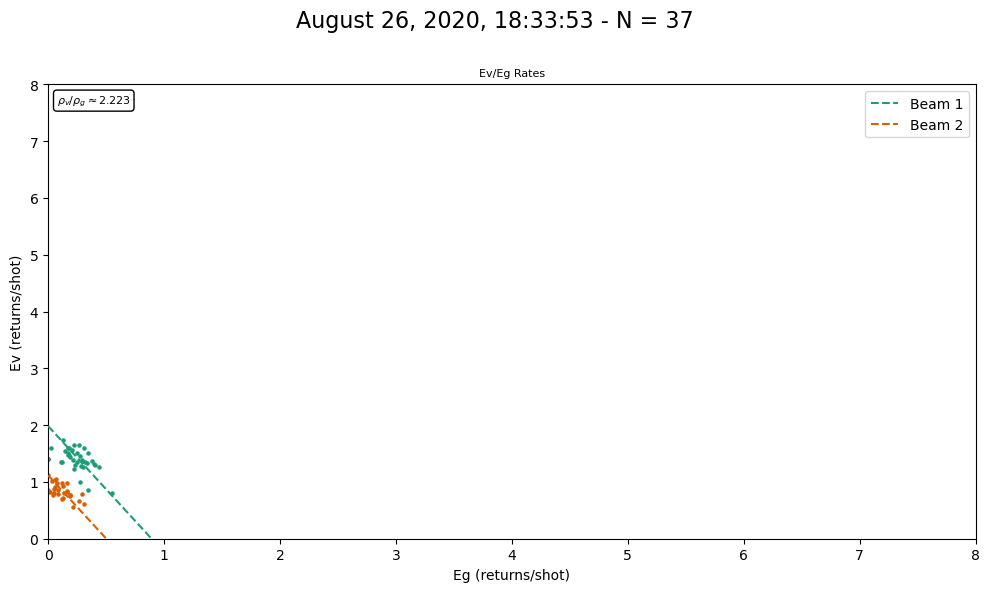

Beam 1 in file 38 has insufficient data.
Beam 2 in file 38 has insufficient data.
Beam 3 in file 38 has insufficient data.
Beam 4 in file 38 has insufficient data.
Beam 5 in file 38 has insufficient data.
Beam 6 in file 38 has insufficient data.
No beams have data in file 38, cannot regress.
Beam 1 in file 39 has insufficient data.
Beam 2 in file 39 has insufficient data.
Beam 3 in file 39 has insufficient data.
Beam 4 in file 39 has insufficient data.
Beam 5 in file 39 has insufficient data.
Beam 6 in file 39 has insufficient data.
No beams have data in file 39, cannot regress.
Beam 1 in file 40 has insufficient data.
Beam 2 in file 40 has insufficient data.
Beam 5 in file 40 has insufficient data.


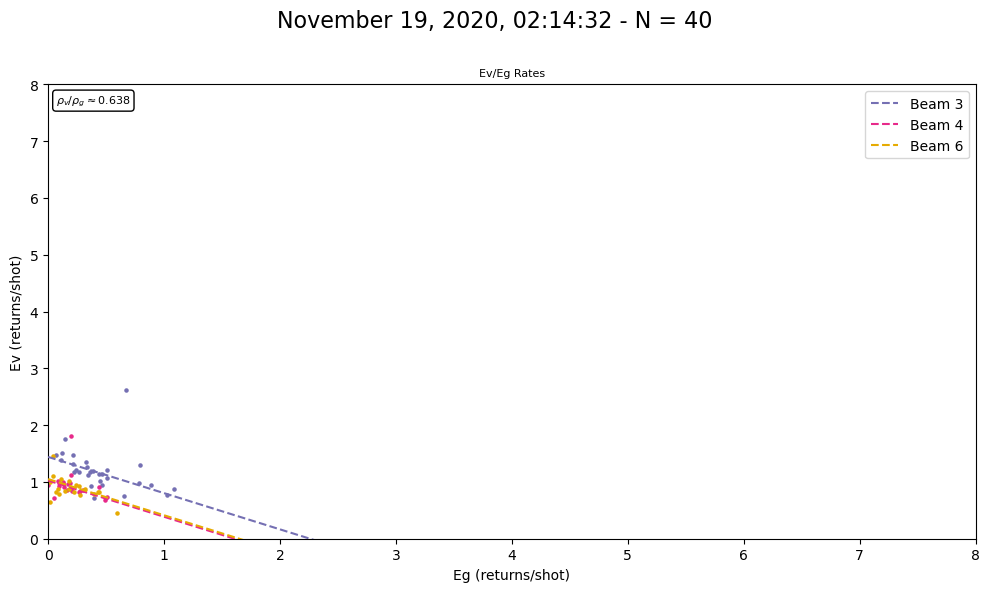

Beam 1 in file 41 has insufficient data.
Beam 2 in file 41 has insufficient data.
Beam 5 in file 41 has insufficient data.
Beam 6 in file 41 has insufficient data.


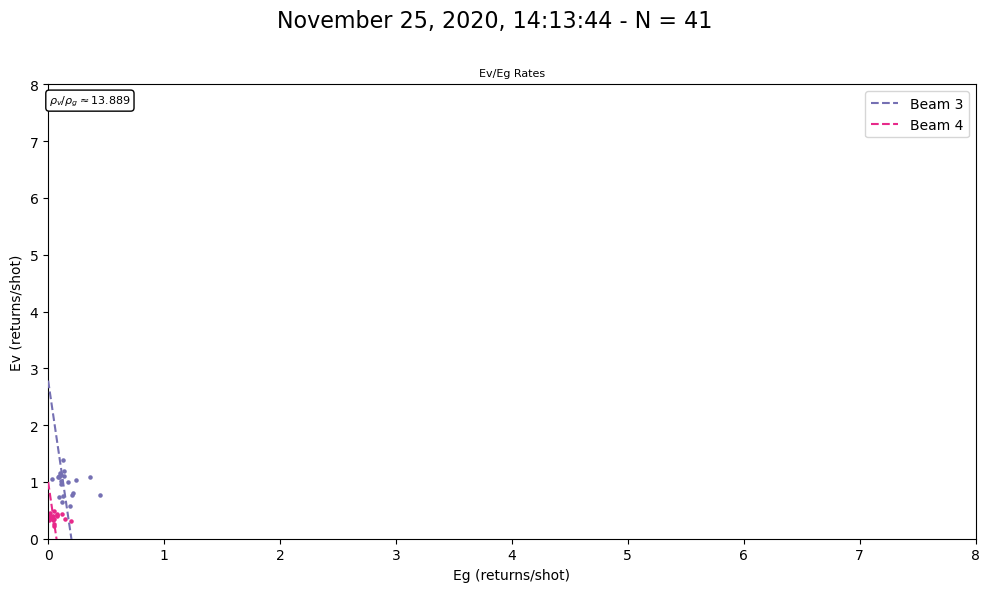

Beam 1 in file 42 has insufficient data.
Beam 2 in file 42 has insufficient data.
Beam 3 in file 42 has insufficient data.
Beam 4 in file 42 has insufficient data.
Beam 5 in file 42 has insufficient data.
Beam 6 in file 42 has insufficient data.
No beams have data in file 42, cannot regress.
Beam 1 in file 43 has insufficient data.
Beam 2 in file 43 has insufficient data.
Beam 3 in file 43 has insufficient data.
Beam 4 in file 43 has insufficient data.
Beam 5 in file 43 has insufficient data.
Beam 6 in file 43 has insufficient data.
No beams have data in file 43, cannot regress.
Beam 1 in file 44 has insufficient data.
Beam 2 in file 44 has insufficient data.
Beam 3 in file 44 has insufficient data.
Beam 4 in file 44 has insufficient data.
Beam 5 in file 44 has insufficient data.
Beam 6 in file 44 has insufficient data.
No beams have data in file 44, cannot regress.
Beam 1 in file 45 has insufficient data.
Beam 2 in file 45 has insufficient data.
Beam 3 in file 45 has insufficient data

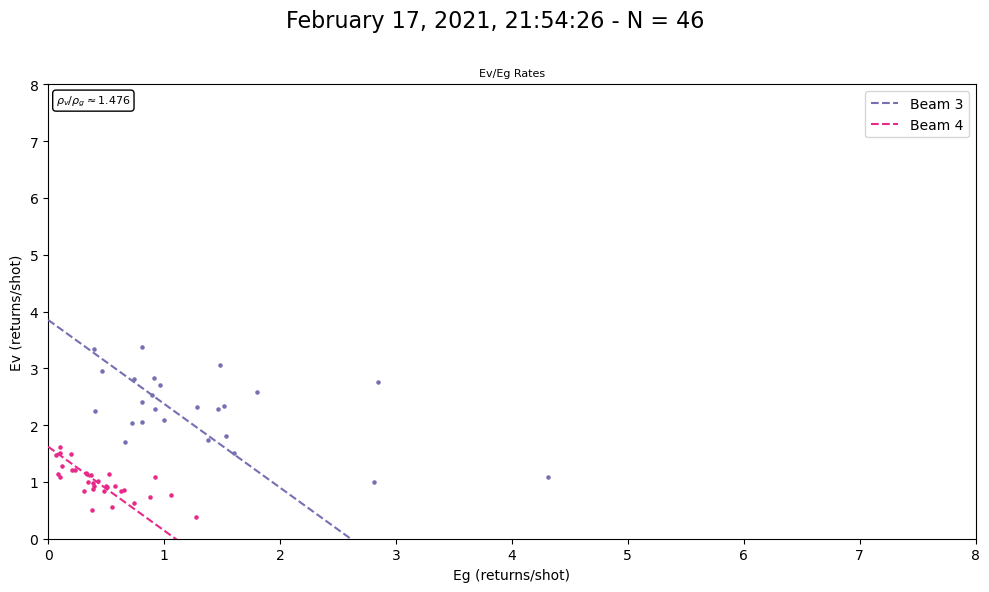

Beam 1 in file 47 has insufficient data.
Beam 2 in file 47 has insufficient data.
Beam 3 in file 47 has insufficient data.
Beam 4 in file 47 has insufficient data.
Beam 5 in file 47 has insufficient data.
Beam 6 in file 47 has insufficient data.
No beams have data in file 47, cannot regress.
Beam 1 in file 48 has insufficient data.
Beam 2 in file 48 has insufficient data.
Beam 3 in file 48 has insufficient data.
Beam 4 in file 48 has insufficient data.
Beam 5 in file 48 has insufficient data.
Beam 6 in file 48 has insufficient data.
No beams have data in file 48, cannot regress.
Beam 1 in file 49 has insufficient data.
Beam 2 in file 49 has insufficient data.
Beam 3 in file 49 has insufficient data.
Beam 4 in file 49 has insufficient data.
Beam 5 in file 49 has insufficient data.
Beam 6 in file 49 has insufficient data.
No beams have data in file 49, cannot regress.
Beam 1 in file 50 has insufficient data.
Beam 2 in file 50 has insufficient data.
Beam 3 in file 50 has insufficient data

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 52 has insufficient data.
Beam 5 in file 52 has insufficient data.
Beam 6 in file 52 has insufficient data.
No beams have data in file 52, cannot regress.
Beam 1 in file 53 has insufficient data.
Beam 2 in file 53 has insufficient data.
Beam 3 in file 53 has insufficient data.
Beam 4 in file 53 has insufficient data.
Beam 5 in file 53 has insufficient data.
Beam 6 in file 53 has insufficient data.
No beams have data in file 53, cannot regress.
Beam 1 in file 54 has insufficient data.
Beam 6 in file 54 has insufficient data.


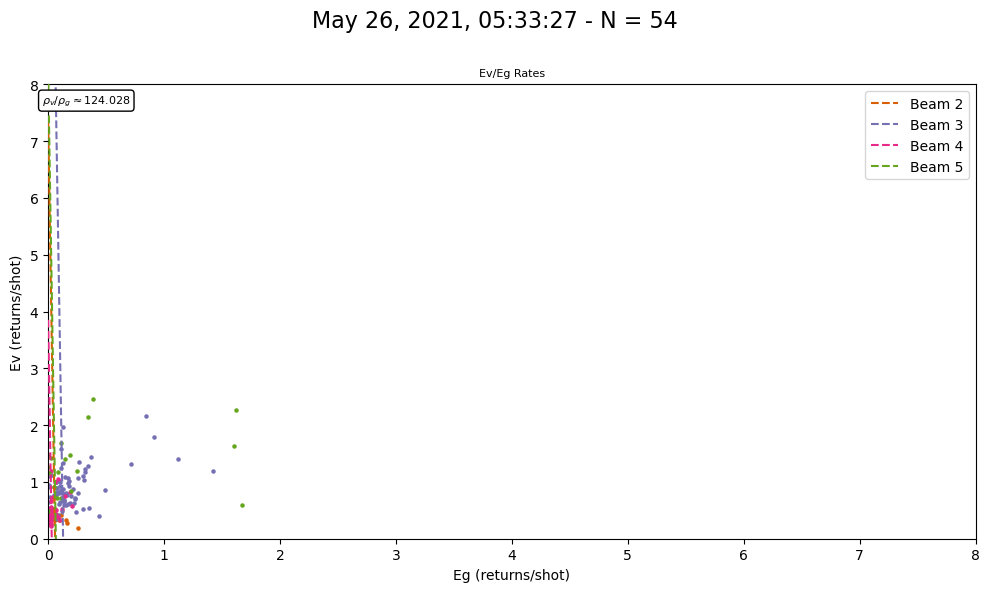

Beam 1 in file 55 has insufficient data.
Beam 2 in file 55 has insufficient data.
Beam 3 in file 55 has insufficient data.
Beam 4 in file 55 has insufficient data.
Beam 5 in file 55 has insufficient data.
Beam 6 in file 55 has insufficient data.
No beams have data in file 55, cannot regress.
Beam 1 in file 56 has insufficient data.
Beam 2 in file 56 has insufficient data.
Beam 3 in file 56 has insufficient data.
Beam 4 in file 56 has insufficient data.
Beam 5 in file 56 has insufficient data.
Beam 6 in file 56 has insufficient data.
No beams have data in file 56, cannot regress.
Beam 1 in file 57 has insufficient data.
Beam 2 in file 57 has insufficient data.
Beam 3 in file 57 has insufficient data.
Beam 4 in file 57 has insufficient data.
Beam 5 in file 57 has insufficient data.
Beam 6 in file 57 has insufficient data.
No beams have data in file 57, cannot regress.
Beam 1 in file 58 has insufficient data.
Beam 2 in file 58 has insufficient data.
Beam 3 in file 58 has insufficient data

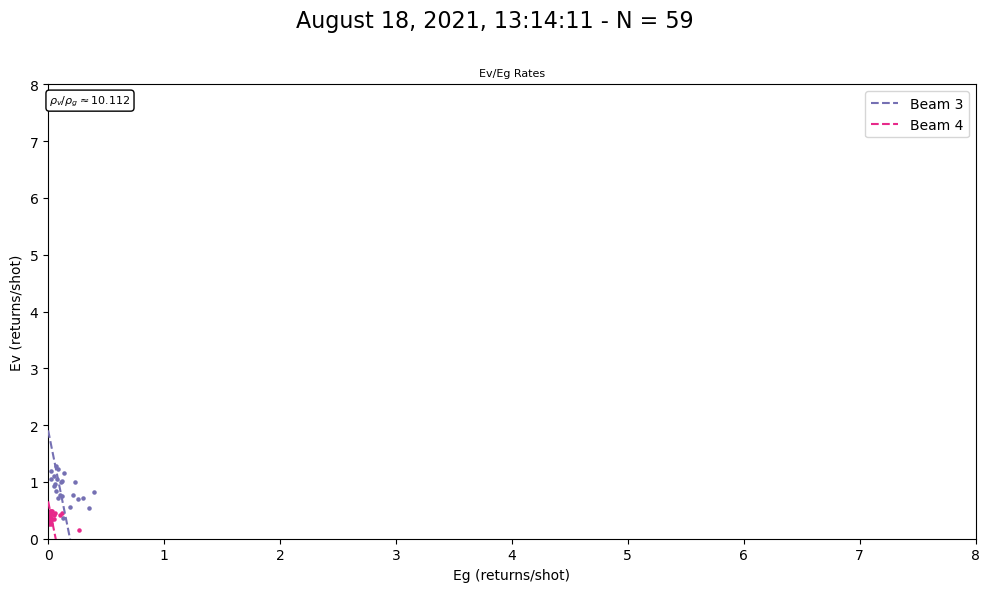

Beam 1 in file 60 has insufficient data.
Beam 2 in file 60 has insufficient data.
Beam 3 in file 60 has insufficient data.
Beam 4 in file 60 has insufficient data.
Beam 5 in file 60 has insufficient data.
Beam 6 in file 60 has insufficient data.
No beams have data in file 60, cannot regress.
Beam 1 in file 61 has insufficient data.
Beam 2 in file 61 has insufficient data.
Beam 3 in file 61 has insufficient data.
Beam 4 in file 61 has insufficient data.
Beam 5 in file 61 has insufficient data.
Beam 6 in file 61 has insufficient data.
No beams have data in file 61, cannot regress.
Beam 1 in file 62 has insufficient data.
Beam 2 in file 62 has insufficient data.
Beam 3 in file 62 has insufficient data.
Beam 4 in file 62 has insufficient data.
Beam 5 in file 62 has insufficient data.


/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 6 in file 62 has insufficient data.
No beams have data in file 62, cannot regress.
Beam 1 in file 63 has insufficient data.
Beam 2 in file 63 has insufficient data.
Beam 3 in file 63 has insufficient data.
Beam 4 in file 63 has insufficient data.
Beam 5 in file 63 has insufficient data.
Beam 6 in file 63 has insufficient data.
No beams have data in file 63, cannot regress.
Beam 1 in file 64 has insufficient data.
Beam 2 in file 64 has insufficient data.
Beam 3 in file 64 has insufficient data.
Beam 4 in file 64 has insufficient data.
Beam 5 in file 64 has insufficient data.
Beam 6 in file 64 has insufficient data.
No beams have data in file 64, cannot regress.
Beam 1 in file 65 has insufficient data.
Beam 2 in file 65 has insufficient data.
Beam 3 in file 65 has insufficient data.
Beam 4 in file 65 has insufficient data.
Beam 5 in file 65 has insufficient data.
Beam 6 in file 65 has insufficient data.
No beams have data in file 65, cannot regress.
Beam 1 in file 66 has insufficien

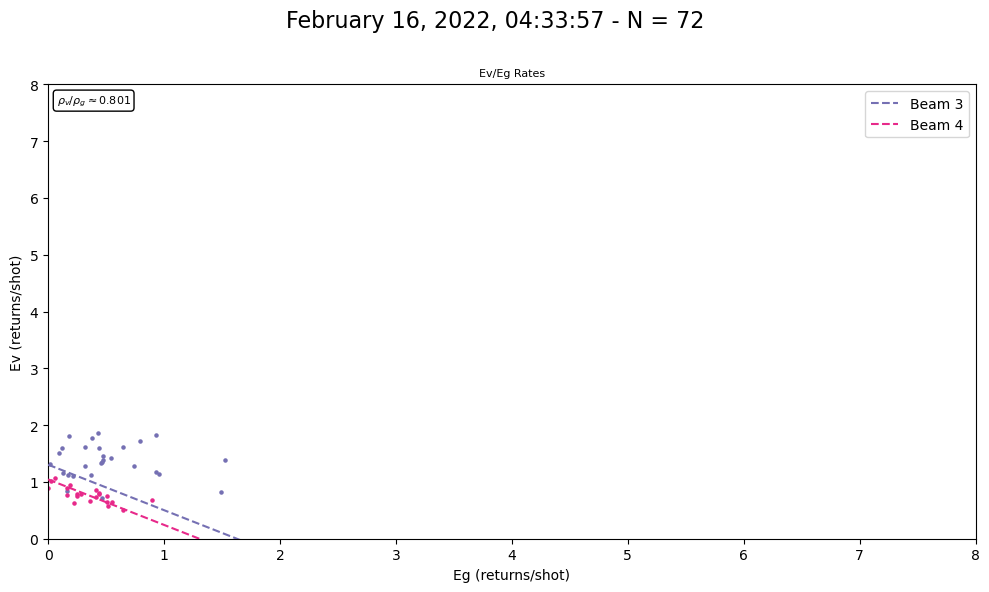

Beam 1 in file 73 has insufficient data.
Beam 2 in file 73 has insufficient data.
Beam 5 in file 73 has insufficient data.
Beam 6 in file 73 has insufficient data.


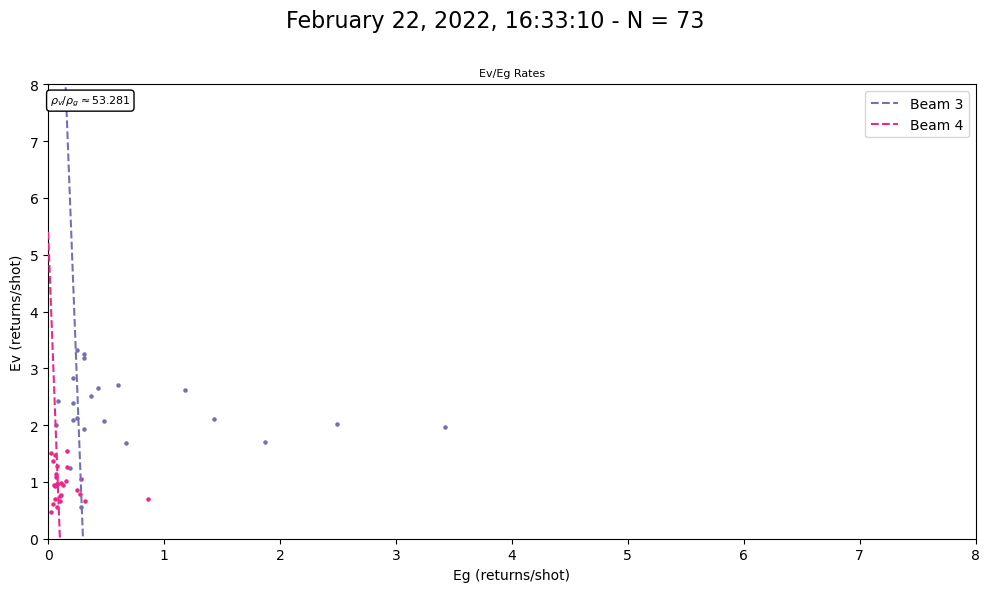

Beam 1 in file 74 has insufficient data.
Beam 2 in file 74 has insufficient data.
Beam 3 in file 74 has insufficient data.
Beam 4 in file 74 has insufficient data.
Beam 5 in file 74 has insufficient data.
Beam 6 in file 74 has insufficient data.
No beams have data in file 74, cannot regress.
Beam 1 in file 75 has insufficient data.
Beam 2 in file 75 has insufficient data.
Beam 3 in file 75 has insufficient data.
Beam 4 in file 75 has insufficient data.
Beam 5 in file 75 has insufficient data.
Beam 6 in file 75 has insufficient data.
No beams have data in file 75, cannot regress.
Beam 1 in file 76 has insufficient data.
Beam 2 in file 76 has insufficient data.
Beam 3 in file 76 has insufficient data.
Beam 4 in file 76 has insufficient data.
Beam 5 in file 76 has insufficient data.
Beam 6 in file 76 has insufficient data.
No beams have data in file 76, cannot regress.
Beam 1 in file 77 has insufficient data.
Beam 2 in file 77 has insufficient data.
Beam 3 in file 77 has insufficient data

/home/s1803229/work/scripts/parallel.py:457: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)


Beam 4 in file 80 has insufficient data.
Beam 5 in file 80 has insufficient data.
Beam 6 in file 80 has insufficient data.
No beams have data in file 80, cannot regress.
Beam 1 in file 81 has insufficient data.
Beam 2 in file 81 has insufficient data.
Beam 3 in file 81 has insufficient data.
Beam 4 in file 81 has insufficient data.
Beam 5 in file 81 has insufficient data.
Beam 6 in file 81 has insufficient data.
No beams have data in file 81, cannot regress.
Beam 1 in file 82 has insufficient data.
Beam 2 in file 82 has insufficient data.
Beam 3 in file 82 has insufficient data.
Beam 4 in file 82 has insufficient data.
Beam 5 in file 82 has insufficient data.
Beam 6 in file 82 has insufficient data.
No beams have data in file 82, cannot regress.
Beam 1 in file 83 has insufficient data.
Beam 2 in file 83 has insufficient data.
Beam 3 in file 83 has insufficient data.
Beam 4 in file 83 has insufficient data.
Beam 5 in file 83 has insufficient data.
Beam 6 in file 83 has insufficient data

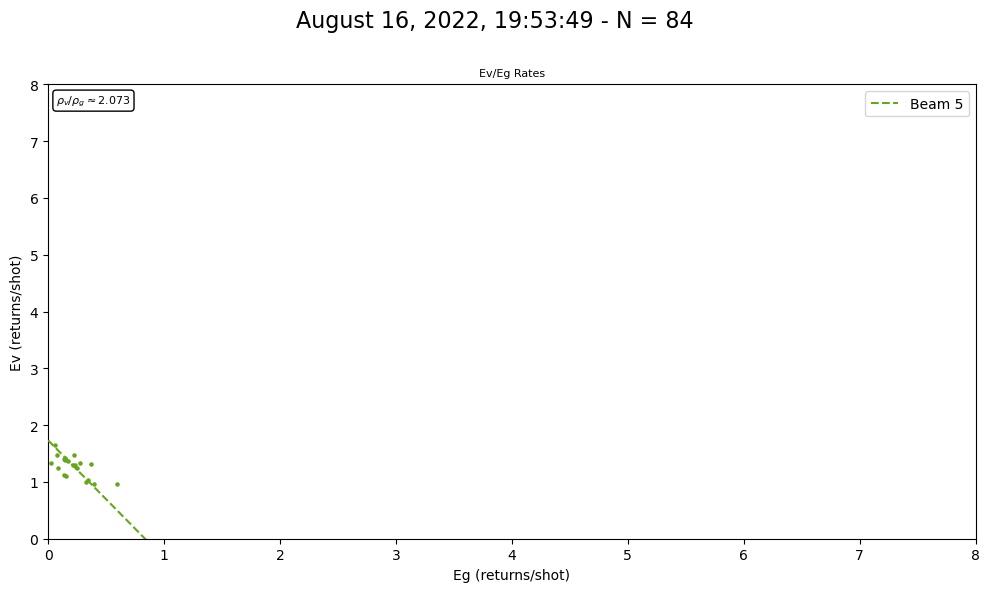

Beam 2 in file 85 has insufficient data.
Beam 3 in file 85 has insufficient data.
Beam 4 in file 85 has insufficient data.
Beam 6 in file 85 has insufficient data.


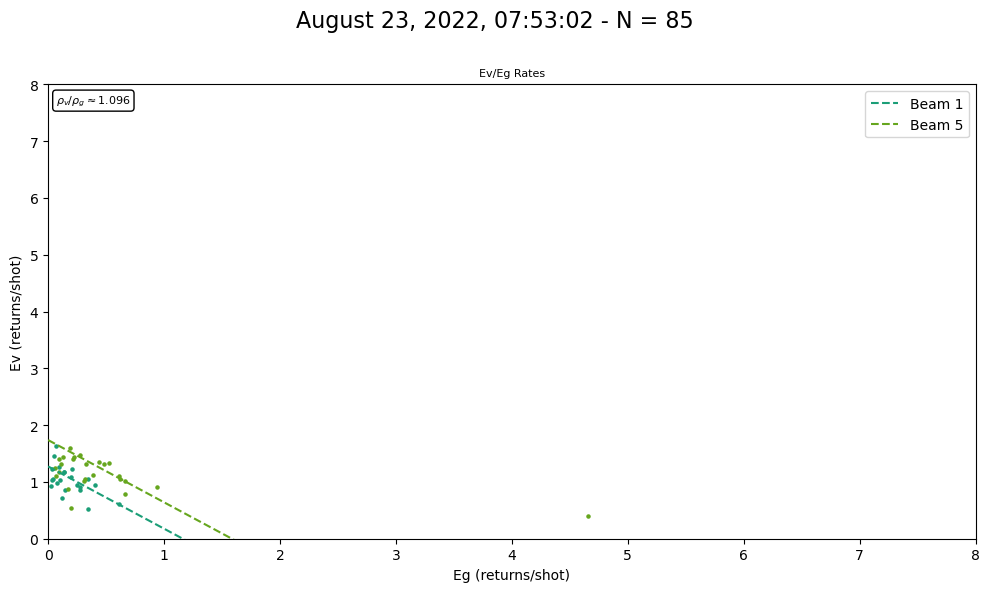

Beam 1 in file 86 has insufficient data.
Beam 2 in file 86 has insufficient data.
Beam 3 in file 86 has insufficient data.
Beam 4 in file 86 has insufficient data.
Beam 5 in file 86 has insufficient data.
Beam 6 in file 86 has insufficient data.
No beams have data in file 86, cannot regress.
Beam 1 in file 87 has insufficient data.
Beam 2 in file 87 has insufficient data.
Beam 3 in file 87 has insufficient data.
Beam 4 in file 87 has insufficient data.
Beam 5 in file 87 has insufficient data.
Beam 6 in file 87 has insufficient data.
No beams have data in file 87, cannot regress.
Beam 1 in file 88 has insufficient data.
Beam 2 in file 88 has insufficient data.
Beam 3 in file 88 has insufficient data.
Beam 4 in file 88 has insufficient data.
Beam 5 in file 88 has insufficient data.
Beam 6 in file 88 has insufficient data.
No beams have data in file 88, cannot regress.
Beam 1 in file 89 has insufficient data.
Beam 2 in file 89 has insufficient data.
Beam 3 in file 89 has insufficient data

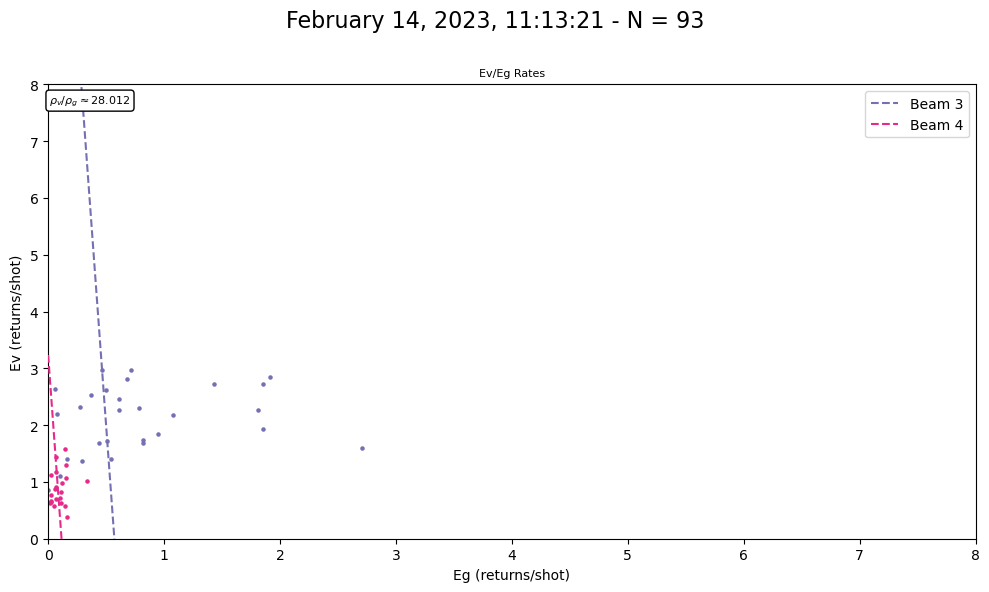

Beam 1 in file 94 has insufficient data.
Beam 2 in file 94 has insufficient data.
Beam 5 in file 94 has insufficient data.
Beam 6 in file 94 has insufficient data.


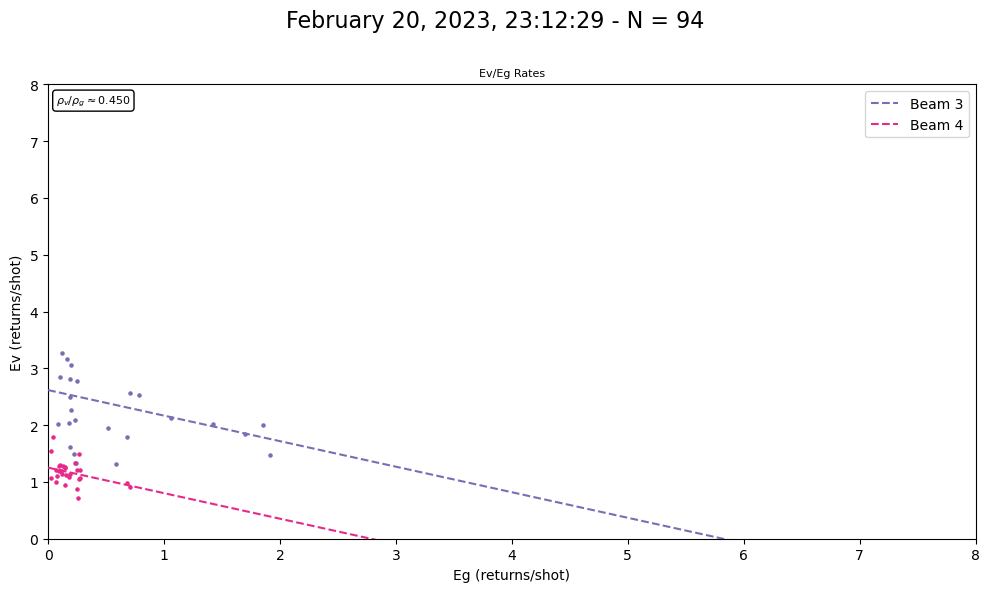

Beam 1 in file 95 has insufficient data.
Beam 2 in file 95 has insufficient data.
Beam 3 in file 95 has insufficient data.
Beam 4 in file 95 has insufficient data.
Beam 5 in file 95 has insufficient data.
Beam 6 in file 95 has insufficient data.
No beams have data in file 95, cannot regress.
Beam 1 in file 96 has insufficient data.
Beam 2 in file 96 has insufficient data.
Beam 3 in file 96 has insufficient data.
Beam 4 in file 96 has insufficient data.
Beam 5 in file 96 has insufficient data.
Beam 6 in file 96 has insufficient data.
No beams have data in file 96, cannot regress.
Beam 1 in file 97 has insufficient data.
Beam 2 in file 97 has insufficient data.
Beam 3 in file 97 has insufficient data.
Beam 4 in file 97 has insufficient data.
Beam 5 in file 97 has insufficient data.
Beam 6 in file 97 has insufficient data.
No beams have data in file 97, cannot regress.
Beam 1 in file 98 has insufficient data.
Beam 2 in file 98 has insufficient data.
Beam 3 in file 98 has insufficient data

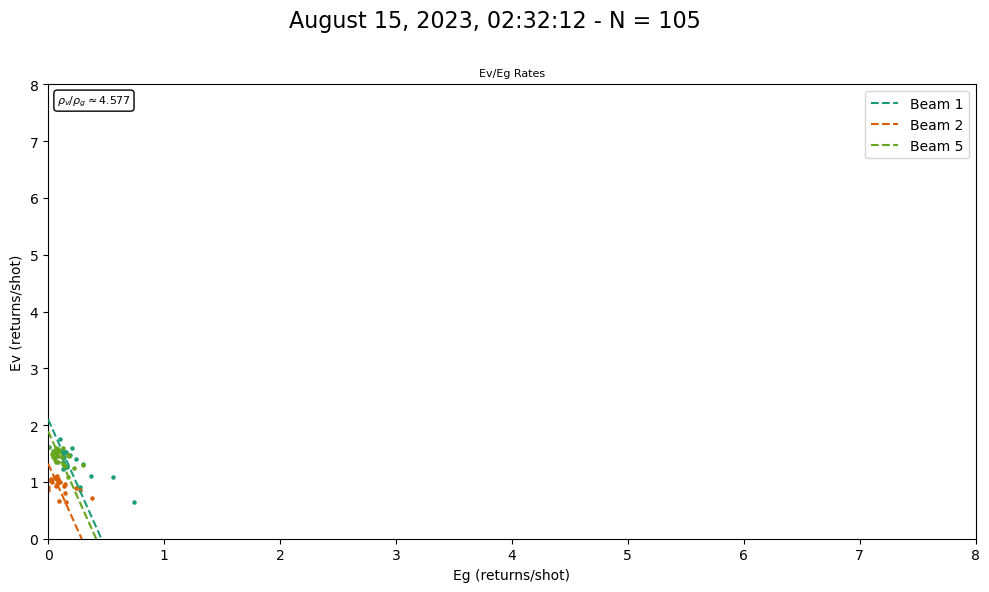

Beam 2 in file 106 has insufficient data.
Beam 3 in file 106 has insufficient data.
Beam 4 in file 106 has insufficient data.
Beam 5 in file 106 has insufficient data.
Beam 6 in file 106 has insufficient data.


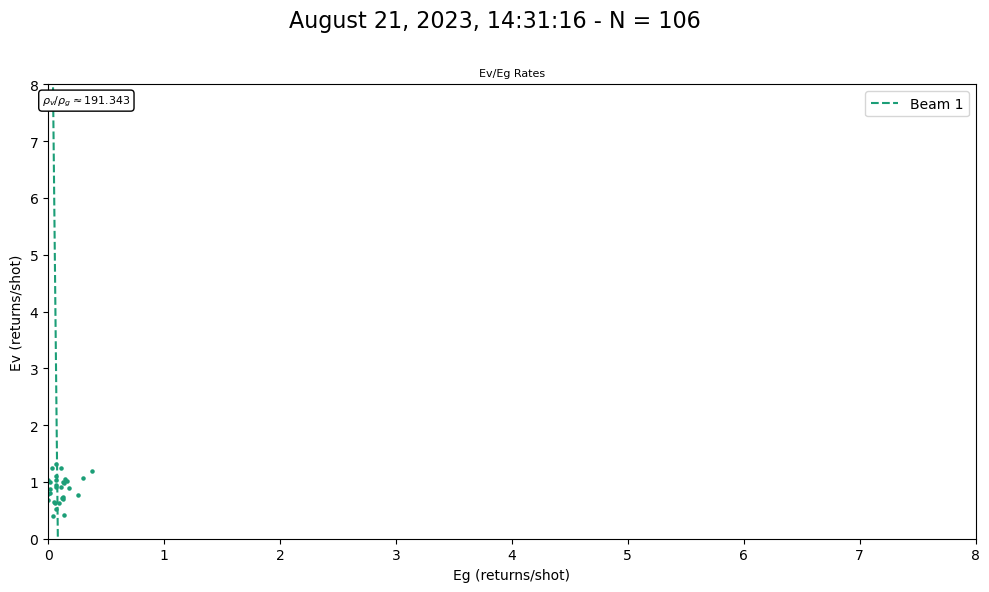

Beam 1 in file 107 has insufficient data.
Beam 2 in file 107 has insufficient data.
Beam 3 in file 107 has insufficient data.
Beam 4 in file 107 has insufficient data.
Beam 5 in file 107 has insufficient data.
Beam 6 in file 107 has insufficient data.
No beams have data in file 107, cannot regress.
Beam 1 in file 108 has insufficient data.
Beam 2 in file 108 has insufficient data.
Beam 3 in file 108 has insufficient data.
Beam 4 in file 108 has insufficient data.
Beam 5 in file 108 has insufficient data.
Beam 6 in file 108 has insufficient data.
No beams have data in file 108, cannot regress.
Beam 1 in file 109 has insufficient data.
Beam 2 in file 109 has insufficient data.
Beam 3 in file 109 has insufficient data.
Beam 4 in file 109 has insufficient data.
Beam 5 in file 109 has insufficient data.
Beam 6 in file 109 has insufficient data.
No beams have data in file 109, cannot regress.
Beam 1 in file 110 has insufficient data.
Beam 2 in file 110 has insufficient data.
Beam 3 in file 1

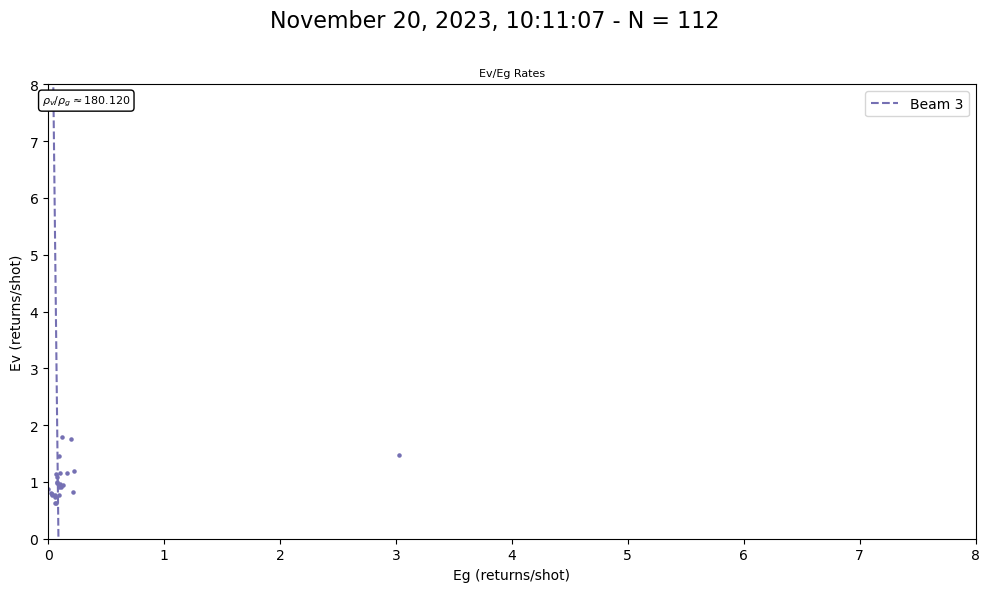

In [14]:
from scripts.parallel import *

# dirpath = 'R:/data/sodankyla_full/'
dirpath = '../data_store/data/torgnon/'

# data = []

all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

coords = (7.5609, 45.8238)

# problematic: 2,7,10,11,12,17,19,21,22,26,27,29
# 11 seems very fixable

for i in range(N):
    data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
                         graph_detail=1, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1, altitude = 2091)
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=.1,height=.1,\
    #                      graph_detail=1, loss='linear',file_index=i, keep_flagged=1, opsys='bad',f_scale=.05, altitude = 2091)
#     print(data)

## Algorithm adjustment?

In [ ]:
# from scripts.parallel import *

# # dirpath = 'R:/data/sodankyla_full/'
# dirpath = '../data_store/data/sodankyla_full/'

# # data = []

# all_ATL03, all_ATL08 = track_pairs(dirpath)
# N = len(all_ATL03)

# sodankyla_coords = (26.634154, 67.361833)

# # Files 16, 28, 33, 40, 56, 57, 58 are not regressed well. Worth looking at algorithm in those cases.
# # Files 9, 11, 15 to an extent as well

# for i in range(N):
#     data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=sodankyla_coords, width=.1,height=.1,\
#                          graph_detail=2, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1)
# #     print(data)

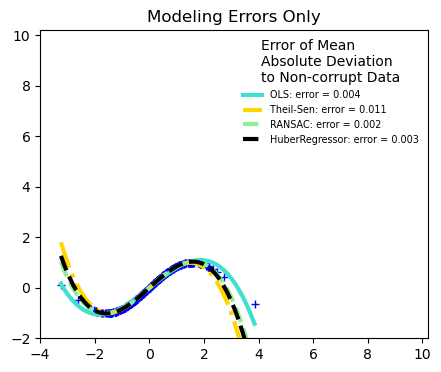

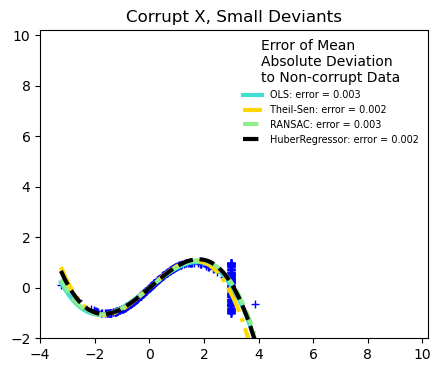

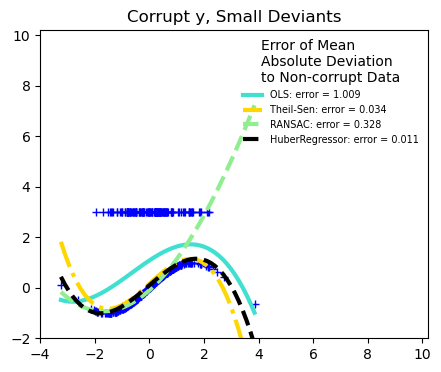

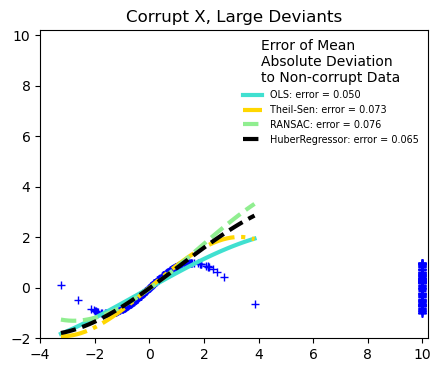

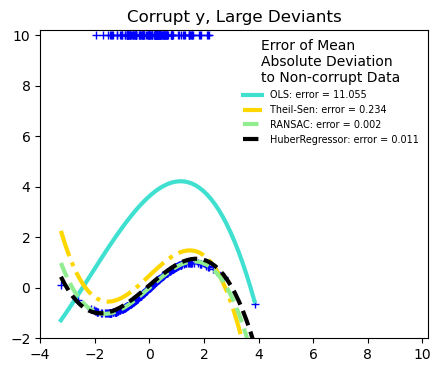

In [6]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
    ("HuberRegressor", HuberRegressor()),
]
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "HuberRegressor": "black",
}
linestyle = {"OLS": "-", "Theil-Sen": "-.", "RANSAC": "--", "HuberRegressor": "--"}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
    ("Modeling Errors Only", X, y),
    ("Corrupt X, Small Deviants", X_errors, y),
    ("Corrupt y, Small Deviants", X, y_errors),
    ("Corrupt X, Large Deviants", X_errors_large, y),
    ("Corrupt y, Large Deviants", X, y_errors_large),
]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, "b+")

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label="%s: error = %.3f" % (name, mse),
        )

    legend_title = "Error of Mean\nAbsolute Deviation\nto Non-corrupt Data"
    legend = plt.legend(
        loc="upper right", frameon=False, title=legend_title, prop=dict(size="x-small")
    )
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()